<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#My-imports" data-toc-modified-id="My-imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>My imports</a></span></li><li><span><a href="#From-Yatang's-repo" data-toc-modified-id="From-Yatang's-repo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>From Yatang's repo</a></span></li></ul></div>

# From cell_types_main.py

In [1]:
# -*- coding: utf-8 -*-
"""
Created on 20221130

this version is for publishing, all unnecessary codes are removed

@author: yatang
"""
# -*- coding: utf-8 -*-
#%%
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy.spatial import ConvexHull
import hdf5storage
import pandas as pd
from sklearn.preprocessing import StandardScaler
import timeit
import cv2
__file__ = 'cell_types_main.py' # MM added to notebook
abspath = os.path.abspath(__file__)
dname = os.path.dirname(abspath)
os.chdir(dname)

In [2]:
if dname not in sys.path: 
    sys.path.append(dname)

from cell_types_utils import *
#%% define file path
folder_path = os.path.dirname(dname)+'/'
folder_data = folder_path+'data/'

data_path = {
            'neuron':'neuron.mat',
            'chirp':'chirp.mat',
            'dl_lr':'dl_lr.mat',
            'mb':'mb.mat',
            'color':'color.mat',
            'st':'st.mat',
            'rf':'rf.mat',
            }
# all data are re-sampled at 5Hz
sampling_rate = 5 #Hz
fig_width = 8
fig_height = 18

# save plot to the figures folder
folder_figure = folder_path+'figures/'
save_fig = True

In [3]:
#%% load data
neuron,chirp,dl_lr,mb,color,st,rf = load_data_new(folder_data, data_path)
num_neuron = neuron['soma_size'].size

In [4]:
#%% extract features from chirp data using sparse PCA;  
# note mean(pc)=0 but std(pc)!=1
pc_spca_chirp, pv_spca_chirp = sparse_pca_analysis(chirp['chirp_temporal_norm'], k_spca=20)
pc_spca_mb, pv_spca_mb = sparse_pca_analysis(mb['mb_temporal_sorted_truncated_norm'], k_spca=6)
pc_spca_dl_lr, pv_spca_dl_lr = sparse_pca_analysis(dl_lr['dl_lr_temporal_sorted_truncated_norm'], k_spca=6)
pc_spca_color, pv_spca_color = sparse_pca_analysis(color['color_temporal_norm'], k_spca=8)
pc_spca_st, pv_spca_st = sparse_pca_analysis(st['st_temporal_norm'], k_spca=10)

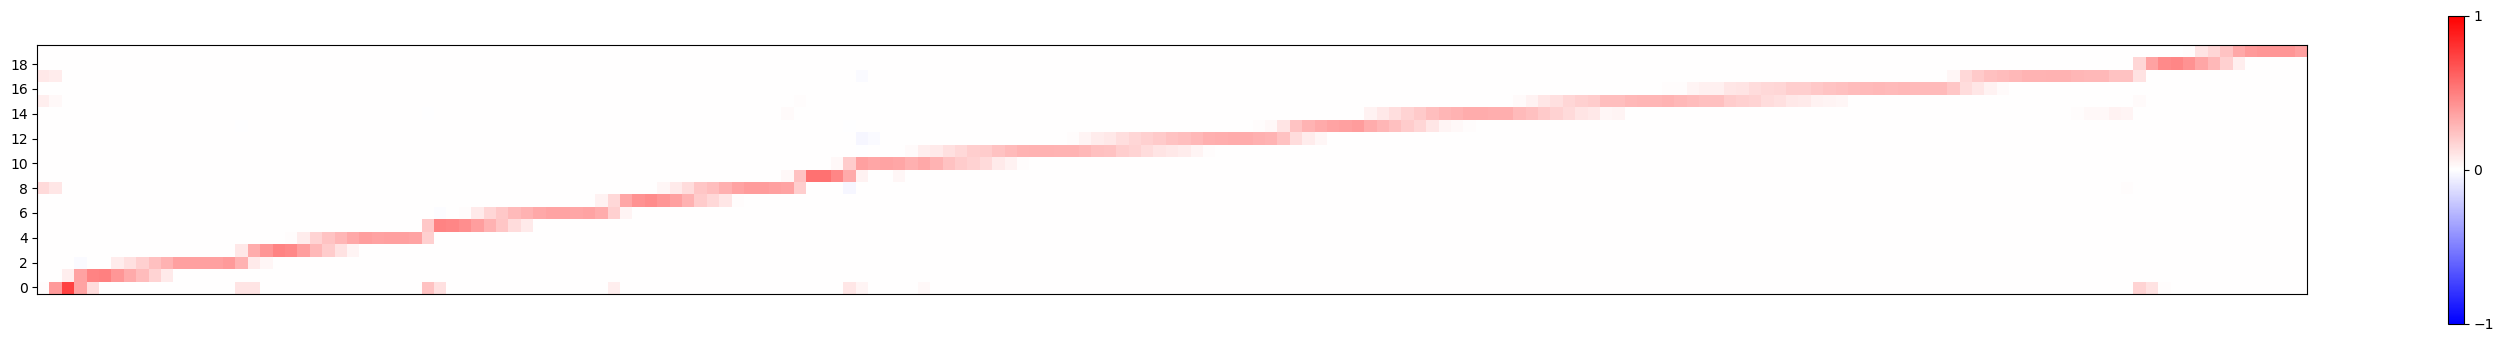

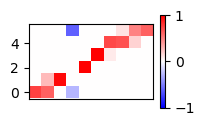

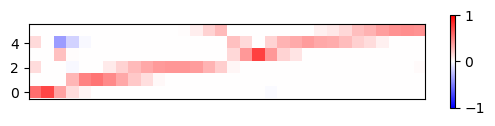

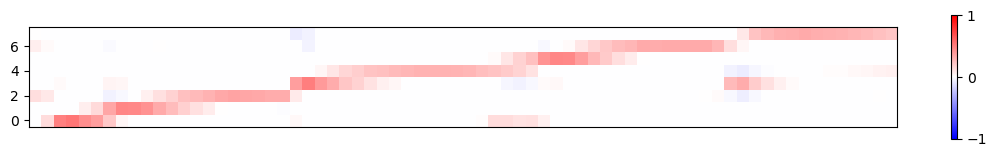

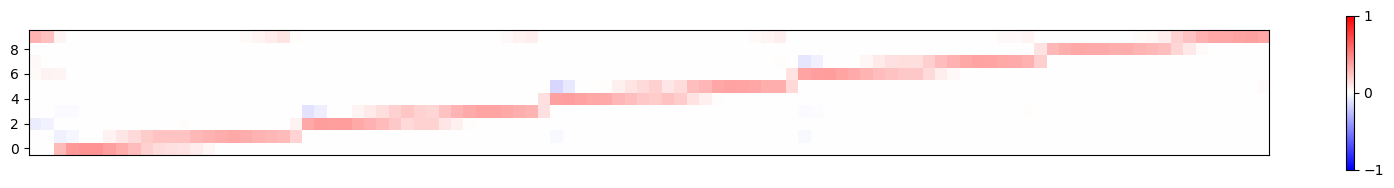

In [5]:
# Figure 7A, related to Figure 2
imshow_PV(pv_spca_chirp,cmap='bwr',vmin=-1,vmax=1)
if save_fig:
    plt.savefig(folder_figure+'figure_7A_chirp.png',bbox_inches='tight')
plt.show()
imshow_PV(pv_spca_mb,cmap='bwr',vmin=-1,vmax=1)
if save_fig:
    plt.savefig(folder_figure+'figure_7A_mb.png',bbox_inches='tight')
plt.show()
imshow_PV(pv_spca_dl_lr,cmap='bwr',vmin=-1,vmax=1)
if save_fig:
    plt.savefig(folder_figure+'figure_7A_dl_lr.png',bbox_inches='tight')
plt.show()
imshow_PV(pv_spca_color,cmap='bwr',vmin=-1,vmax=1)
if save_fig:
    plt.savefig(folder_figure+'figure_7A_color.png',bbox_inches='tight')
plt.show()
imshow_PV(pv_spca_st,cmap='bwr',vmin=-1,vmax=1)
if save_fig:
    plt.savefig(folder_figure+'figure_7A_st.png',bbox_inches='tight')

In [6]:
#%% make the feature matrix X and its temporal profile X_temporal
feature_other_list = [dl_lr['dl_hi'], mb['mb_gdsi'], mb['mb_gosi'], mb['msi']]

for i, m in enumerate(feature_other_list):
    if len(m.shape) == 1:
        m = np.expand_dims(m, axis=1)
    if i == 0:
        feature_other_raw = m
    else:
        feature_other_raw = np.append(feature_other_raw, m, axis=1)

feature_other = StandardScaler().fit_transform(feature_other_raw)
feature_other_norm = norm_x(feature_other_raw)

X_sorted = np.concatenate((pc_spca_chirp,pc_spca_mb,pc_spca_dl_lr,pc_spca_color,
                           pc_spca_st,feature_other), axis=1)

X_temporal = np.concatenate((mb['mb_temporal_sorted_truncated_norm'],
                             dl_lr['dl_lr_temporal_sorted_truncated_norm'], 
                             chirp['chirp_temporal_norm'], st['st_temporal_norm'], 
                             color['color_temporal_norm'], feature_other_norm), axis=1)

X = StandardScaler().fit_transform(X_sorted)
_,num_feature = X.shape

In [7]:
#%% find the optimal cluster number using GMM, this takes 1-2 days.
load_gmm_data = True # set this False to recompute
if load_gmm_data:
    bic =  np.loadtxt(folder_path+'data/bic.csv',delimiter=',')
    n_cluster_optimal = np.argmin(bic)+2
    labels_arr = np.loadtxt(folder_path+'data/labels_arr.csv',delimiter=',')
    # labels_arr_optimal = np.loadtxt(folder_path+'data/labels_arr_optimal.csv',delimiter=',')
else:
    start = timeit.default_timer()
    n_cluster_max = 50
    # [n_cluster_optimal, aic, bic, silhouette_score,labels_arr] = optimal_cluster_gmm(X,n_cluster_max,random_init=True)
    [n_cluster_optimal, _, bic_all, _,labels_arr_all,_] = optimal_cluster_gmm(X,n_cluster_max,random_init=False,n_init=1000)
    stop = timeit.default_timer()
    print(stop-start)
    labels_arr_all = labels_arr_all.astype(dtype=np.dtype('uint8'))
    bic_optimal_all = bic_all[n_cluster_optimal-2,:]
    bic_optimal_all_sorted = np.sort(bic_optimal_all)
    bic = np.min(bic_all,axis=1)
    bic_idx = np.argmin(bic_all,axis=1)
    labels_arr = np.zeros((num_neuron,n_cluster_max-1),dtype=np.dtype('uint8'))
    for i in range(n_cluster_max-1):
        labels_arr[:,i] = labels_arr_all[:,i,bic_idx[i]]
    # labels_arr_optimal = labels_arr_all[:,n_cluster_optimal-2,:]
    np.savetxt(folder_path+'data/bic.csv', bic, delimiter=',')
    np.savetxt(folder_path+'data/labels_arr.csv', labels_arr, delimiter=',')
    # np.savetxt(folder_path+'data/labels_arr_optimal.csv', labels_arr_optimal, delimiter=',')

num_type = n_cluster_optimal    

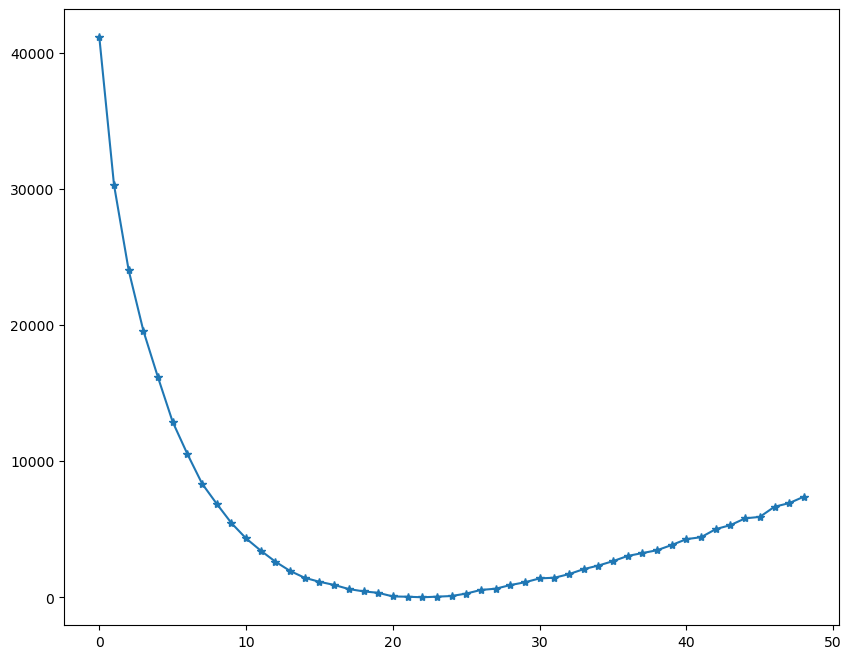

In [8]:
# plot Figure 2B 
fig,ax = plt.subplots(1,1,figsize=(10,8))   
ax.plot(bic-np.min(bic),'-*')
if save_fig:
    plt.savefig(folder_figure+'figure_2B.png',bbox_inches='tight')
plt.show()

In [9]:
#%% cluster neurons based on labels    
labels_gmm = labels_arr[:,num_type-2]    
# show clusters and their distance in feature space
X_cluster_gmm,_,_,_ = plot_cluster(X,labels_gmm,[],sampling_rate=1)    
cluster_dist_gmm = plot_cluster_dist(X_cluster_gmm)
# show cluster in temporal space
X_temporal_cluster_gmm,X_temporal_cluster_gmm_error,_,_ = plot_cluster(X_temporal,labels_gmm,[])

In [10]:
#%% plot dendrogram as 2d image and resort the temporal matrix
fig_params_dendro = {'ax_dendro':[0,0,0.1,1],
                     'ax_matrix':[0.132,0,0.8,1],
                     'ax_colorbar':[0.94,0,0.02,1],
                     'text_offset':[0,3]}

idx_sorted, labels_gmm_dendro, cluster_size_gmm = dendrogram_x(X_cluster_gmm, X_temporal_cluster_gmm, labels_gmm, 
                                                               fig_params_dendro, [], fig_zoom=2.5,plot_bool=False) 

X_cluster_gmm_dendro, X_cluster_gmm_dendro_error, _, X_cluster_gmm_dendro_num = plot_cluster(
    X,labels_gmm_dendro,[],sampling_rate=1)

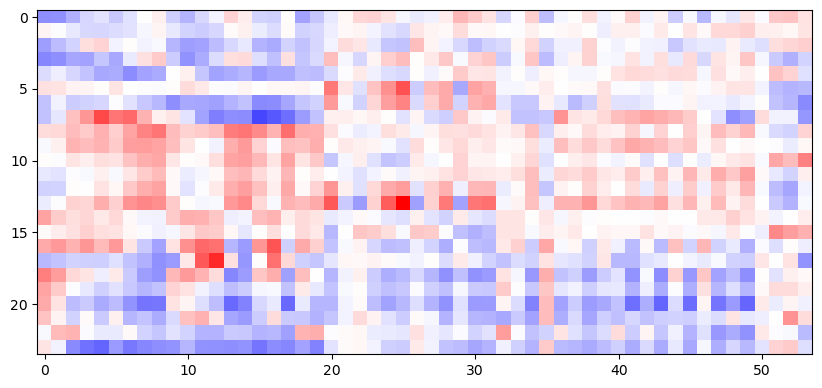

In [11]:
# Figure 7B, related to Figure 2
fig,ax = plt.subplots(1,1,figsize=(10,8))   
norm = colors.TwoSlopeNorm(vcenter=0,vmin=-2.6,vmax=2.6)
ax.imshow(X_cluster_gmm_dendro,cmap='bwr',norm=norm)
if save_fig:
    plt.savefig(folder_figure+'figure_7B.png',bbox_inches='tight')
plt.show()      

In [12]:
pv_k_X_cluster_gmm_dendro, lamda_cumsum_X_cluster_gmm_dendro, pc_k_X_cluster_gmm_dendro = pca_x(X_cluster_gmm_dendro)
pc_k_X_cluster_gmm_dendro_reverse = pc_k_X_cluster_gmm_dendro[::-1,:]

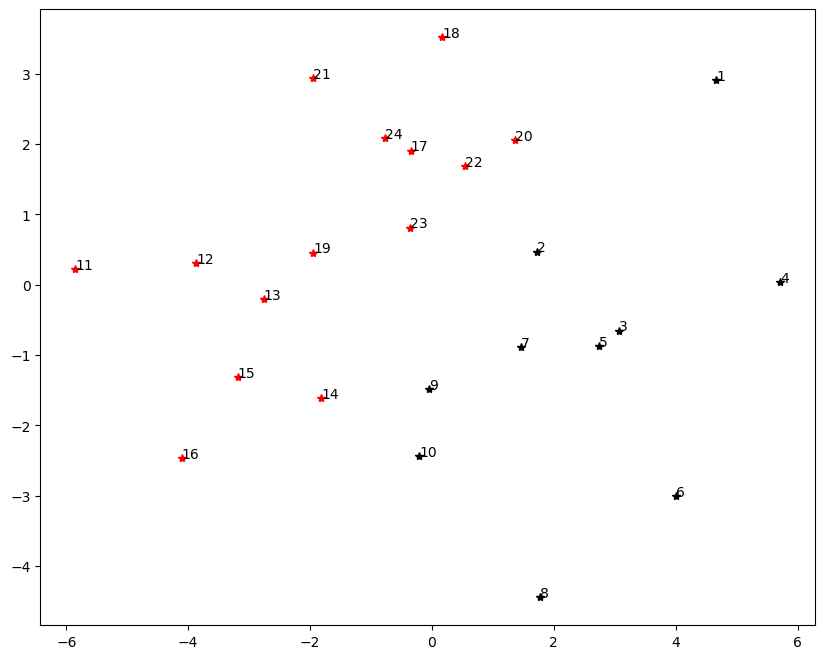

In [13]:
# Figure 2C  
fig,ax = plt.subplots(1,1,figsize=(10,8))   
if pc_k_X_cluster_gmm_dendro_reverse[:10,0].sum()<0:
    pc_k_X_cluster_gmm_dendro_reverse[:,0] = - pc_k_X_cluster_gmm_dendro_reverse[:,0]
ax.plot(pc_k_X_cluster_gmm_dendro_reverse[:10,0],pc_k_X_cluster_gmm_dendro_reverse[:10,1],'*',color='black')
ax.plot(pc_k_X_cluster_gmm_dendro_reverse[10:,0],pc_k_X_cluster_gmm_dendro_reverse[10:,1],'*',color='red')
for i in range(num_type):
    ax.text(pc_k_X_cluster_gmm_dendro_reverse[i,0],pc_k_X_cluster_gmm_dendro_reverse[i,1],str(i+1))
ax.set_aspect('auto')
if save_fig:
    plt.savefig(folder_figure+'figure_2C.png',bbox_inches='tight')
plt.show()   

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
234.23609869399996


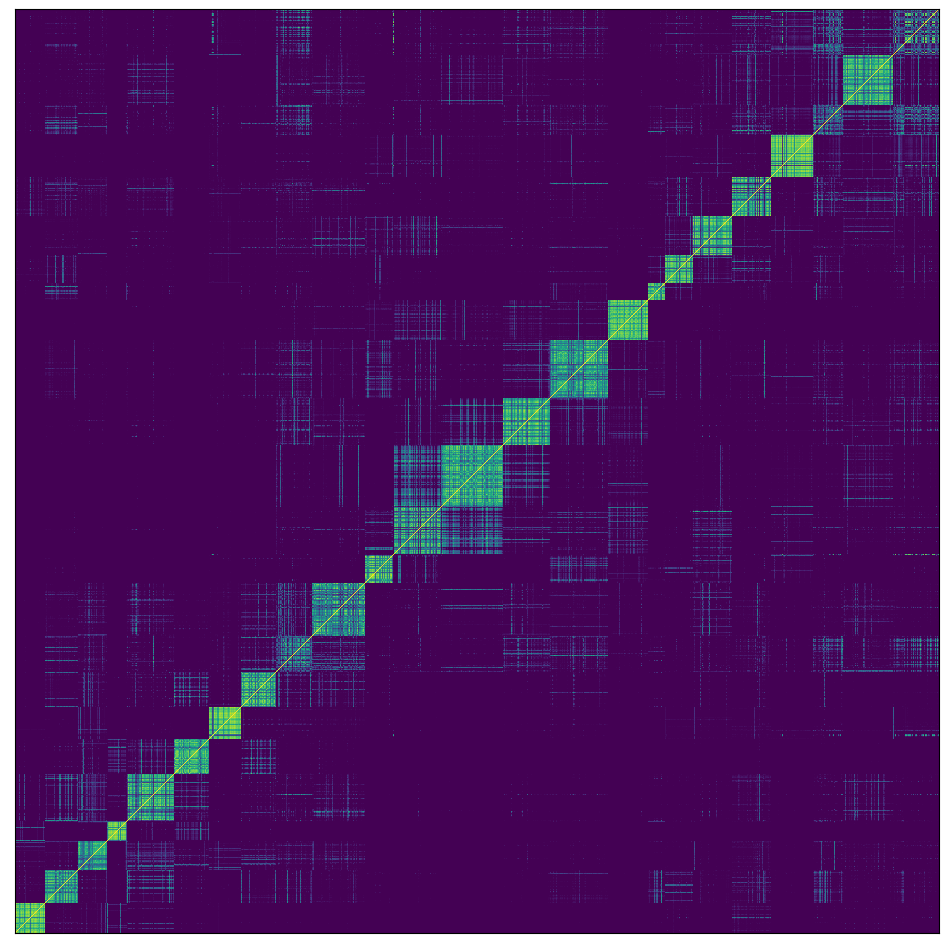

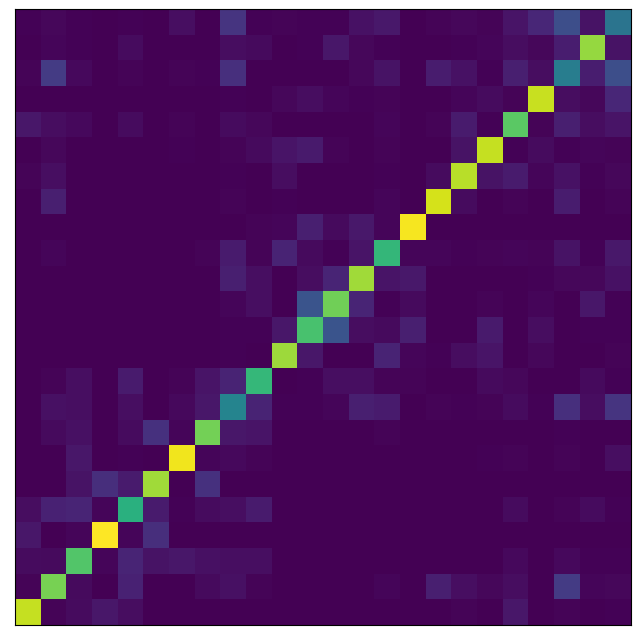

In [14]:
# MM: This takes some time to run, several minutes on M1 laptop
#%% subsampling to test the cluster stability
num_sub = 100
n_init = 1000
sub_perc = 0.9
load_sub_data = True
if load_sub_data:
    X_cluster_gmm_sub_2d = np.loadtxt(folder_path+'data/X_cluster_gmm_sub.csv',delimiter=',')
    X_cluster_gmm_sub = X_cluster_gmm_sub_2d.reshape(num_type,num_feature,num_sub)
    labels_gmm_sub = np.loadtxt(folder_path+'data/labels_gmm_sub.csv',delimiter=',')
    idx_sub = np.loadtxt(folder_path+'data/idx_sub.csv',delimiter=',')
    
else:
    X_cluster_gmm_sub,labels_gmm_sub,idx_sub = cal_sub_sampling(X,num_type,
                                                            sub_perc=sub_perc,num_sub=num_sub,n_init=n_init,random_init=False)

    np.savetxt(folder_path+'data/X_cluster_gmm_sub.csv', X_cluster_gmm_sub.reshape(num_type,-1), delimiter=',')
    np.savetxt(folder_path+'data/labels_gmm_sub.csv', labels_gmm_sub, delimiter=',')
    np.savetxt(folder_path+'data/idx_sub.csv', idx_sub, delimiter=',')

#%% calculate the co-association matrix
plot_co_association_matrix = True
if plot_co_association_matrix: 
    labels_gmm_sub_all = np.ones((num_neuron,num_sub),dtype=int)*np.nan
    idx_sub = idx_sub.astype(int)
    for i in range(num_sub):
        labels_gmm_sub_all[idx_sub[:,i],i] = labels_gmm_sub[:,i]
        
    load_co_mat = False
    if load_co_mat:
        co_mat_mean_sub = np.loadtxt(folder_path+'data/co_mat_mean_sub.csv',delimiter=',')
    else:
        # it takes ~4 min
        start = timeit.default_timer()
        co_mat_mean_sub = cal_co_mat_gmm(X,labels_gmm_sub_all)
        stop = timeit.default_timer()
        print(stop-start)
        # np.savetxt(folder_path+'data/co_mat_mean_sub.csv', co_mat_mean_sub, delimiter=',')
    # sort it with clusters
    co_mat_mean_sub_sorted_cluster,neuron_sorted_idx = sort_co_mat_cluster(X,labels_gmm_dendro,co_mat_mean_sub)
    
    # Figure 7C, related to Figure 2
    fig, axs = plt.subplots(1,1,figsize=[12,12])
    im = axs.pcolormesh(co_mat_mean_sub_sorted_cluster[::-1,::-1],cmap='viridis')
    # fig.colorbar(im,ax=axs)
    axs.set_aspect('equal', 'box')
    axs.set_xticks([])
    axs.set_yticks([])
    if save_fig:
        plt.savefig(folder_figure+'figure_7C.png',bbox_inches='tight')
    plt.show()
    
    # Figure 7D, related to Figure 2
    co_cluster_sub = cal_co_cluster(co_mat_mean_sub_sorted_cluster,cluster_size_gmm,plot_bool=False)
    _, axs = plt.subplots(1,1,figsize=(8,8))
    axs.pcolormesh(co_cluster_sub[::-1,::-1],cmap='viridis')
    axs.set_aspect('equal', 'box')
    axs.set_xticks([])
    axs.set_yticks([])
    if save_fig:
        plt.savefig(folder_figure+'figure_7D.png',bbox_inches='tight')
    plt.show()
    # np.savetxt(folder_data+'co_cluster_sub.csv', co_cluster_sub, delimiter=',')
else:
    co_cluster_sub = np.loadtxt(folder_data+'co_cluster_sub.csv',delimiter=',')
    _, axs = plt.subplots(1,1,figsize=(8,8))
    axs.pcolormesh(co_cluster_sub[::-1,::-1],cmap='viridis')
    axs.set_aspect('equal', 'box')
    axs.set_xticks([])
    axs.set_yticks([])
    if save_fig:
        plt.savefig(folder_figure+'figure_7D.png',bbox_inches='tight')
    plt.show()    
    

In [15]:
# %%calculate the correlation between clusters in original dataset
X_cluster_gmm_dendro_reverse = X_cluster_gmm_dendro[::-1,:]
corr_original, corr_original_full, corr_sub_match = cal_corr_sub(X_cluster_gmm_dendro,X_cluster_gmm_sub,num_sub=num_sub)
corr_original_full_reverse = corr_original_full[::-1,::-1]
corr_original_full_nan = np.copy(corr_original_full)
corr_original_full_nan[corr_original_full==1]=np.nan
corr_original_max = np.nanmax(corr_original_full_nan,axis=0)
corr_original_max_reverse = corr_original_max[::-1]
corr_sub_match_reverse = corr_sub_match[:,::-1]
corr_sub_match_median = np.median(corr_sub_match_reverse,axis=1) 
corr_sub_match_median_cluster = np.median(corr_sub_match_reverse,axis=0) 

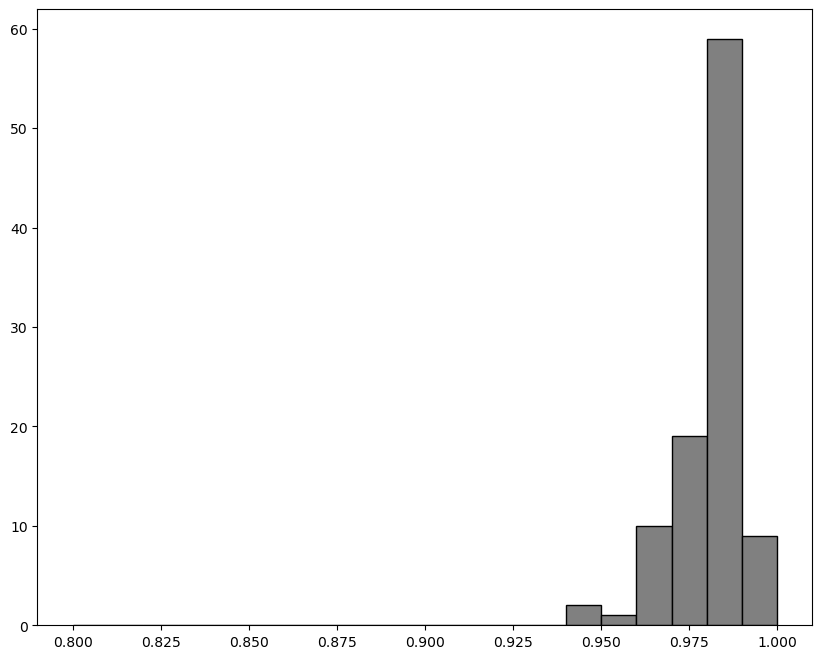

In [16]:
# Figure 7E, related to Figure 2
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(corr_sub_match_median.ravel(),bins=np.linspace(0.8,1,21),align='mid',color='grey',edgecolor='black') 
if save_fig:
    plt.savefig(folder_figure+'figure_7E.png',bbox_inches='tight')
plt.show()

In [17]:
idx_low_cc = np.where(corr_sub_match_median_cluster<np.nanmax(corr_original))[0]
corr_sub_match_mean_cluster = np.mean(corr_sub_match_reverse,axis=0) 
corr_sub_match_std_cluster = np.std(corr_sub_match_reverse,axis=0) 
corr_sub_match_sem_cluster = corr_sub_match_std_cluster/np.sqrt(num_sub)

#%% calculate the distance between clusters in original dataset
dist_original_full, dist_original_full_nan, dist_sub_match = cal_dist_sub(X_cluster_gmm_dendro,X_cluster_gmm_sub,num_sub=num_sub)
dist_original_min = np.nanmin(dist_original_full_nan,axis=0)
dist_original_min_reverse = dist_original_min[::-1]
dist_original_full_reverse = dist_original_full[::-1,::-1]
dist_sub_match_reverse =  dist_sub_match[:,::-1]
dist_sub_match_median = np.median(dist_sub_match_reverse,axis=1) 
dist_sub_match_median_cluster = np.median(dist_sub_match_reverse,axis=0) 

idx_long_dist = num_type-np.where(dist_sub_match_median_cluster<np.nanmax(dist_original_full_nan))[0][::-1]
dist_sub_match_mean_cluster = np.mean(dist_sub_match_reverse,axis=0) 
dist_sub_match_std_cluster = np.std(dist_sub_match_reverse,axis=0) 
dist_sub_match_sem_cluster = dist_sub_match_std_cluster/np.sqrt(num_sub)

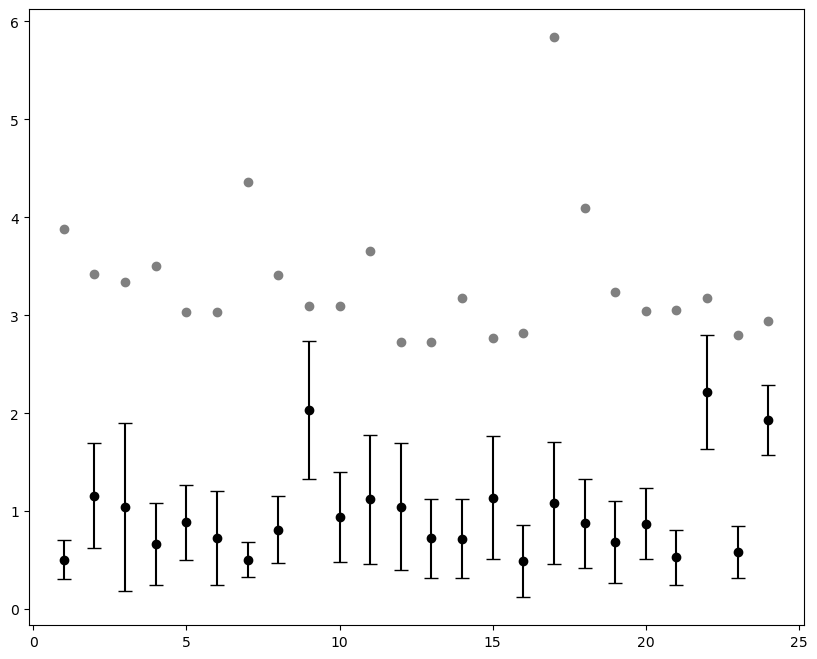

In [18]:
# Figure 7F, related to Figure 2
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.errorbar(np.array(range(1,25)),dist_sub_match_mean_cluster,yerr=dist_sub_match_std_cluster,
             color='black',marker='o',capsize=5,ls='none')
ax.plot(np.array(range(1,25)),dist_original_min_reverse,'o',color='gray')
if save_fig:
    plt.savefig(folder_figure+'figure_7F.png',bbox_inches='tight')
plt.show()

In [19]:
#%% calculate the jaccard similarity
load_jaccard=True
if load_jaccard:
    jaccard_sub_match = np.loadtxt(folder_path+'data/jaccard_sub_match.csv',delimiter=',')
else:
    jaccard_sub_match = cal_jaccard_sub(labels_gmm_dendro,labels_gmm_sub,idx_sub,num_sub=num_sub)
    np.savetxt(folder_path+'data/jaccard_sub_match.csv', jaccard_sub_match, delimiter=',')
jaccard_sub_match_reverse = jaccard_sub_match[:,::-1]

jaccard_sub_match_mean_cluster = np.mean(jaccard_sub_match_reverse,axis=0) 
jaccard_sub_match_std_cluster = np.std(jaccard_sub_match_reverse,axis=0) 
jaccard_sub_match_sem_cluster = jaccard_sub_match_std_cluster/np.sqrt(num_sub)

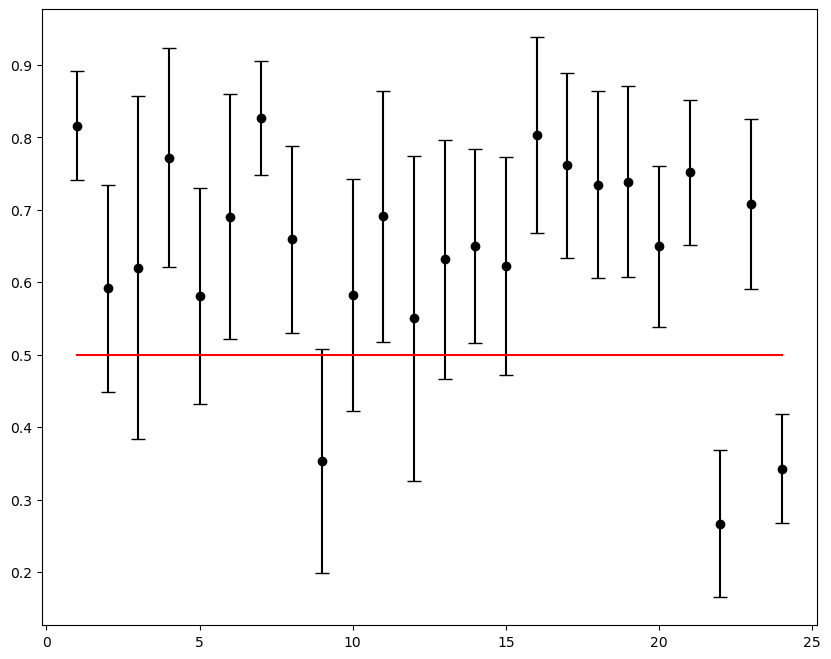

In [20]:
# Figure 2D
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.errorbar(np.array(range(1,25)),jaccard_sub_match_mean_cluster,yerr=jaccard_sub_match_std_cluster,
             color='black',marker='o',capsize=5,ls='none')
ax.plot(np.array(range(1,25)),np.ones(num_type)*0.5,'r')
if save_fig:
    plt.savefig(folder_figure+'figure_2D.png',bbox_inches='tight')
plt.show()

In [21]:
#%% merge clusters with jaccard<0.5
jaccard_thr = 0.5
merge_thr = 0.35 
cluster_unstable = np.where(jaccard_sub_match_mean_cluster[::-1]<jaccard_thr)[0] #this is ordered

# merge the clusters with the shortest distance
labels_gmm_merged = np.copy(labels_gmm_dendro)
for i in cluster_unstable:
    if np.sort(co_cluster_sub[i,:])[-2]>merge_thr:
        i_merge = np.argsort(co_cluster_sub[i,:])[-2]
        labels_gmm_merged[labels_gmm_merged==i] = i_merge
labels_gmm_merged_unique = np.unique(labels_gmm_merged)
n_cluster_merged = labels_gmm_merged_unique.shape[0]

#%% merge clusters if meet condition
if n_cluster_merged<num_type:
    labels_gmm_merged_reindexed = np.zeros_like(labels_gmm_merged)
    for i, label in enumerate(labels_gmm_merged_unique):
        labels_gmm_merged_reindexed[labels_gmm_merged==label] = i
    labels_gmm_merged_reindexed_unique = np.unique(labels_gmm_merged_reindexed)
    # verify 
    for i in range(n_cluster_merged):
        print(np.sum(labels_gmm_merged==labels_gmm_merged_unique[i])==
              np.sum(labels_gmm_merged_reindexed==i))
        
    file_save_neurons_labels_merged = folder_figure + 'neurons_labels_merged' 
    X_cluster_gmm_merged,_,_,_ = plot_cluster(X,labels_gmm_merged_reindexed,file_save_neurons_labels_merged,sampling_rate=1)
    file_save_neurons_temporal_labels_merged = folder_figure + 'neurons_temporal_labels_merged' 
    X_temporal_cluster_gmm_merged,_,_,_ = plot_cluster(X_temporal,labels_gmm_merged_reindexed,
                                                 file_save_neurons_temporal_labels_merged)
    # re-do the dendrogram
    file_save_temporal_merged_dendro = folder_figure + 'temporal_merged_dendro'
    idx_sorted_merged, labels_gmm_merged_dendro, cluster_size_gmm_merged = dendrogram_x(X_cluster_gmm_merged, 
                                                        X_temporal_cluster_gmm_merged, labels_gmm_merged_reindexed, 
                                                        fig_params_dendro, file_save_temporal_merged_dendro, fig_zoom=2.5) 
    
    
    X_cluster_gmm_merged_dendro,_,_,_ = plot_cluster(X,labels_gmm_merged_dendro,[],sampling_rate=1)
    cluster_dist_gmm_merged_sorted = plot_cluster_dist(X_cluster_gmm_merged_dendro)
    cluster_dist_gmm_merged_sorted_reversed = cluster_dist_gmm_merged_sorted[::-1,::-1]
    cluster_dist_gmm_merged_sorted_reversed_nan = np.copy(cluster_dist_gmm_merged_sorted_reversed)
    cluster_dist_gmm_merged_sorted_reversed_nan[cluster_dist_gmm_merged_sorted_reversed==0] = np.nan
    cluster_dist_gmm_merged_sorted_reversed_min = np.nanmin(cluster_dist_gmm_merged_sorted_reversed_nan,axis=0)
    
    file_save_neurons_temporal_labels_merged_dendro = folder_figure + 'neurons_temporal_labels_merged_dendro'   
    X_temporal_cluster_gmm_dendro,_,_,_ = plot_cluster(X_temporal,labels_gmm_dendro,file_save_neurons_temporal_labels_dendro)

In [22]:
#%% construct a dataframe that contains all information, including rf_size, gdsi, gosi, hi, lsi,  st_pref_size, st_si for genetcially labeled neurons
df_results = pd.DataFrame()
df_results['depth'] = neuron['soma_depth']
df_results['image_id'] = neuron['image_id']
df_results['mouse_id'] = neuron['mouse_id']
df_results['soma_pos_x'] = neuron['soma_pos'][:,0]
df_results['soma_pos_y'] = neuron['soma_pos'][:,1]

df_results['gdsi'] = mb['mb_gdsi']
df_results['gosi'] = mb['mb_gosi']
df_results['gdsi_svd'] = mb['mb_gdsi_svd']
df_results['gosi_svd'] = mb['mb_gosi_svd']
df_results['msi'] = mb['msi']
df_results['mb_resp_amp'] = mb['mb_resp_amp']

df_results['dl_hi'] = dl_lr['dl_hi']
df_results['lsi'] = dl_lr['lsi']

df_results['fpr'] = chirp['fpr']
df_results['on_resp_amp'] = chirp['on_resp_amp']
df_results['off_resp_amp'] = chirp['off_resp_amp']
df_results['freq_si'] = chirp['freq_si']
df_results['amp_si'] = chirp['amp_si']
df_results['after_freq_mod_resp_amp'] = chirp['after_freq_mod_resp_amp']
df_results['after_amp_mod_resp_amp'] = chirp['after_amp_mod_resp_amp']

df_results['best_size'] = st['best_size']
df_results['st_cv'] = st['st_cv']
df_results['ssi'] = st['ssi']

df_results['bgi'] = color['color_bgi']

df_results['rf_size'] = rf['rf_size']
df_results['rf_size_log10'] = np.log10(df_results['rf_size'])
df_results['on_off_si'] = rf['rf_on_off_si']
df_results['rf_azimuth'] = rf['azimuth_rf_flash']
df_results['rf_elevation'] = rf['elevation_rf_flash']

df_results['cluster_label_num'] = labels_gmm
df_results['cluster_label_dendro_num'] = labels_gmm_dendro

#%%
mouse_id_unique = np.unique(neuron['mouse_id'])
num_animal = mouse_id_unique.size
mice_type_mat = np.zeros((num_type,num_animal))
for i in range(num_type):
    _n_type_i = np.sum(df_results['cluster_label_dendro_num']==i)
    for j in range(num_animal):
        mice_type_mat[i,j] = np.sum(np.logical_and(df_results['cluster_label_dendro_num']==i,df_results['mouse_id']==mouse_id_unique[j]))/_n_type_i
mice_type_mat_rev = mice_type_mat[::-1,:]

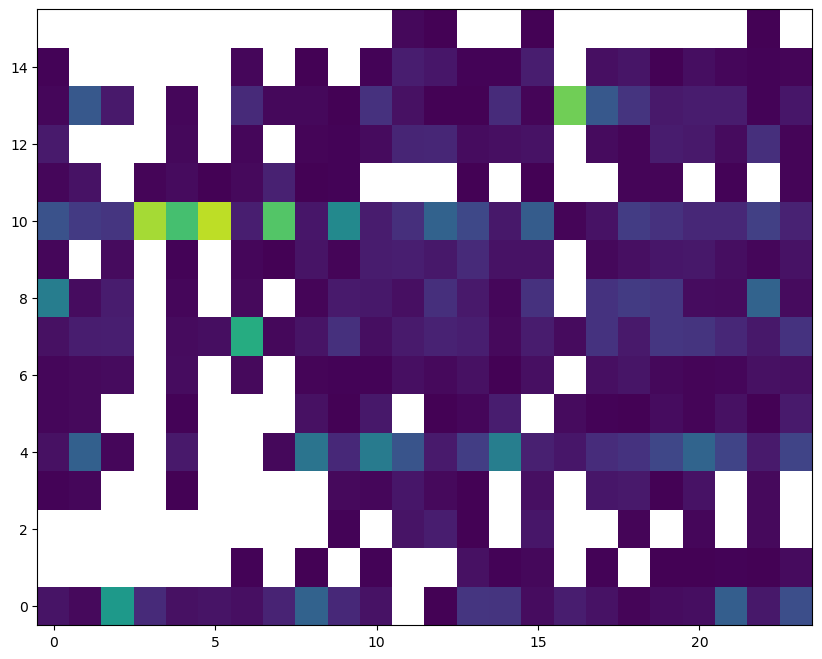

In [23]:
#Figure 7G, related to Figure 2
fig,ax = plt.subplots(1,1,figsize=(10,8))
#cmap = matplotlib.colormaps.get_cmap("viridis").copy() #this is for newer versions
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad(color='white',alpha=1)
mice_type_mat_rev_masked = np.ma.masked_where(mice_type_mat_rev==0,mice_type_mat_rev)
ax.imshow(mice_type_mat_rev_masked.T,cmap=cmap,interpolation='nearest',aspect='auto',origin='lower',vmax=1,vmin=0)   
if save_fig:
    plt.savefig(folder_figure+'figure_7G.png',bbox_inches='tight')   
plt.show()

In [24]:
#%%plot cell types versus functional properties 
si_list = ['mb_resp_amp',  'gdsi', 'gosi', 'dl_hi', 'lsi', 
           'msi', 'on_off_si','fpr','freq_si', 'after_freq_mod_resp_amp', 
           'after_amp_mod_resp_amp', 'best_size', 'ssi', 'bgi','rf_size_log10']
ref_list = [0, 0.15, 0.15, 0,  0,   
            0, 0, 0.5,  0,   0,       
            0, 3, 0, 0, 2.46]
si_n = len(si_list)
p_thr_fun = 0.05
si_cluster, p_cluster, corr_fp, corr_p_fp = si_corr(df_results,si_list,labels_gmm_dendro,ref_list=ref_list)
si_cluster_reverse = si_cluster[:,::-1].T

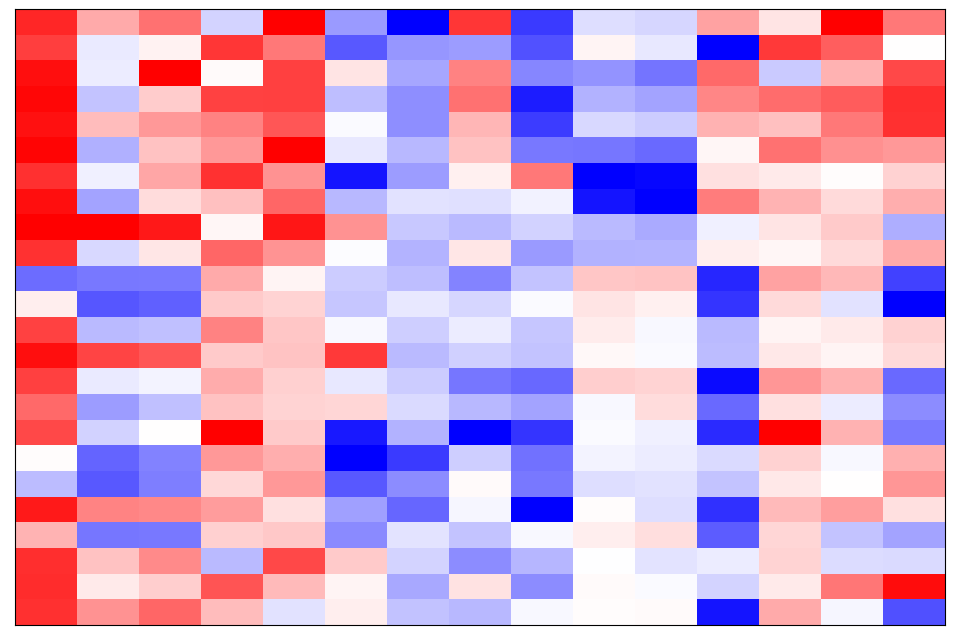

In [25]:
# Figure 10A, related to Figure 3
si_cluster_reverse_norm = norm_x(si_cluster_reverse.T,formula=1).T 
_, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(si_cluster_reverse_norm,cmap='bwr',aspect='auto')
ax.set_xticks([])
ax.set_yticks([])
if save_fig:
    plt.savefig(folder_figure+'figure_10A.png',bbox_inches='tight')  
plt.show() 

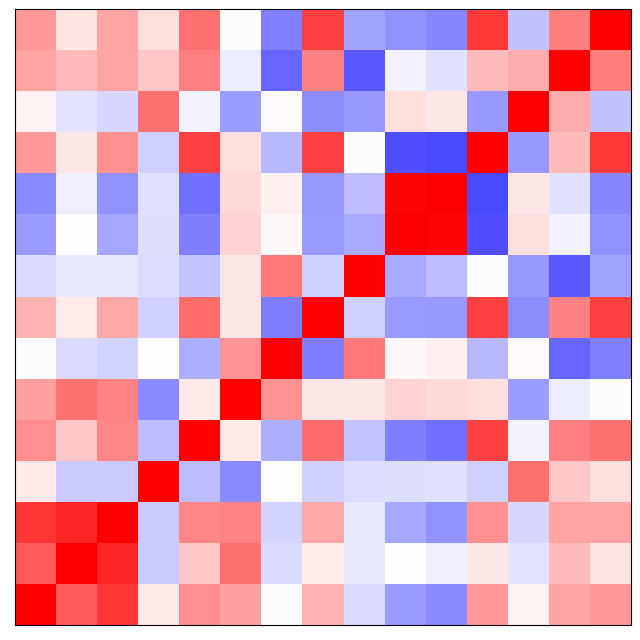

In [26]:
# Figure 10B, related to Figure 3
_, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(corr_fp,cmap='bwr',aspect='equal',origin='lower',vmin=-1,vmax=1)
ax.set_xticks([])
ax.set_yticks([])
if save_fig:
    plt.savefig(folder_figure+'figure_10B.png',bbox_inches='tight')  
plt.show() 

In [27]:
p_cluster_reverse = p_cluster[:,::-1].T
si_cluster_reverse_sig = si_cluster_reverse*(p_cluster_reverse<p_thr_fun)
si_cluster_reverse_sig_norm = norm_x(si_cluster_reverse_sig.T,formula=1).T 
si_cluster_reverse_sig_norm[p_cluster_reverse>=p_thr_fun] = np.nan

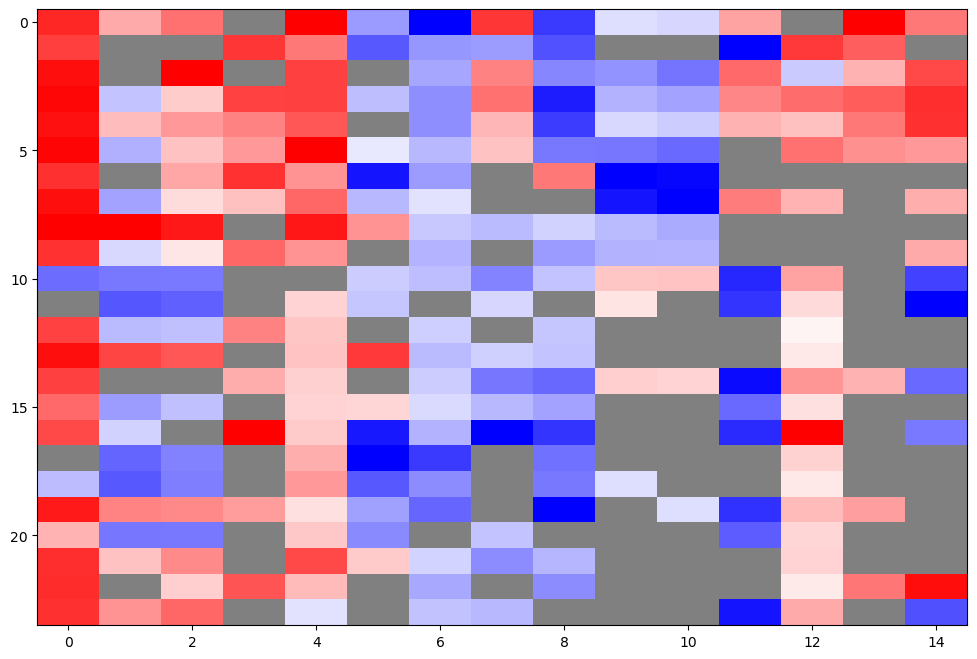

In [28]:
# Figure 3B
fig,ax = plt.subplots(1,1,figsize=(12,8))
#cmap = matplotlib.colormaps.get_cmap("bwr").copy() #this is for newer versions
cmap = plt.cm.get_cmap("bwr").copy()
cmap.set_bad(color='grey',alpha=1)
norm = colors.TwoSlopeNorm(vcenter=0)
si_cluster_reverse_sig_norm_masked = np.ma.masked_where(np.isnan(si_cluster_reverse_sig_norm),si_cluster_reverse_sig_norm)
ax.imshow(si_cluster_reverse_sig_norm_masked,cmap=cmap,norm=norm,interpolation='nearest',origin='upper',aspect='auto')
if save_fig:
    plt.savefig(folder_figure+'figure_3B.png',bbox_inches='tight')  
plt.show()

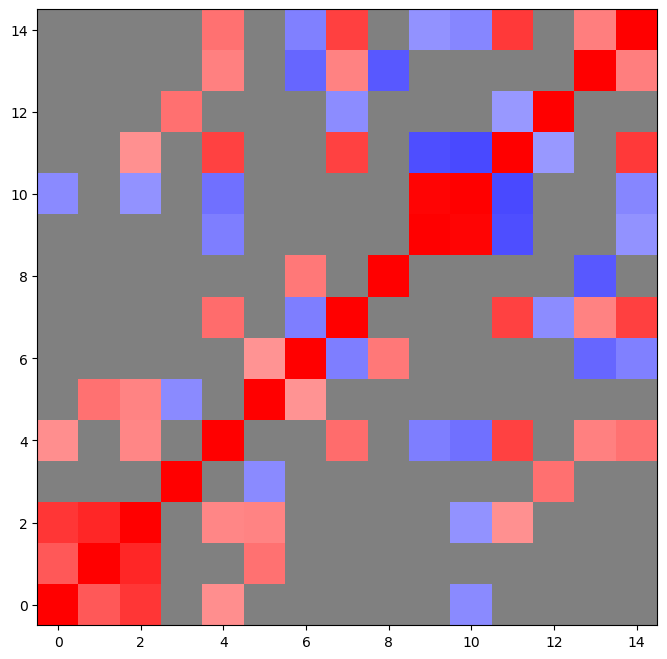

In [29]:
# Figure 3C
corr_fp_sig = np.copy(corr_fp)
corr_fp_sig[corr_p_fp>=p_thr_fun] = np.nan
corr_fp_sig_masked = np.ma.masked_where(np.isnan(corr_fp_sig),corr_fp_sig)
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(corr_fp_sig_masked,cmap=cmap,norm=norm,interpolation='nearest',origin='lower',aspect='auto')
if save_fig:
    plt.savefig(folder_figure+'figure_3C.png',bbox_inches='tight')  
plt.show()    
#%% plot the percentage of neurons with flashing-mapped RFs for each cluster
rf_perc_fac = np.ones(num_type)*np.nan
rf_size_fac = np.ones((num_type,2))*np.nan
for i in range(num_type):    
    temp = rf['rf_size'][df_results['cluster_label_dendro_num']==num_type-i-1]
    rf_perc_fac[i] = (temp.size - np.sum(np.isnan(temp))) / temp.size*100
    temp_1 = temp[np.logical_not(np.isnan(temp))]
    rf_size_fac[i,:] = [np.mean(temp_1),np.std(temp_1)/np.sqrt(len(temp_1))]

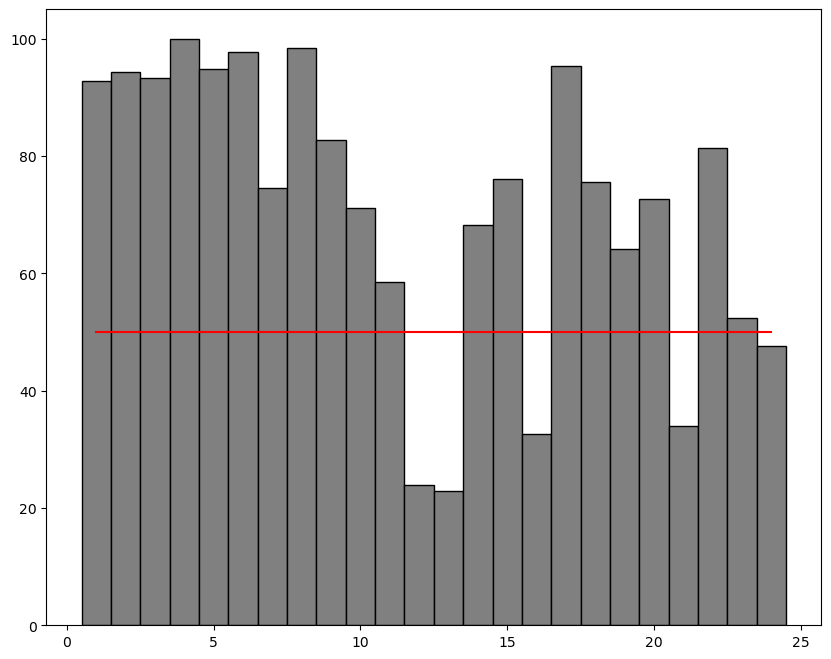

In [30]:
# Figure 10C, related to Figure 3
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.bar(np.asarray(range(num_type))+1,rf_perc_fac,color='grey',edgecolor='black',width=1)   
ax.plot(np.asarray(range(num_type))+1,np.ones(num_type)*50,'r')
if save_fig:
    plt.savefig(folder_figure+'figure_10C.png',bbox_inches='tight')   
plt.show()
   

In [31]:
#%% load info about mouse strains
genetic_label = neuron['genetic_id']
genetic_name = ['All types','Vglut2+','Vgat+','Tac1+','Rorb+', 'Ntsr1+']
genetic_num = len(genetic_name)
genetic_label_text = [str(x) for x in genetic_label]
genetic_label_text = [label.replace('0.0', genetic_name[0]) for label in genetic_label_text]
genetic_label_text = [label.replace('1.0', genetic_name[1]) for label in genetic_label_text]
genetic_label_text = [label.replace('2.0', genetic_name[2]) for label in genetic_label_text]
genetic_label_text = [label.replace('3.0', genetic_name[3]) for label in genetic_label_text]
genetic_label_text = [label.replace('4.0', genetic_name[4]) for label in genetic_label_text]
genetic_label_text = [label.replace('5.0', genetic_name[5]) for label in genetic_label_text]

df_results['genetic_label'] = genetic_label_text
df_results['genetic_label_num'] = genetic_label

#%% set parameters for plotting Figures
_,chirp_len = chirp['chirp_temporal_norm'].shape
_,mb_len = mb['mb_temporal_sorted_truncated_norm'].shape
_,dl_lr_len = dl_lr['dl_lr_temporal_sorted_truncated_norm'].shape
_,color_len = color['color_temporal_norm'].shape
_,st_len = st['st_temporal_norm'].shape

temporal_len_list = [mb_len, dl_lr_len, chirp_len, st_len, color_len]

temporal_list = temporal_list_generate(X_temporal_cluster_gmm, X_temporal_cluster_gmm_error, temporal_len_list)

temporal_zooms = [0.6, 0.6, 0.6, 0.3, 0.3, 0.3]


columns_label =['msi','gdsi','gosi','dl_hi','lsi','on_off_si','best_size','ssi','bgi','rf_size']
columns_name = ['MSI','DSI', 'OSI', 'HI', 'LSI', 'CSI','BSS', 'SSI','BGI','RFS']
bins_num = 20+1
bins_rf_size = np.linspace(0,round_up(np.max(df_results['rf_size']),-1),bins_num)
bins_rf_size_log10 = np.logspace(1,round_up(np.log10(np.max(df_results['rf_size'])),1),bins_num)
bins_msi = np.linspace(-1, 1, bins_num)
bins_gdsi = np.linspace(round_down(np.min(df_results['gdsi']),1), round_up(np.max(df_results['gdsi']),1), bins_num)
bins_gosi = np.linspace(round_down(np.min(df_results['gosi']),1), round_up(np.max(df_results['gosi']),1), bins_num)
bins_dl_hi = np.linspace(-1, 1, bins_num)
bins_lsi = np.linspace(-1, 1, bins_num)
bins_csi = np.linspace(-1, 1, bins_num)
bins_st = np.linspace(round_down(np.min(df_results['st_cv']),1), round_up(np.max(df_results['st_cv']),1), bins_num)
bins_best_size = np.linspace(1,6,6)
bins_ssi = np.linspace(round_down(np.min(df_results['ssi']),1), round_up(np.max(df_results['ssi']),1), bins_num)
bins_bgi = np.linspace(-1, 1, bins_num)
bins_list = [bins_msi, bins_gdsi, bins_gosi,bins_dl_hi, bins_lsi, bins_csi, bins_best_size, bins_ssi, bins_bgi,bins_rf_size_log10] 

box_flag = ['best_size']

hist_list = columns_label.copy()

fig_params = {'space_sub': 1, # arbituray unit
              'height_sub': 10, # arbituray unit
              'width_sub_hist': 16, # arbituray unit
              'margin': 0, # relative in [0,1], margin is not useful
              'dendro_width': 0.1,
              'zoom': 2.5,
              'dendro_text_pos': -0.2,
              'offset': 0.04
              }

columns_name_dendro = list.copy(columns_name)

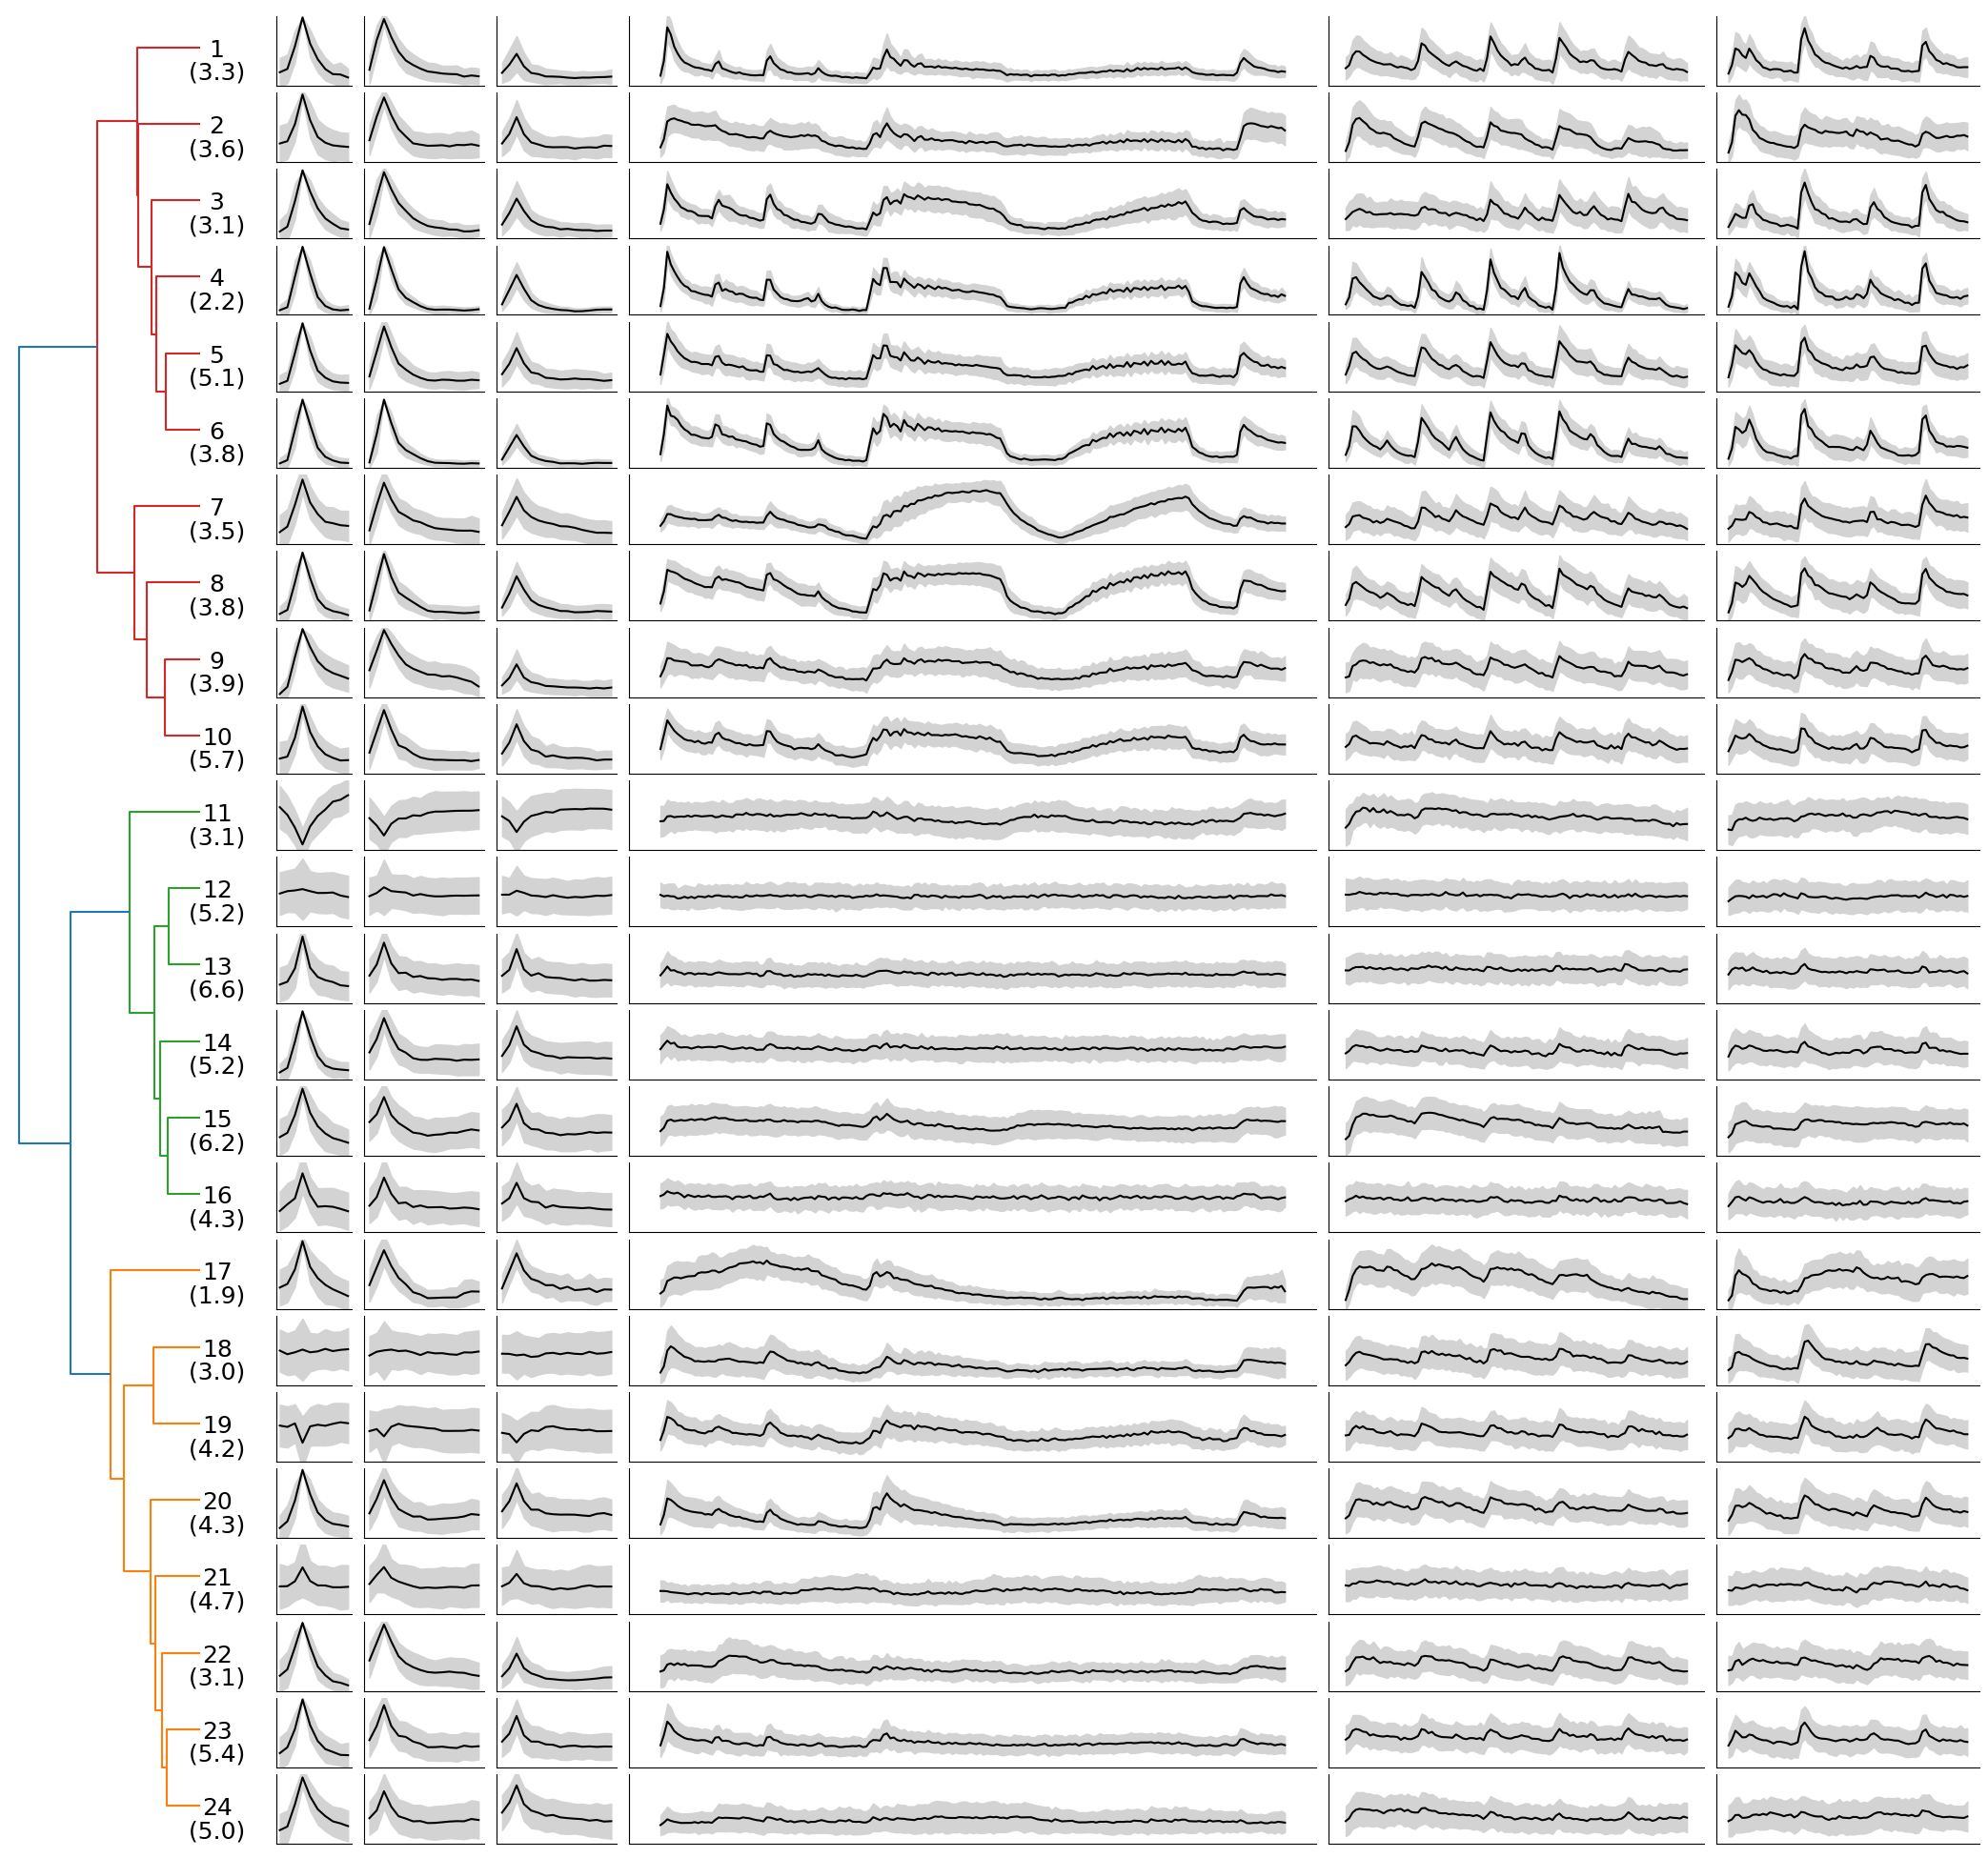

In [32]:
#%% Figure 2A: temporal plot with error
file_save_cluster_dendro_temporal= folder_figure + 'figure_2A'
data_box_all, data_box_clusters,_ = figure_cluster_temporal_box(df_results, 'cluster_label_dendro_num', X_cluster_gmm, cluster_size_gmm, 
                                 temporal_list, [], temporal_zooms,
                                 columns_name.copy(), bins_list,
                                 file_save_cluster_dendro_temporal, fig_params, 
                                 fac=True, genetic_comp=False, sampling_rate=5, violin=True, norm_flag=False, error=True)

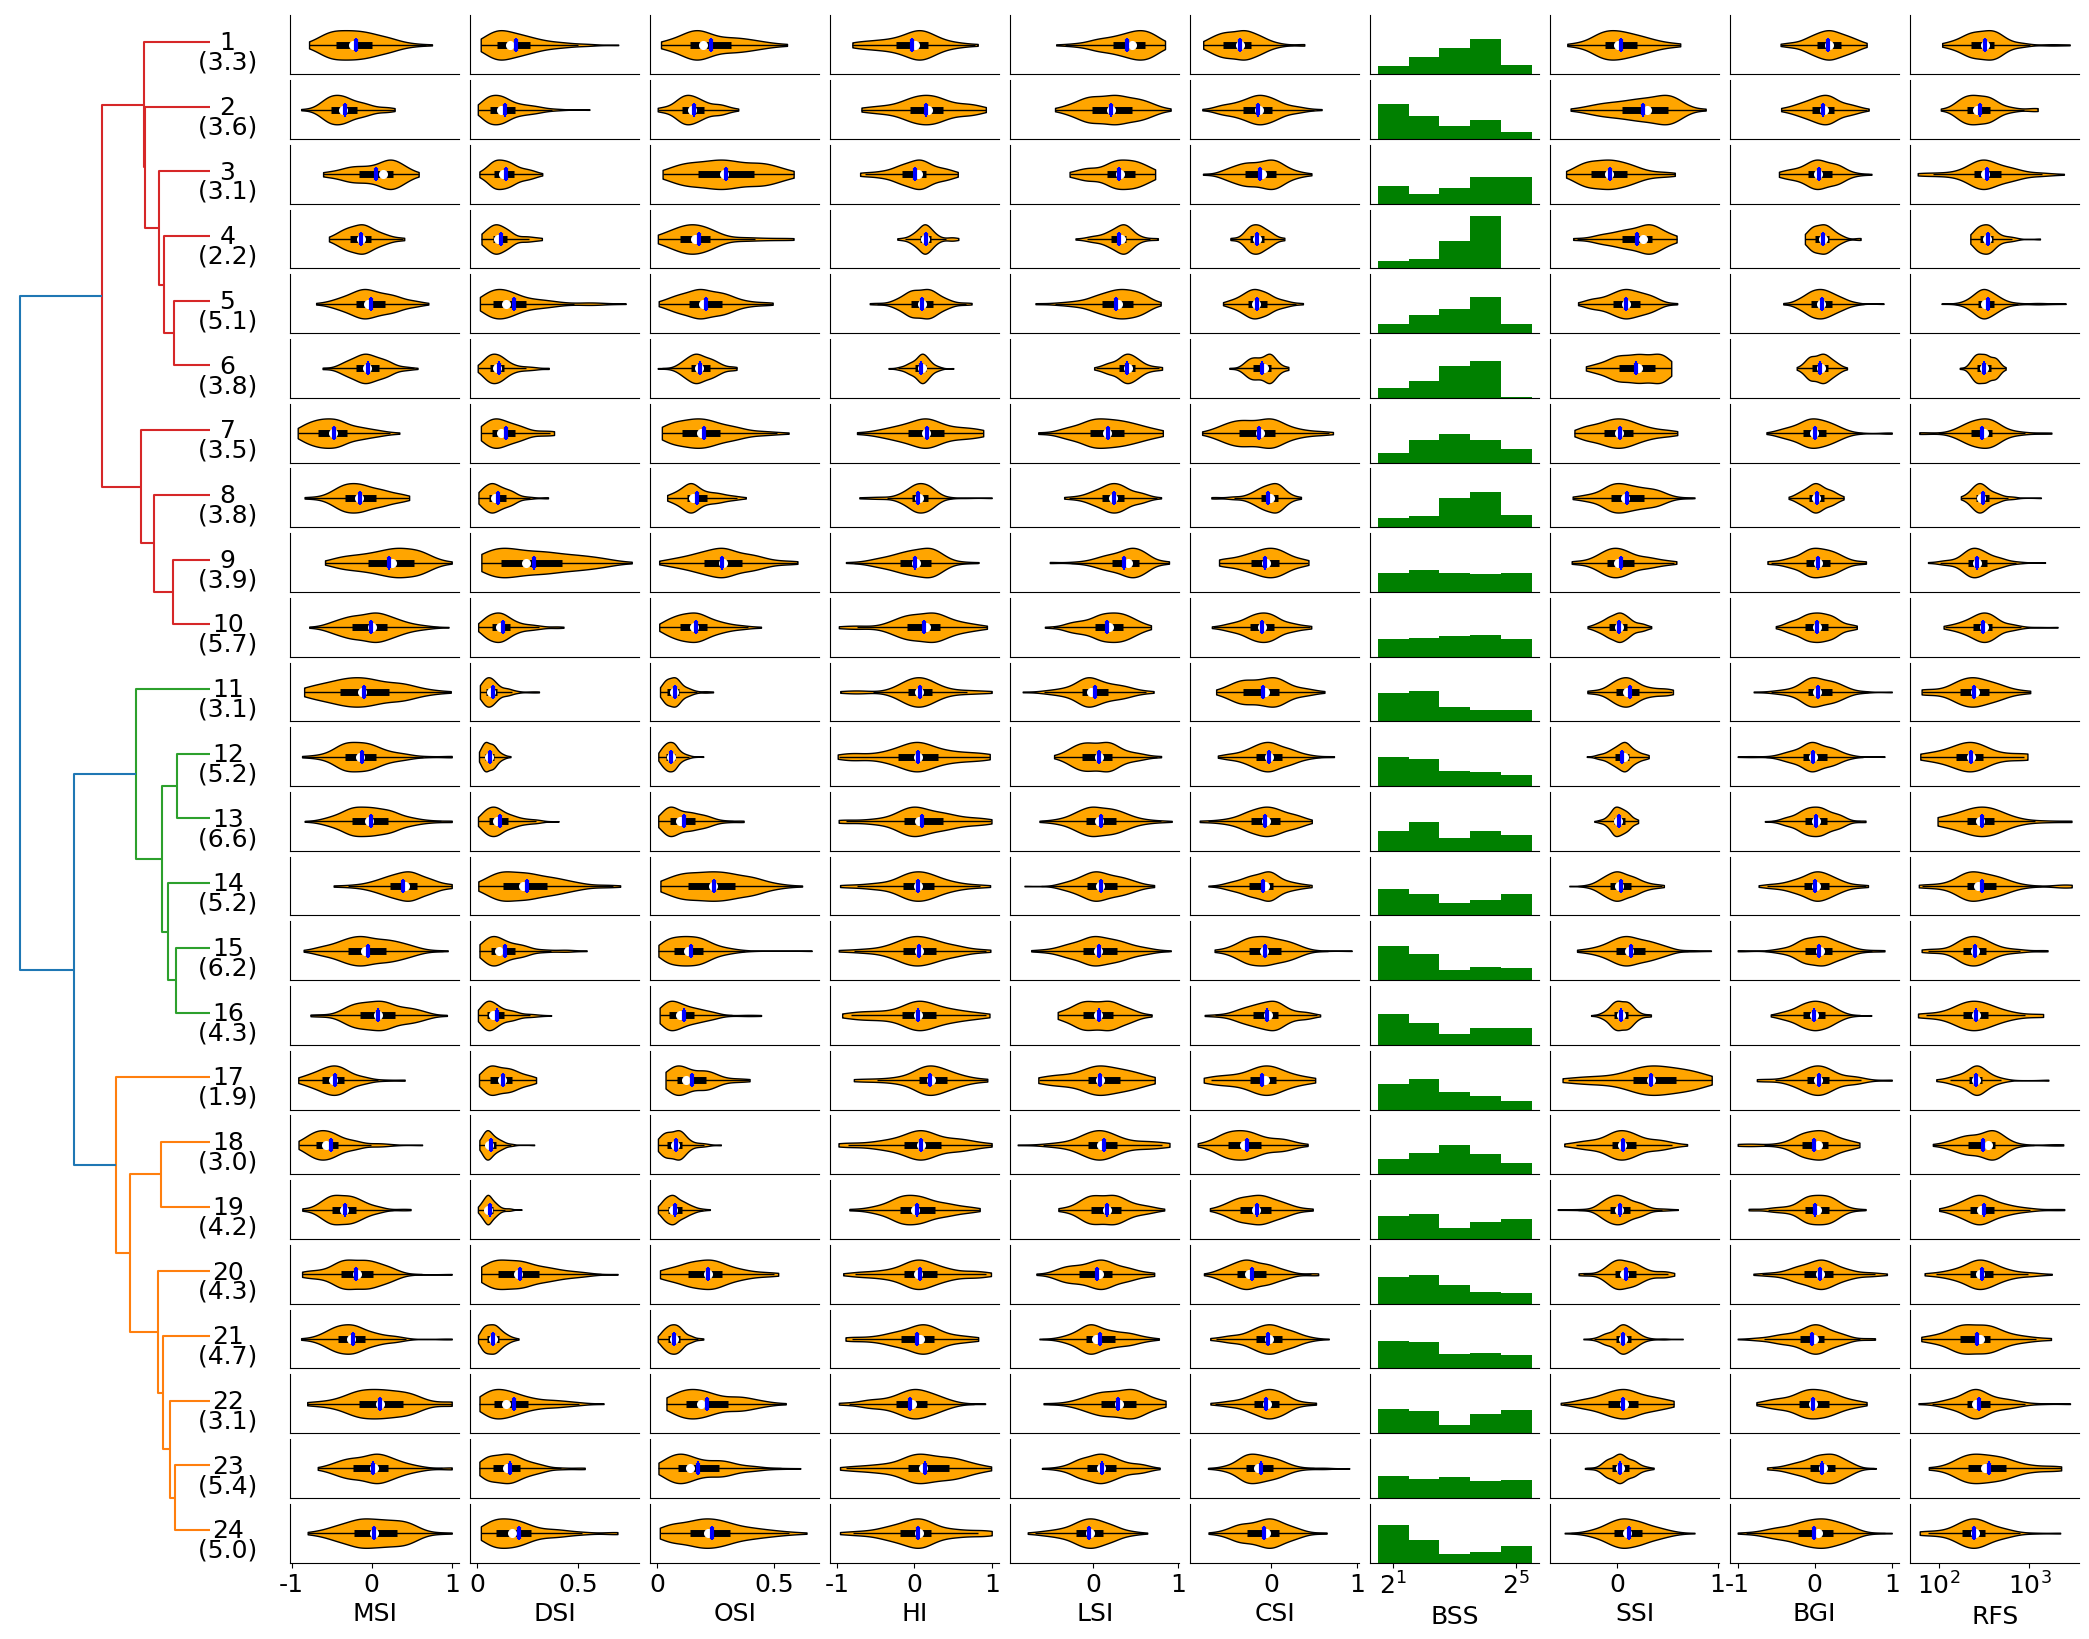

In [33]:
#%% Figure 3A: violin plot
file_save_cluster_dendro_violin= folder_figure + 'figure_3A'
data_box_all, data_box_clusters,_ = figure_cluster_temporal_box(df_results, 'cluster_label_dendro_num', X_cluster_gmm, cluster_size_gmm, 
                                 [], columns_label, temporal_zooms,
                                 columns_name.copy(), bins_list,
                                 file_save_cluster_dendro_violin, fig_params, 
                                 fac=True, genetic_comp=False, sampling_rate=5, violin=True, norm_flag=False, error=False,box_flag=box_flag)

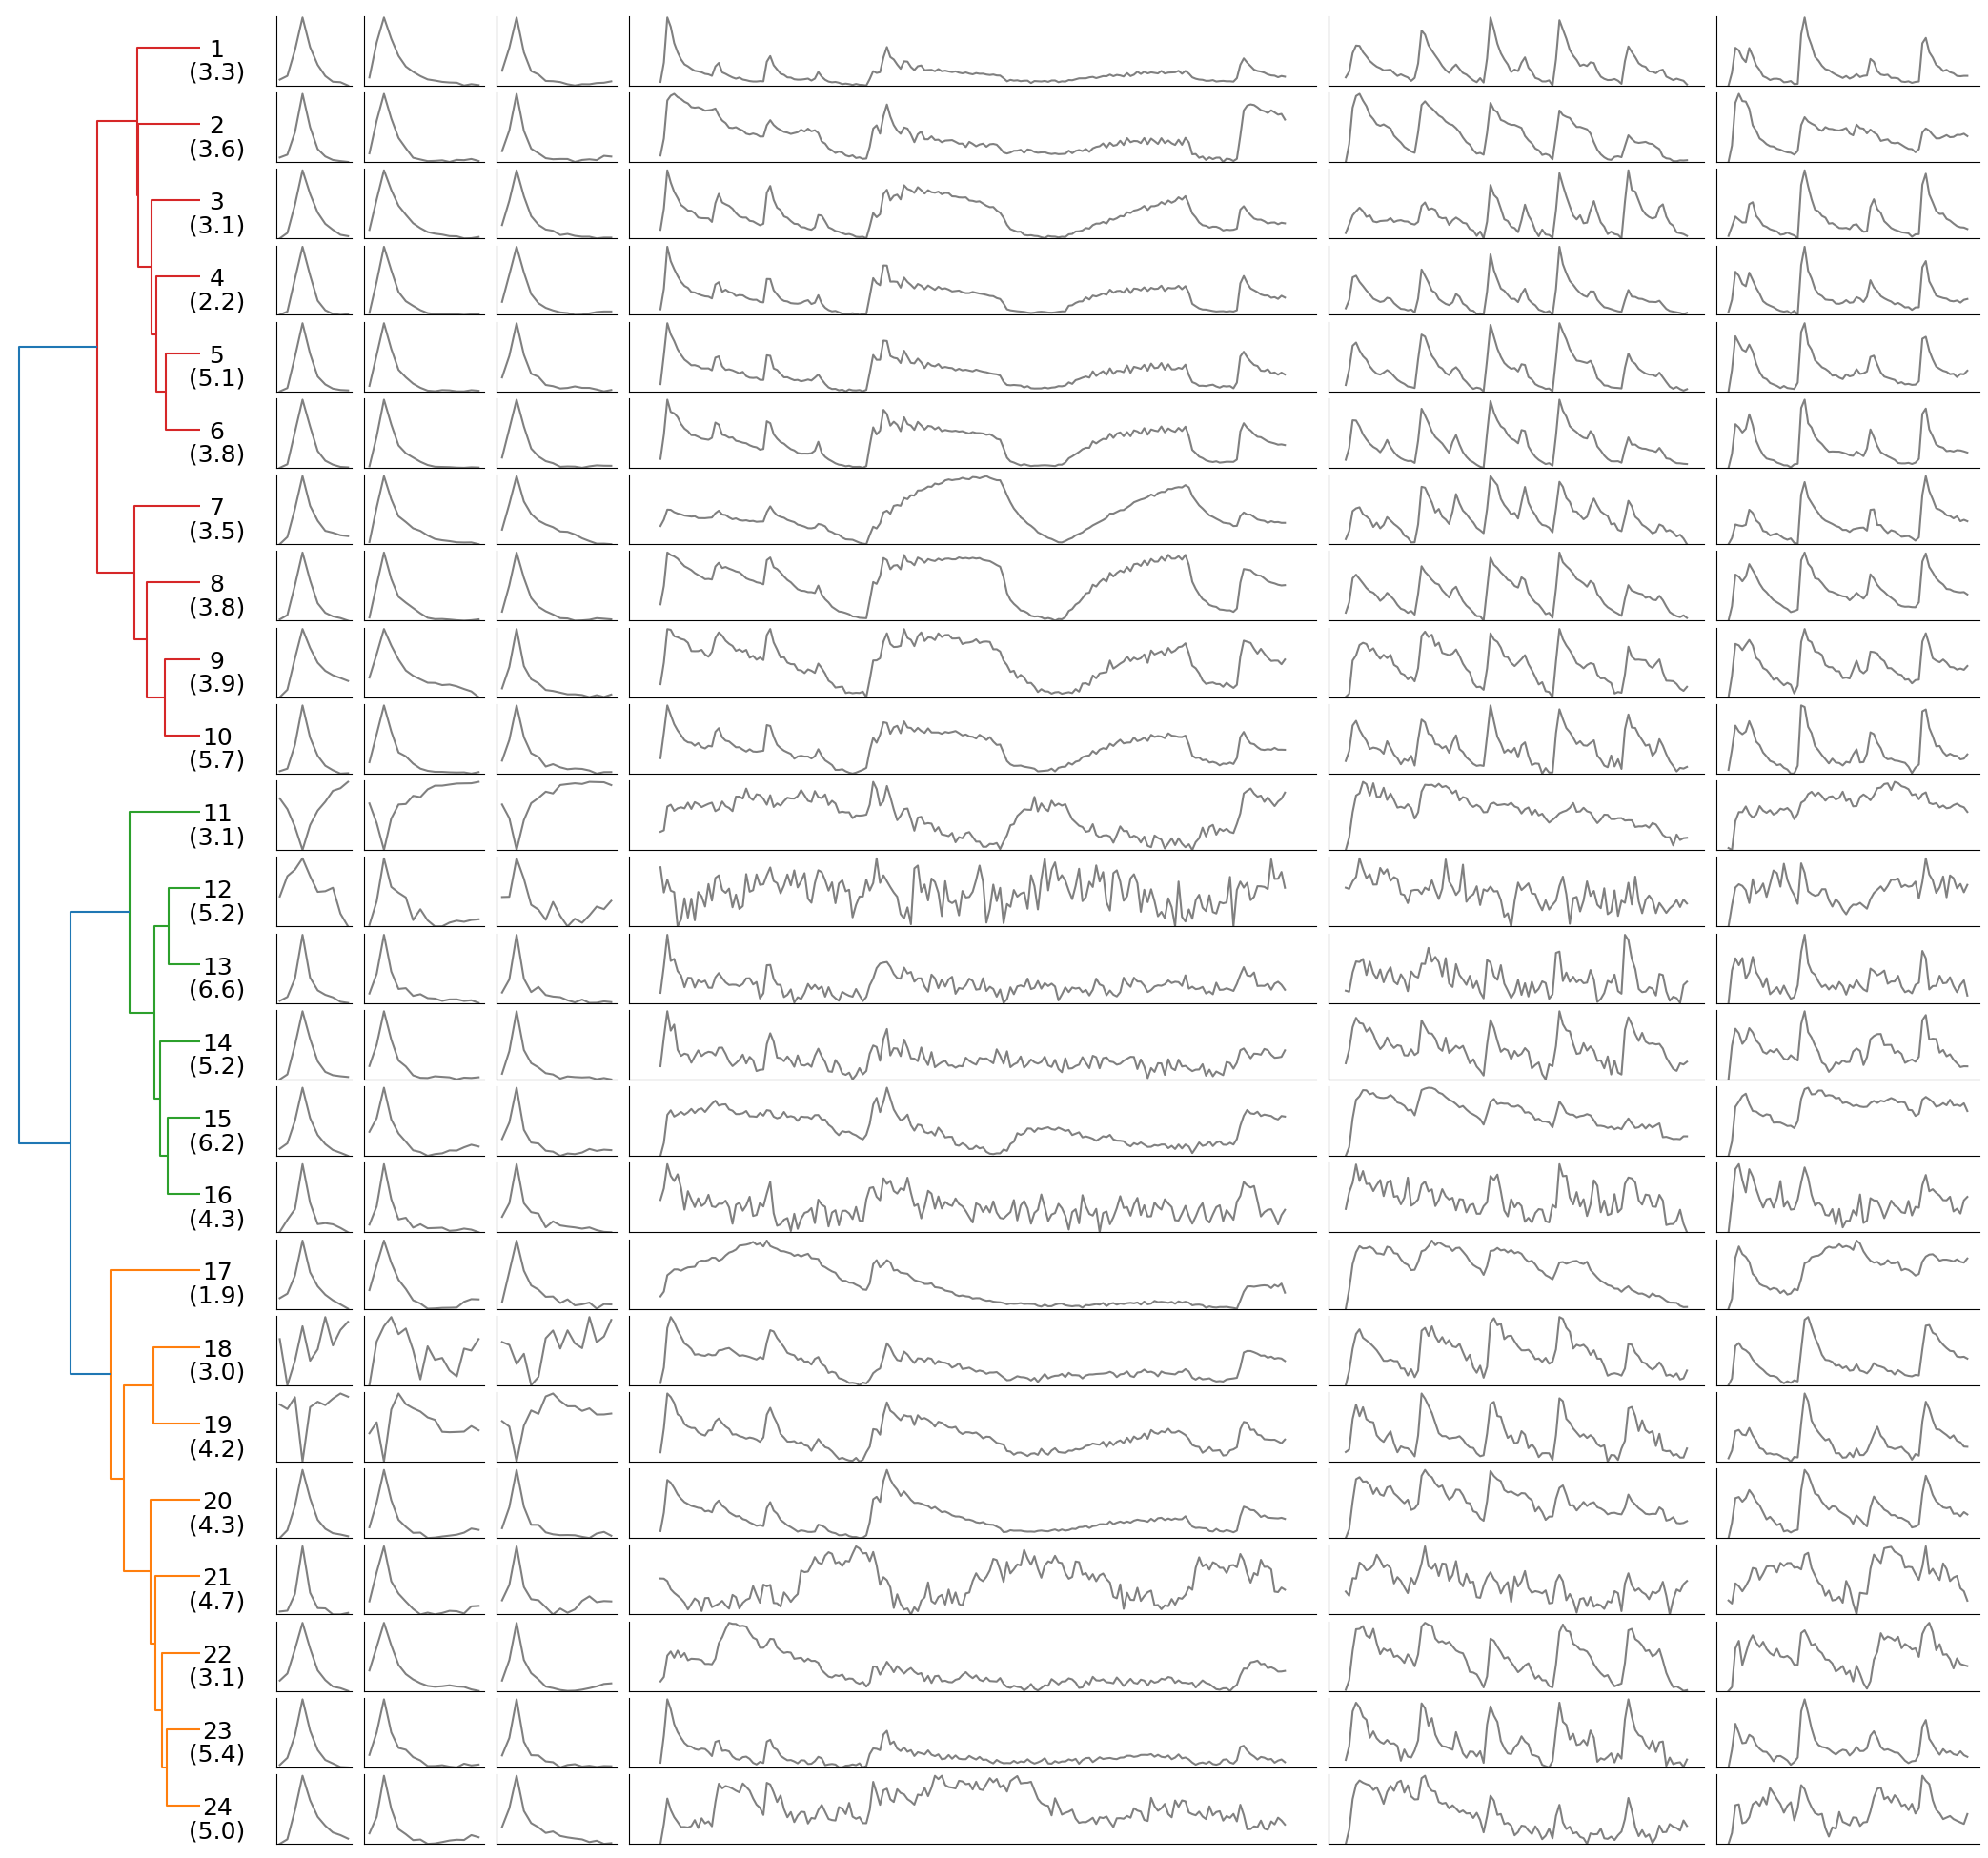

In [34]:
#%% Figure 8, related to Figure 2: normalized temporal plot with error
file_save_cluster_dendro_temporal= folder_figure + 'figure_8'
data_box_all, data_box_clusters,_ = figure_cluster_temporal_box(df_results, 'cluster_label_dendro_num', X_cluster_gmm, cluster_size_gmm, 
                                 temporal_list, [], temporal_zooms,
                                 columns_name.copy(), bins_list,
                                 file_save_cluster_dendro_temporal, fig_params, 
                                 fac=True, genetic_comp=False, sampling_rate=5, violin=True, norm_flag=True, error=True)

In [35]:
#%% plot temporal profiles and violins based on clusters from genetic labels
X_temporal_cluster_genetic,X_temporal_cluster_genetic_error,_,_ = plot_cluster(X_temporal,df_results['genetic_label_num'],[])
X_cluster_genetic,_,_,_ = plot_cluster(X,df_results['genetic_label_num'],[])
temporal_list_genetic = temporal_list_generate(X_temporal_cluster_genetic, X_temporal_cluster_genetic_error, temporal_len_list)

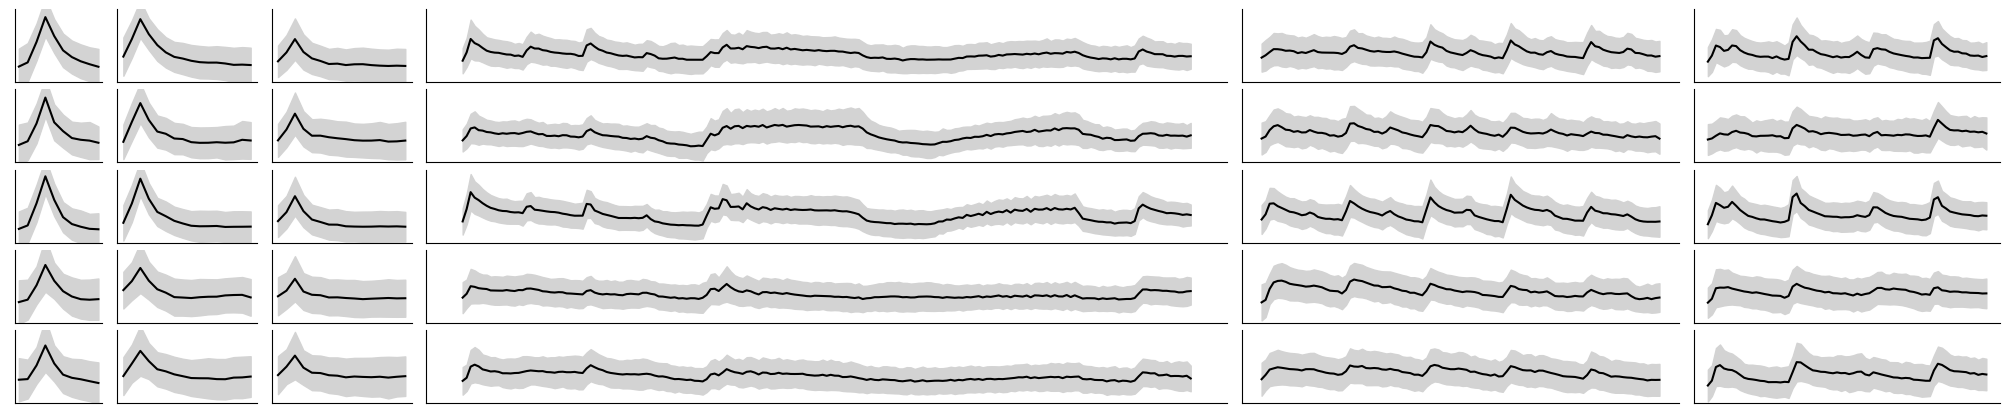

In [36]:
#%% Figure 5A: temporal_genetic
file_save_temporal_genetic = folder_figure + 'figure_5A'
_,_,_,_ = figure_cluster_genetic_temporal_box(df_results, 'genetic_label_num',  X_cluster_genetic[1:,:],
                                 temporal_list_genetic, [], temporal_zooms,
                                 columns_name_dendro.copy(), bins_list,
                                 file_save_temporal_genetic, fig_params, fac=True, sampling_rate=5)

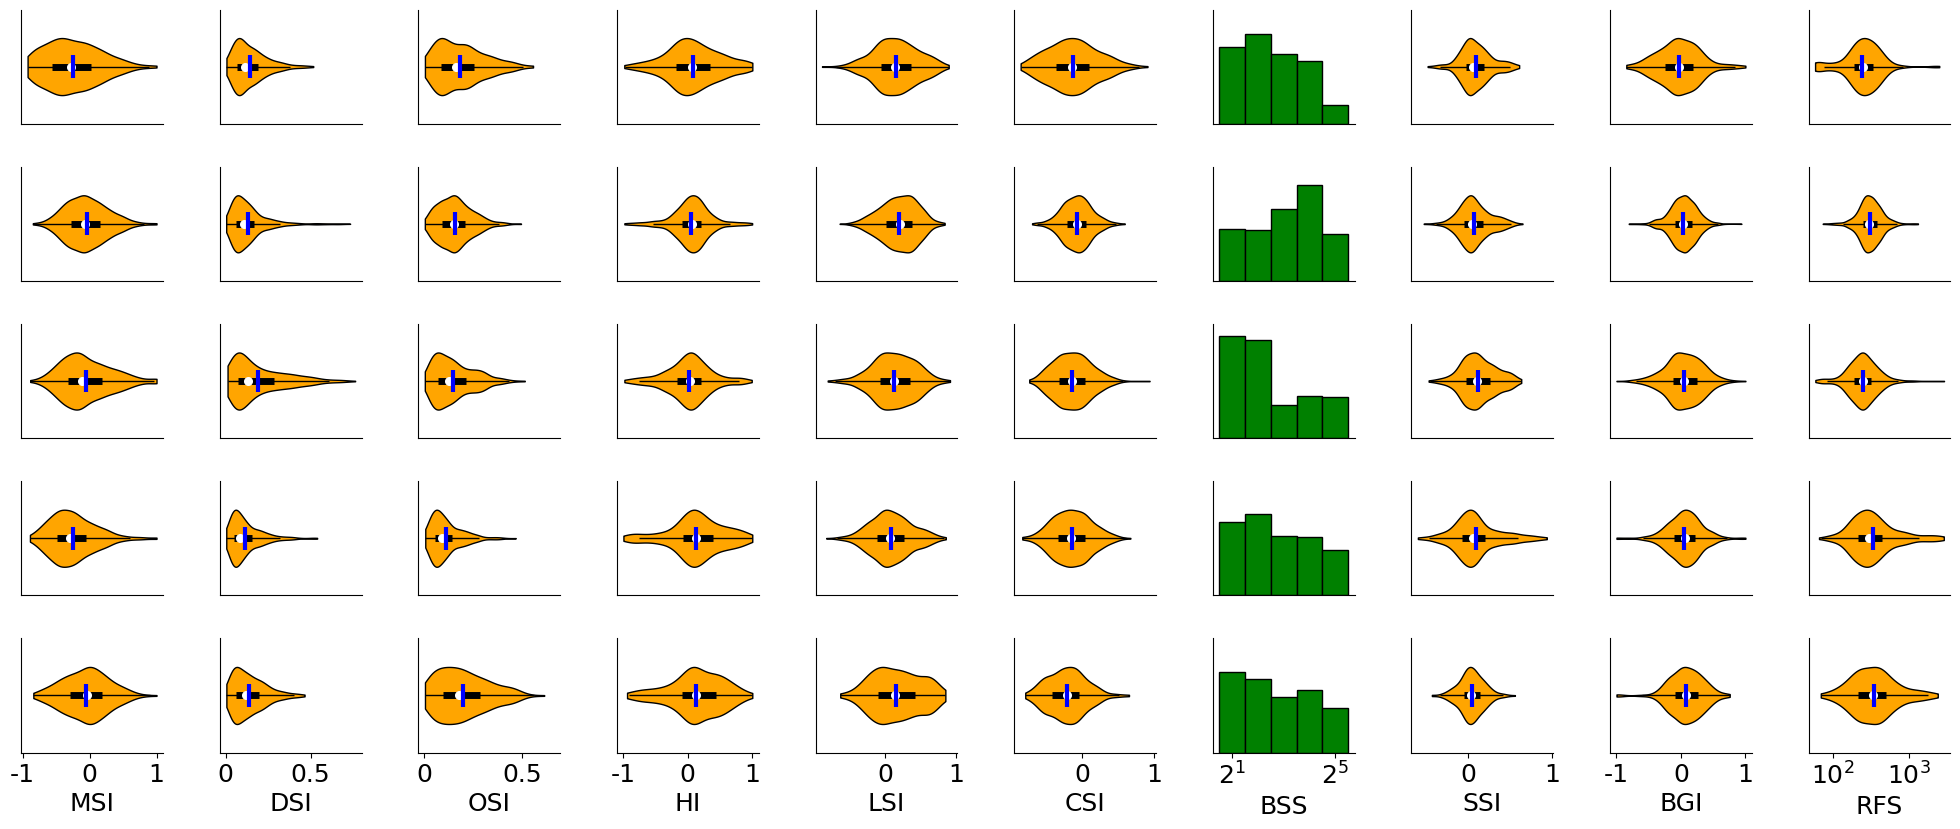

In [37]:
#%% Figure 5B: violin_box_genetic
file_save_violin_box_genetic = folder_figure + 'figure_5B'
freq_fac_all_genetic,freq_fac_clusters_genetic,_  = figure_violin_genetic(df_results, genetic_name, 'genetic_label', columns_label, 
                                                              columns_name.copy(), bins_list, [], 
                                                              fac=False, figsize=(20,8), pad=1.0,box_flag=box_flag)
plt.close()

_,_,_  = figure_violin_genetic(df_results, genetic_name[1:], 'genetic_label', columns_label, 
                                                              columns_name.copy(), bins_list, file_save_violin_box_genetic, 
                                                              fac=True, figsize=(20,8), pad=1.0,box_flag=box_flag)

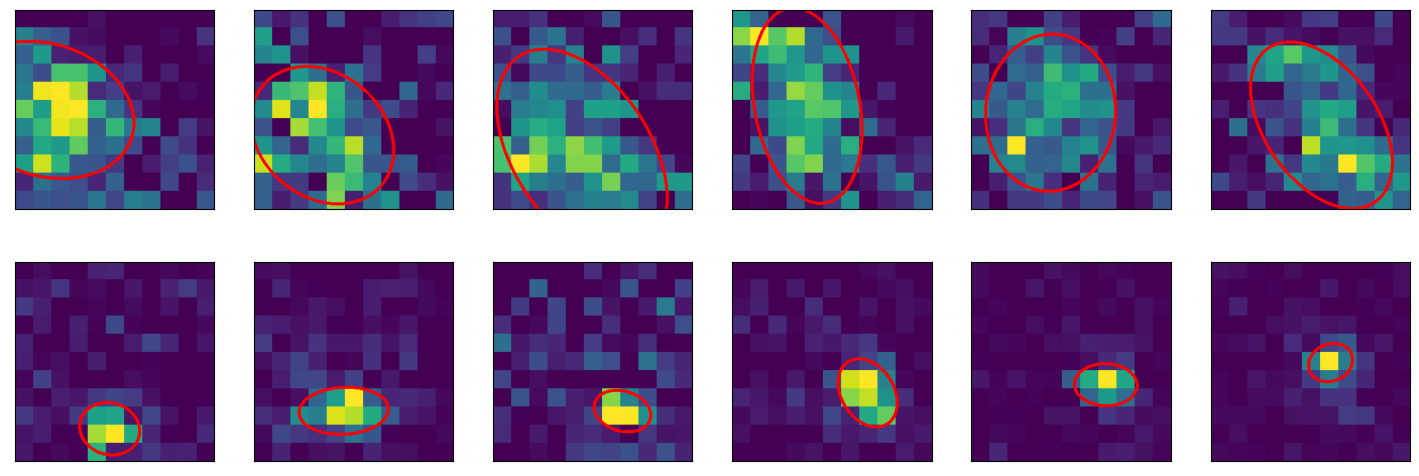

In [38]:
#%% Figure 5C: This is RF for all Ntsr1+ neurons, including RFs in the paper
rf_ntsr1_all = rf['rf_amp_all'][df_results['genetic_label']=='Ntsr1+']
plot_all_rf = False
if plot_all_rf:
    rf_ntsr1 = rf_ntsr1_all.copy() #[[],:]
else:
    rf_ntsr1 = rf_ntsr1_all[[48,51,204,234,235,286,5,18,19,42,50,67],:]
num_neuron_ntsr1 = rf_ntsr1.shape[0]
num_stim_rf = rf_ntsr1.shape[1]
rf_stim = (11,11)
# num_fig_rf_row = int(np.ceil(np.sqrt(num_neuron_ntsr1)))
# num_fig_rf_col = int(np.ceil(num_neuron_ntsr1/18))
# 
num_fig_rf_col = 6
num_fig_rf_row = int(np.ceil(num_neuron_ntsr1/num_fig_rf_col))
zoom = 3
fig,ax = plt.subplots(num_fig_rf_row,num_fig_rf_col,figsize=(num_fig_rf_col*zoom,num_fig_rf_row*zoom))
for i in range(num_fig_rf_row*num_fig_rf_col):
    row = int(np.floor(i/num_fig_rf_col))
    col = int(np.mod(i,num_fig_rf_col))
    if i<num_neuron_ntsr1:
        # plot off subfield
        rf_2d_off = np.reshape(rf_ntsr1[i,np.prod(rf_stim):],rf_stim)
        rf_min = rf_2d_off.min()
        rf_max = rf_2d_off.max()
        img_fit = ellipse_fit(rf_2d_off,ax=ax[row][col]) 
        # ax[row][col].text(0,0,str(i))
    ax[row][col].set_xticks([]) 
    ax[row][col].set_yticks([])
if save_fig:
    plt.savefig(folder_figure+'figure_5C.png',bbox_inches='tight')   
plt.show()

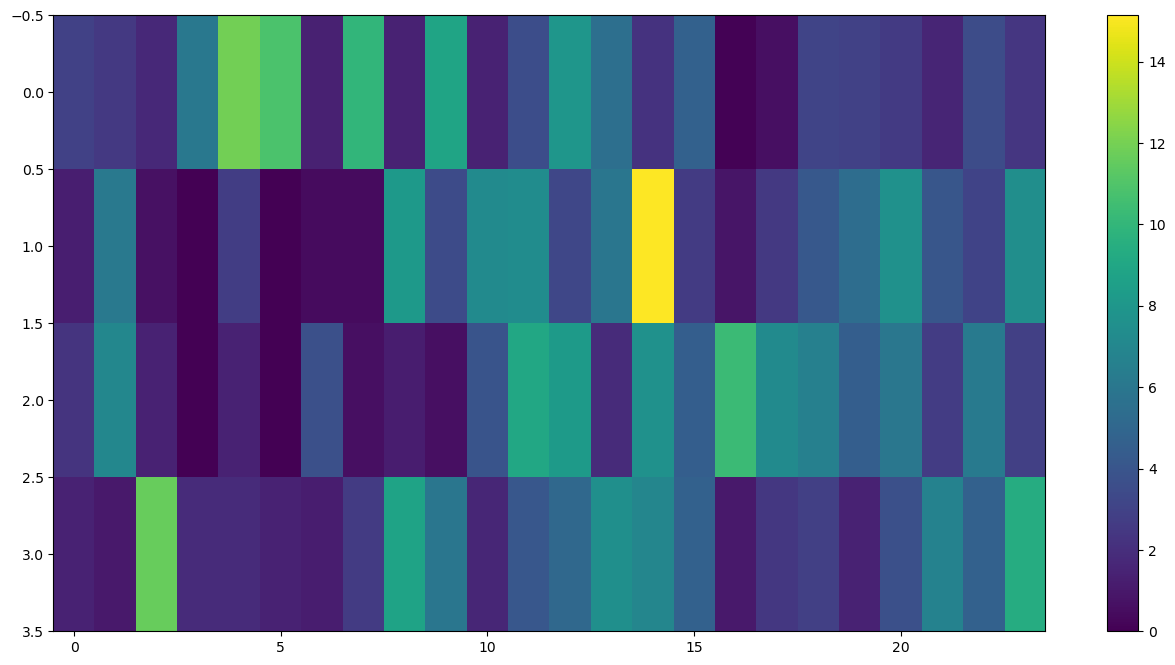

In [39]:
#%% Figure 5D
fig,ax = plt.subplots(1,1,figsize=(16,8))
freq_fac_clusters_genetic_plot = np.zeros((4,num_type))
freq_fac_clusters_genetic_plot[0,:] = freq_fac_clusters_genetic[2,:]
freq_fac_clusters_genetic_plot[1,:] = freq_fac_clusters_genetic[3,:]
freq_fac_clusters_genetic_plot[2,:] = freq_fac_clusters_genetic[4,:]
freq_fac_clusters_genetic_plot[3,:] = freq_fac_clusters_genetic[0,:]
im = ax.imshow(freq_fac_clusters_genetic_plot, cmap='viridis',aspect='auto',origin='upper')
fig.colorbar(im,ax=ax)
if save_fig:
    plt.savefig(folder_figure+'figure_5D.png',bbox_inches='tight')   
plt.show()

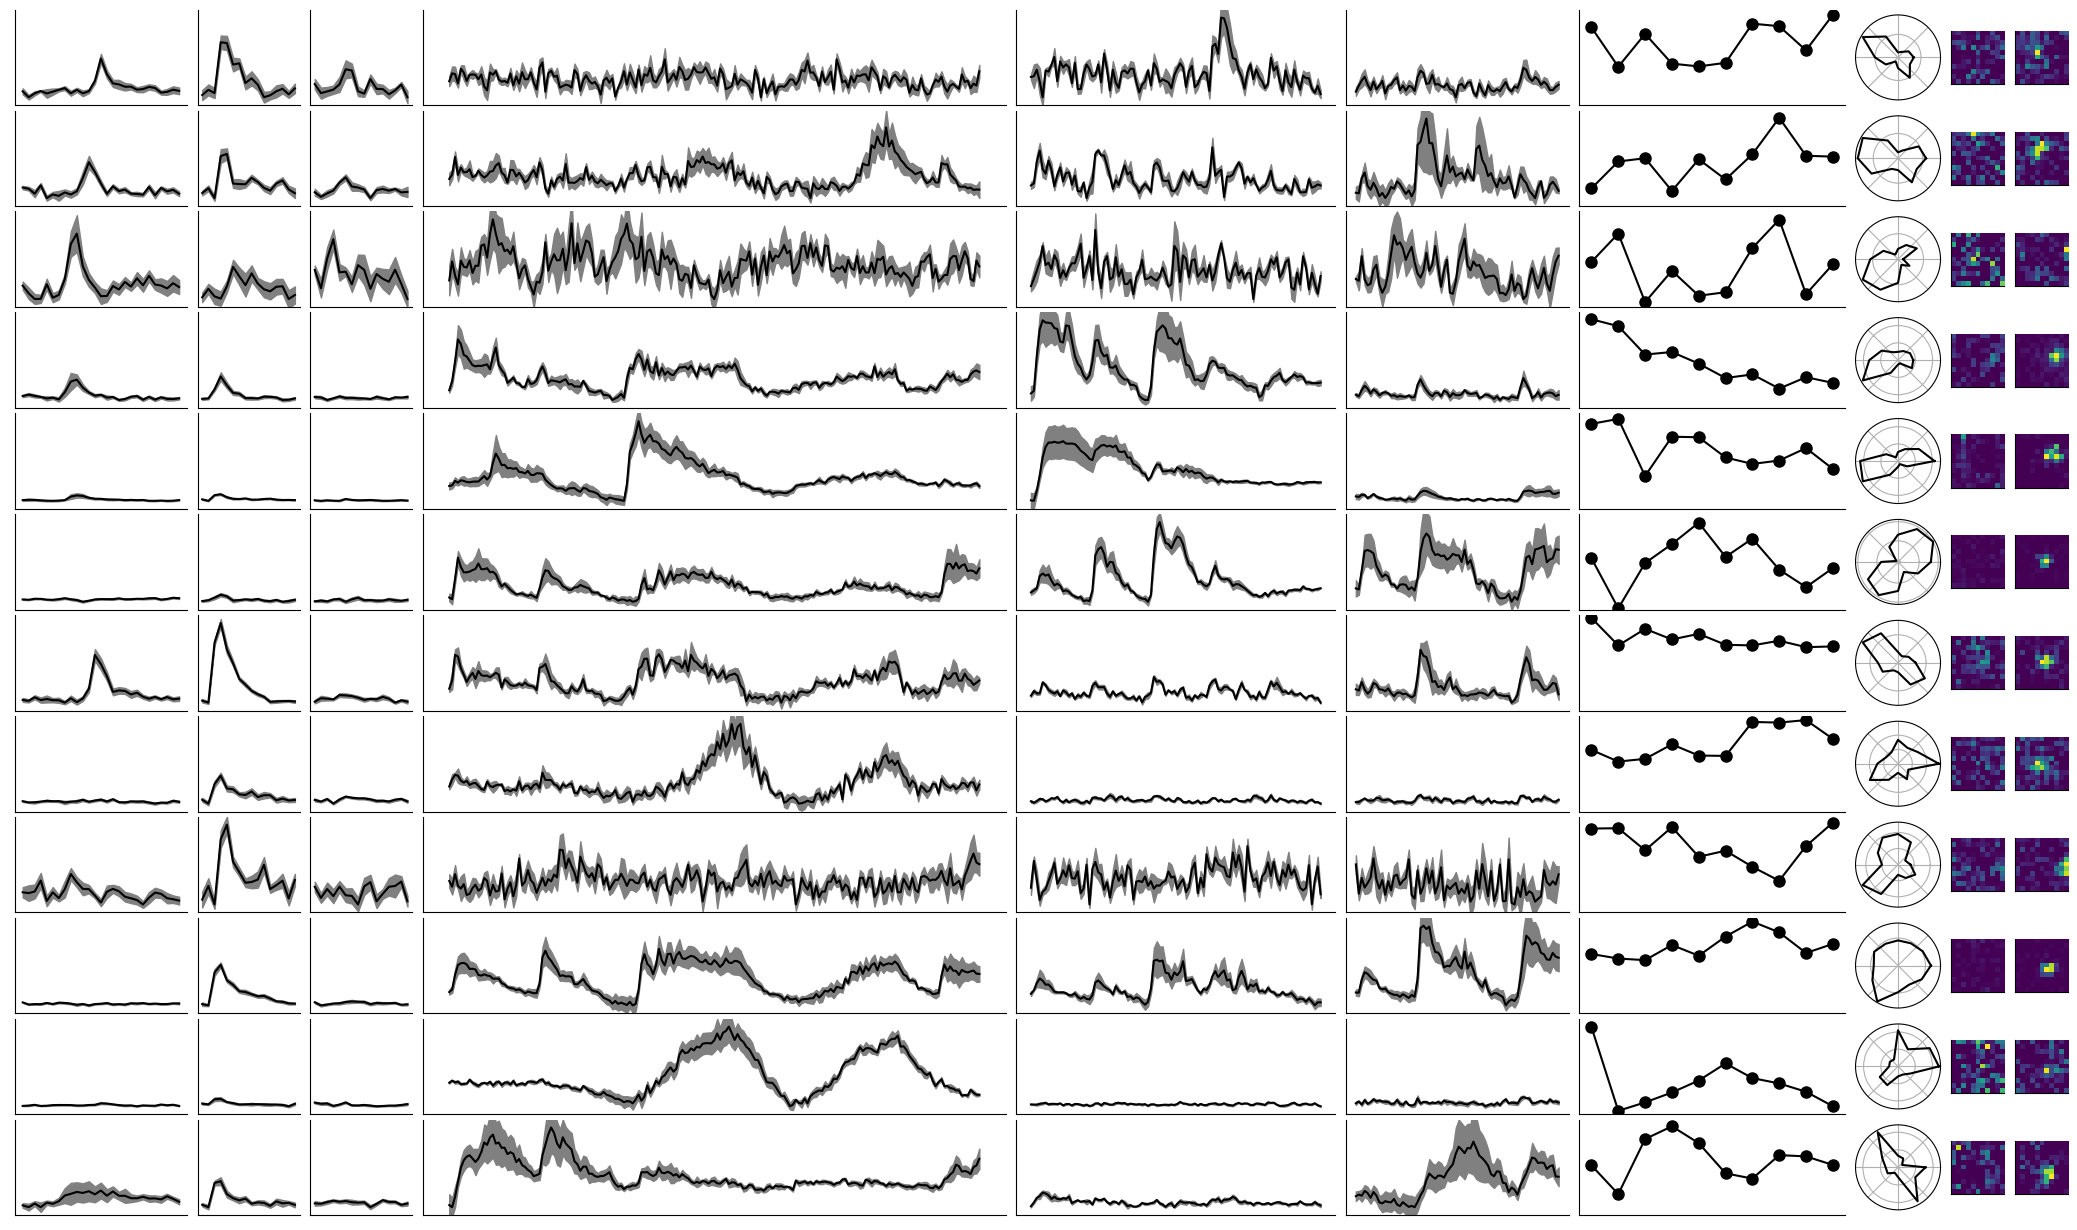

In [40]:
#%% Figure 1D
example_image_id = 18 # 18 is Vglut2_Cre AF2 20180125_1
example_image_idx = neuron['image_id']==example_image_id
all_temporal = np.concatenate((mb['mb_temporal'], dl_lr['dl_lr_temporal'], chirp['chirp_temporal'], 
                                st['st_temporal'], color['color_temporal']), axis=1)

example_image_temporal = all_temporal[example_image_idx,:]
example_image_temporal_mean = np.mean(example_image_temporal, axis=1)
example_image_temporal_max = np.max(example_image_temporal, axis=1)

all_temporal_se = np.concatenate((mb['mb_temporal_se'], dl_lr['dl_lr_temporal_se'], chirp['chirp_temporal_se'], 
                                  st['st_temporal_se'], color['color_temporal_se']), axis=1)
example_image_temporal_se = all_temporal_se[example_image_idx,:]

example_rois =  np.array([24,28,34,35,45,51,56,57,64,72,91,92])
example_rois_temporal = example_image_temporal[example_rois,:]
example_rois_temporal_se = example_image_temporal_se[example_rois,:]
example_temporal_len_list = [mb['mb_temporal'].shape[1],dl_lr['dl_lr_temporal'].shape[1],
                             chirp['chirp_temporal'].shape[1], st['st_temporal'].shape[1], color['color_temporal'].shape[1]]

example_temporal_list = temporal_list_generate(example_rois_temporal, example_rois_temporal_se, example_temporal_len_list)
temporal_zooms = [0.6, 0.6, 0.6, 0.3, 0.3, 0.3]

fig_params_example = fig_params.copy()
fig_params_example['offset'] = 0.04
fig_params_example['height_sub'] = 18
file_save_example = folder_figure + 'figure_1D' 

figure_example_temporal_bar_polor_rf(example_temporal_list, temporal_zooms,
                                 dl_lr['dl_amp'][example_image_idx,:][example_rois,:], mb['mb_amp'][example_image_idx,:][example_rois,:],
                                 rf['rf_amp_all'][example_image_idx,:][example_rois,:], 
                                 rf['rf_stim_center'][example_image_idx,:][example_rois,:], 
                                 fig_params_example, file_save_example, sampling_rate=5)

#%% plot excample for each cluster from all images, pick the neuron with the highest corr with the mean
snr_stack = np.loadtxt(folder_data+'snr_stack.csv',delimiter=',')
snr_stack_mean = np.mean(snr_stack,axis=1)

cell_corr = np.zeros(num_neuron)
for i in range(num_neuron):
    cell_corr[i],_ = scipy.stats.pearsonr(X[i,:],X_cluster_gmm_dendro[int(df_results['cluster_label_dendro_num'][i]),:])

example_all_rois_list_0 = []
snr_thr_example = 0.25
for i in range(num_type):
    idx_temp = np.where(df_results['cluster_label_dendro_num']==i)[0]
    idx_temp_1 = np.argsort(cell_corr[idx_temp])[::-1] 
    snr_sorted_temp = snr_stack_mean[idx_temp[idx_temp_1]]
    idx_cand = idx_temp[idx_temp_1[snr_sorted_temp>snr_thr_example]]
    if idx_cand.size>0:
        example_all_rois_list_0.append(idx_cand[0])


example_all_rois_list = list.copy(example_all_rois_list_0)
example_all_rois = np.asarray(example_all_rois_list)
example_all_rois_cluster = df_results['cluster_label_dendro_num'].iloc[example_all_rois]
example_all_rois_cluster_plot = np.asarray(num_type - example_all_rois_cluster)

example_all_rois_temporal = all_temporal[example_all_rois,:]
example_all_rois_temporal_se = all_temporal_se[example_all_rois,:]

example_all_temporal_list = temporal_list_generate(example_all_rois_temporal, example_all_rois_temporal_se, example_temporal_len_list)

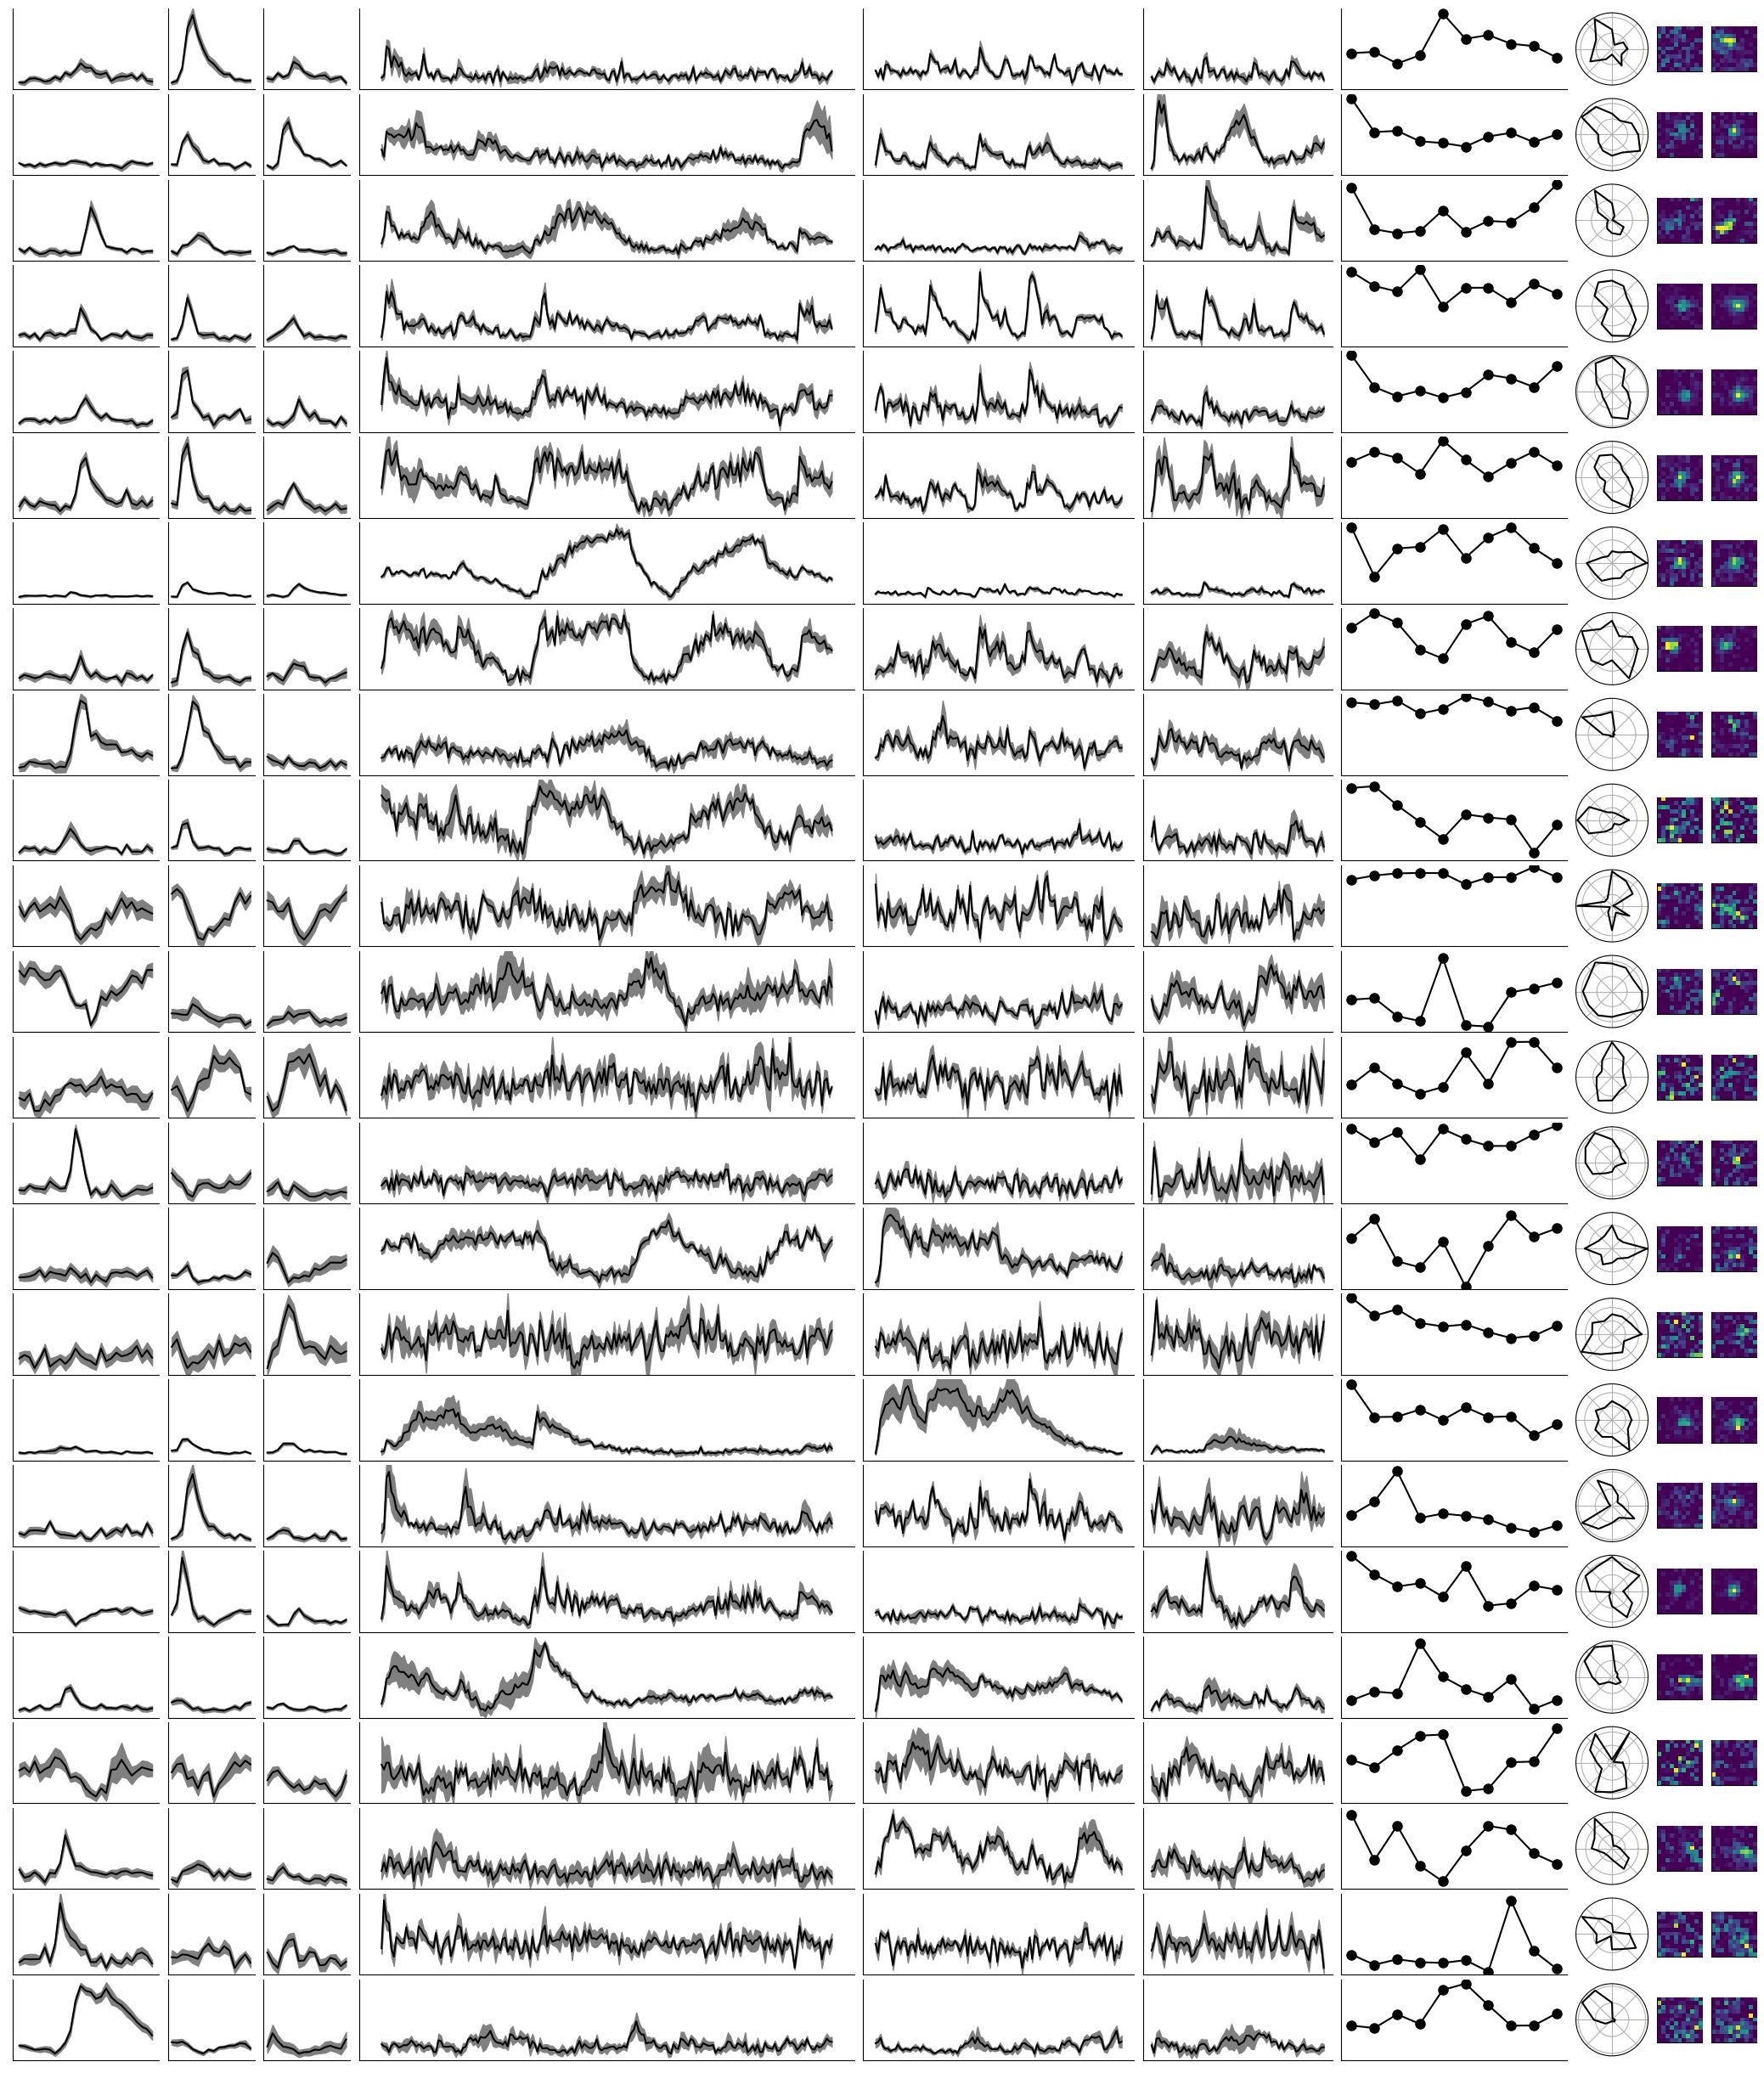

In [41]:
# Figure 9, related to Figure 2
file_save_example_all_corr = folder_figure + 'figure_9' 
figure_example_temporal_bar_polor_rf(example_all_temporal_list, temporal_zooms,
                                 dl_lr['dl_amp'][example_all_rois,:], mb['mb_amp'][example_all_rois,:],
                                 rf['rf_amp_all'][example_all_rois,:], 
                                 rf['rf_stim_center'][example_all_rois,:], 
                                 fig_params_example, file_save_example_all_corr, sampling_rate=5)

# %% calculate the imaging area for each experiment
# calculate the distance between two types and their p values with bootstrap
image_outline = []
num_image = np.unique(neuron['image_id']).size
image_area = np.zeros(num_image)
image_area_ftypes = np.zeros((num_image,num_type))
image_area_ratio_ftypes = np.zeros((num_image,num_type))
dist_mean_all_types = np.ones((num_image,num_type,num_type))*np.nan
p_all_types = np.ones((num_image,num_type,num_type))*np.nan
n_all_types = np.zeros((num_image,num_type))
n_norm_all_types = np.zeros((num_image,num_type))
n_btsp = 1000
n_neuron_type_thr = 5
for i in range(num_image):
    pts = neuron['soma_pos'][neuron['image_id']==i,:]
    for j in range(num_type):
        pts_j = neuron['soma_pos'][np.logical_and(neuron['image_id']==i,labels_gmm_dendro==j),:]
        n_all_types[i,j] = pts_j.shape[0]
        n_norm_all_types[i,j] = n_all_types[i,j]/pts.shape[0]
n_all_types_reverse = n_all_types[:,::-1]
n_all_types_reverse_T = n_all_types_reverse.T
n_norm_all_types_reverse = n_norm_all_types[:,::-1]
n_norm_all_types_reverse_T = n_norm_all_types_reverse.T
for i in range(num_image):
    pts = neuron['soma_pos'][neuron['image_id']==i,:]
    hull = ConvexHull(pts)
    pts_sorted = SortVertice(pts[hull.vertices,:])
    image_outline.append(np.insert(pts_sorted,pts_sorted.shape[0],pts_sorted[0,:],axis=0))
    image_area[i] = PolyArea(image_outline[-1])
    # get the image_area for each functional type
    for j in range(num_type):
        # print(i,j)
        pts_j = neuron['soma_pos'][np.logical_and(neuron['image_id']==i,labels_gmm_dendro==j),:]
        if pts_j.shape[0]>=n_neuron_type_thr:
            hull_j = ConvexHull(pts_j)
            image_area_ftypes[i,j] = PolyArea(SortVertice(pts_j[hull_j.vertices,:]))
        for k in range(j,num_type):
            pts_k = neuron['soma_pos'][np.logical_and(neuron['image_id']==i,labels_gmm_dendro==k),:]
            if pts_j.shape[0]>=n_neuron_type_thr and pts_k.shape[0]>=n_neuron_type_thr:
                dist_mean_all_types[i,j,k] = sep_dist(pts_k, pts_j)
                dist_mean_all_types[i,k,j] = dist_mean_all_types[i,j,k]
                    # bootstrap analysis
                pts_jk = np.concatenate((pts_j,pts_k),axis=0)
                dist_btsp = np.zeros(n_btsp)
                for l in range(n_btsp):
                    idx = np.random.choice(range(pts_jk.shape[0]),pts_j.shape[0],replace=False)
                    pts_jb = pts_jk[idx,:]
                    pts_kb = np.delete(pts_jk, idx, axis=0)
                    dist_btsp[l] = sep_dist(pts_jb,pts_kb) 
                p_all_types[i,j,k] = np.sum(dist_mean_all_types[i,j,k]<dist_btsp)/n_btsp
                p_all_types[i,k,j] = p_all_types[i,j,k]
    
    image_area_ratio_ftypes[i,:] = image_area_ftypes[i,:]/image_area[i]

p_all_types_2d = np.loadtxt(folder_data+'p_all_types.csv',delimiter=',')
p_all_types = p_all_types_2d.reshape(num_image,num_type,num_type)
    
image_area_ratio_ftypes[image_area_ratio_ftypes==0]=np.nan  
image_area_ratio_ftypes_0 = image_area_ratio_ftypes.copy()
image_area_ratio_ftypes_0[np.isnan(image_area_ratio_ftypes)]=0 
image_area_ratio_ftypes_reverse = image_area_ratio_ftypes[:,::-1]
dist_mean_all_types_reverse = dist_mean_all_types[:,::-1,::-1]  

p_all_types_max = np.ones((num_type,num_type))
dist_mean_all_types_mean = np.ones((num_type,num_type))*np.nan
dist_mean_all_types_std = np.ones((num_type,num_type))*np.nan
for i in range(num_type):
    for j in range(i,num_type):
        idx_select_p = np.where(np.logical_and(np.sum(n_all_types,axis=1)>50,
                                               np.min(n_all_types[:,[i,j]],axis=1)>=10))[0]
        if idx_select_p.size>0:
            p_all_types_max[i,j] = np.nanmax(p_all_types[idx_select_p,i,j])
            p_all_types_max[j,i] = p_all_types_max[i,j]
            dist_mean_all_types_mean[i,j] = np.nanmean(dist_mean_all_types[idx_select_p,i,j], axis=0)
            dist_mean_all_types_mean[j,i] = dist_mean_all_types_mean[i,j]
            dist_mean_all_types_std[i,j] = np.nanstd(dist_mean_all_types[idx_select_p,i,j], axis=0)
            dist_mean_all_types_std[j,i] = dist_mean_all_types_std[i,j]
p_all_types_max_reverse = p_all_types_max[::-1,::-1]
p_all_types_max_reverse_005 = np.zeros_like(p_all_types_max_reverse)
p_all_types_max_reverse_005[p_all_types_max_reverse<0.05]=1
p_all_types_max_reverse_005_sum = np.sum(p_all_types_max_reverse_005,axis=0)


x_p_all_types_max_reverse_005,y_p_all_types_max_reverse_005 = np.where(p_all_types_max_reverse_005==1)
x_y_p_all_types_max_reverse_005 = np.stack((x_p_all_types_max_reverse_005,y_p_all_types_max_reverse_005),axis=1)

dist_mean_all_types_mean_reverse = dist_mean_all_types_mean[::-1,::-1]
dist_mean_all_types_std_reverse = dist_mean_all_types_std[::-1,::-1]
dist_mean_all_types_mean_reverse_mean = np.nanmean(dist_mean_all_types_mean_reverse,axis=0)

dist_mean_all_types_mean_reverse_p = dist_mean_all_types_mean_reverse*p_all_types_max_reverse_005
dist_mean_all_types_mean_reverse_p[np.isnan(dist_mean_all_types_mean_reverse_p)] = 0
num_separated = np.sum(dist_mean_all_types_mean_reverse_p!=0,axis=0)

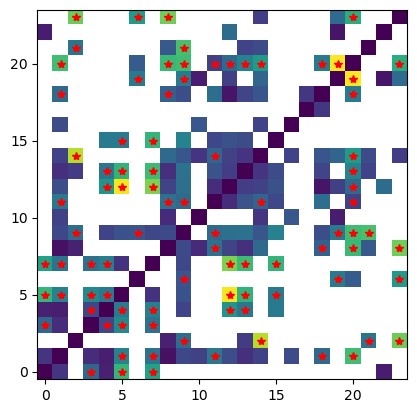

In [42]:
# Figure 4F
fig,ax = plt.subplots(1,1)
ax.imshow(dist_mean_all_types_mean_reverse,origin='lower')
ax.plot(x_p_all_types_max_reverse_005,y_p_all_types_max_reverse_005,'r*')
ax.set_aspect('equal')
if save_fig:
    plt.savefig(folder_figure+'figure_4F.png',bbox_inches='tight')
plt.show()

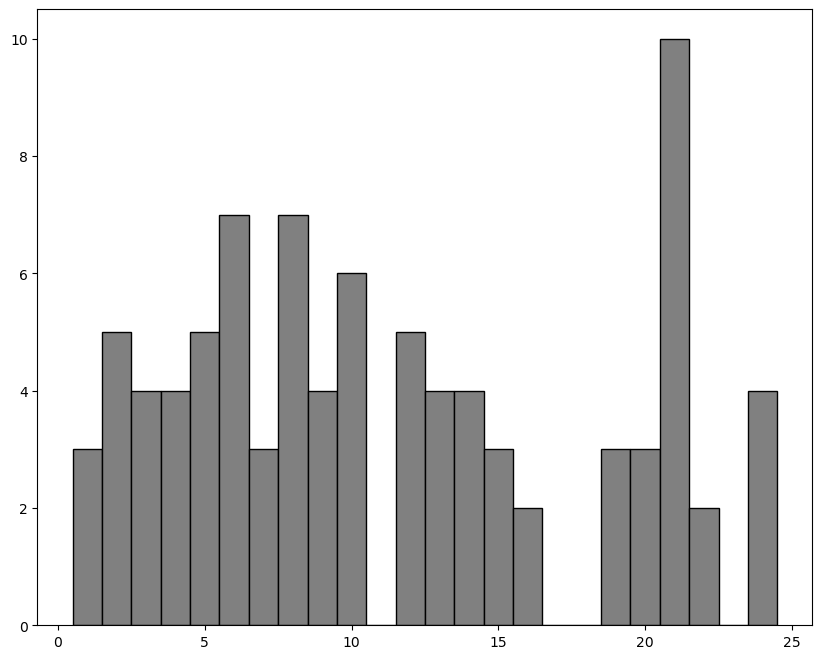

In [43]:
# Figure 11B, related to Figure 4
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.bar(range(1,num_type+1),num_separated,width=1,color='gray',edgecolor='black')
if save_fig:
    plt.savefig(folder_figure+'figure_11B.png',bbox_inches='tight')
plt.show()
#%% analyze the cell types within 50um from a neuron
# only select types which has >=5 neurons in a image
neurons_per_image = np.zeros(num_image)
for i in range(num_image):
    neurons_per_image[i] = np.sum(neuron['image_id']==i)
image = {'image_area':image_area,
         'neurons_per_image':neurons_per_image}

#%% analyze the cell types within 50um-300um from a neuron
dist_thr_arr = np.asarray(range(50,301,50))
density_cell_type_nearby_mean_reverse_arr, density_cell_type_nearby_sum_reverse_arr = density_dist(dist_thr_arr,df_results,image,n_all_types)

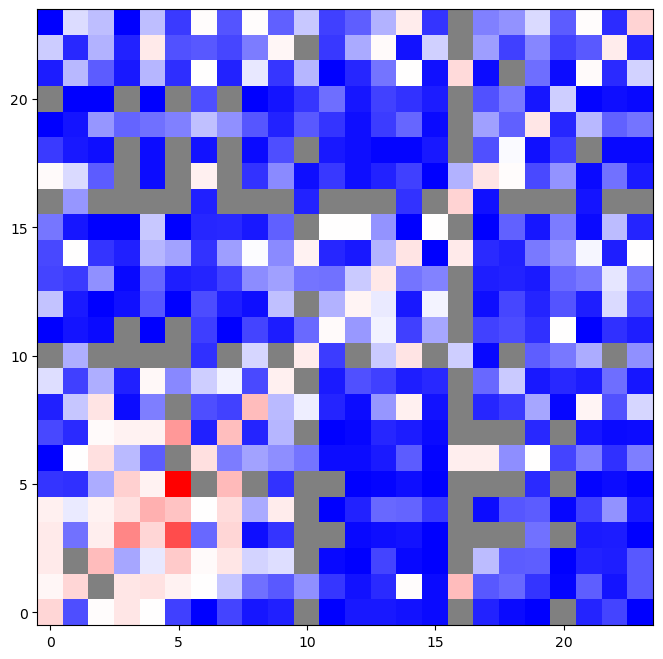

In [44]:
# Figure 4E
fig,ax = plt.subplots(1,1,figsize=(8,8))
#cmap = matplotlib.colormaps.get_cmap("bwr").copy() #this is for newer versions
cmap = plt.cm.get_cmap("bwr").copy()
cmap.set_bad('grey',1.)
m = np.ma.masked_where(np.isnan(density_cell_type_nearby_mean_reverse_arr[0,:,:]),density_cell_type_nearby_mean_reverse_arr[0,:,:])
norm = colors.TwoSlopeNorm(vcenter=1)
ax.imshow(m,cmap=cmap,norm=norm,interpolation='nearest',origin='lower')
if save_fig:
    plt.savefig(folder_figure+'figure_4E.png',bbox_inches='tight')    
plt.show()

In [45]:
#%% plot the density recovery profile in anatomical space
bin_size_anatomy = 10 # set bin size to 10um; change 20 run this again
dist_max_anatomy = 1500 #set the largest distance is 1mm
bins_max_anatomy = np.arange(0, dist_max_anatomy+bin_size_anatomy, bin_size_anatomy)
bin_num_anatomy = bins_max_anatomy.size-1
density_all_types_anatomy_mean = np.zeros((bin_num_anatomy, num_type))
density_all_types_anatomy_sd = np.zeros((bin_num_anatomy, num_type))
density_all_types_anatomy_sem = np.zeros((bin_num_anatomy, num_type))
# calculate the image window ffor all imaging planes
w_density = np.zeros(num_image)
h_density = np.zeros(num_image)
idx_select_50 = np.where(neurons_per_image>50)[0]
idx_del_50 = np.where(neurons_per_image<=50)[0]
for i in range(num_image):
    w_density[i] = neuron['soma_pos'][neuron['image_id']==i,0].max() - neuron['soma_pos'][neuron['image_id']==i,0].min()
    h_density[i] = neuron['soma_pos'][neuron['image_id']==i,1].max() - neuron['soma_pos'][neuron['image_id']==i,1].min()

density_all_type_anatomy = np.ones((num_type, num_image, bin_num_anatomy))*np.nan
for i in range(num_type):
    density_one_type_anatomy = np.ones((bin_num_anatomy, num_image))*np.nan
    for j in range(num_image):
        image_ij = np.logical_and(neuron['image_id']==j, df_results['cluster_label_dendro_num']==i)
        if np.sum(image_ij)>=5: 
            _,density_anatomy_temp,_ = Analyze_Dist_Poly(neuron['soma_pos'][image_ij,:],bin_size_anatomy,image_outline[j])
            density_one_type_anatomy[:density_anatomy_temp.shape[0],j] = density_anatomy_temp
    density_one_type_anatomy[:,idx_del_50]=np.nan # assign nan to images that have <=50 neurons
    density_all_type_anatomy[i,:,:] = density_one_type_anatomy.T
    density_one_type_anatomy_mean = np.nanmean(density_one_type_anatomy,axis=1)
    density_one_type_anatomy_sd = np.nanstd(density_one_type_anatomy,axis=1)
    density_one_type_anatomy_sem = scipy.stats.sem(density_one_type_anatomy, axis=1, ddof=1, nan_policy='omit')
    density_all_types_anatomy_mean[:,i] = density_one_type_anatomy_mean
    density_all_types_anatomy_sd[:,i] = density_one_type_anatomy_sd
    density_all_types_anatomy_sem[:,i] = density_one_type_anatomy_sem
         
density_all_types_mean_anatomy = np.mean(density_all_types_anatomy_mean,axis=1)

neurons_per_cluster_density = np.zeros(num_type)
for i in range(num_type):
    neurons_per_cluster_density[i] = np.sum(df_results['cluster_label_dendro_num']==i)
    
cluster_label_5_example_all_density = neurons_per_cluster_density.argsort()[-5:][::-1]
cluster_label_5_example_all_density_plot = num_type - cluster_label_5_example_all_density

cluster_label_5_example_all_density =  num_type - cluster_label_5_example_all_density_plot
density_all_types_anatomy_example_all_mean_sem = np.zeros((bin_num_anatomy,cluster_label_5_example_all_density.size*2))
density_all_types_anatomy_example_all_mean_sem[:,::2] = density_all_types_anatomy_mean[:,cluster_label_5_example_all_density]
density_all_types_anatomy_example_all_mean_sem[:,1::2] = density_all_types_anatomy_sem[:,cluster_label_5_example_all_density]

/var/folders/4y/rg6_q7vx5xd1ktywb41t92bh0000gn/T/ipykernel_90713/1750813903.py:28: RuntimeWarning: Mean of empty slice
  density_one_type_anatomy_mean = np.nanmean(density_one_type_anatomy,axis=1)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


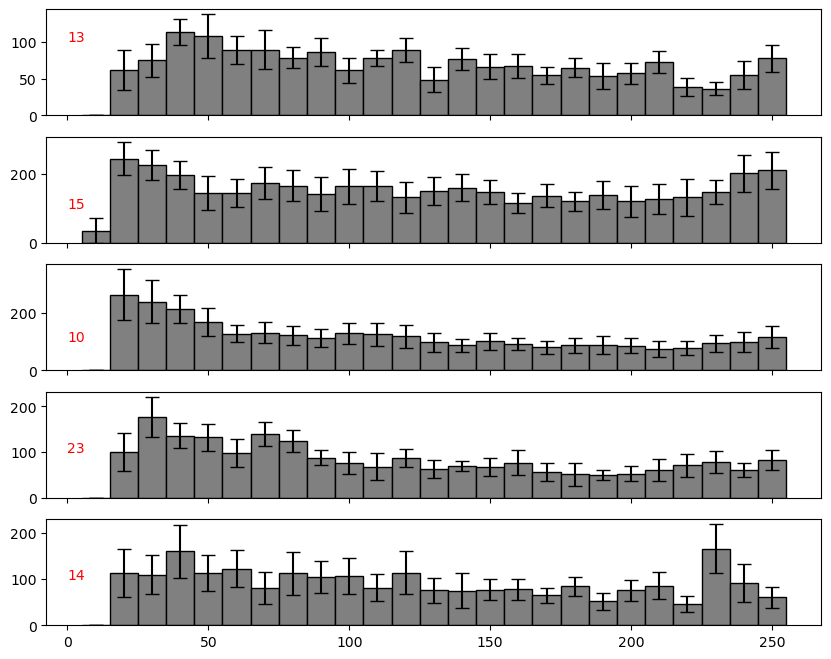

In [46]:
# Figure 4B
# MM: this take a few minutes to run
n_drp_example = 5
fig, ax = plt.subplots(5,1,sharex=True,figsize = (10,8))
for i in range(n_drp_example):
    ax[i].bar(bins_max_anatomy[1:26],density_all_types_anatomy_example_all_mean_sem[:25,i*2]*1e6,
        yerr=density_all_types_anatomy_example_all_mean_sem[:25,i*2+1]*1e6,width=10,color='grey',edgecolor='black',capsize=5)
    ax[i].text(0,100,str(cluster_label_5_example_all_density_plot[i]),color='red')
if save_fig:
    plt.savefig(folder_figure+'figure_4B.png',bbox_inches='tight')
plt.show()

In [47]:
density_all_types_anatomy_all_mean_sem = np.zeros((bin_num_anatomy,num_type*2))
density_all_types_anatomy_all_mean_sem[:,::2] = density_all_types_anatomy_mean
density_all_types_anatomy_all_mean_sem[:,1::2] = density_all_types_anatomy_sem
density_all_types_anatomy_mean_T = density_all_types_anatomy_mean[:26,:].T
density_all_types_anatomy_mean_T_50um_bin = np.zeros((num_type,5))
for i in range(5):
    density_all_types_anatomy_mean_T_50um_bin[:,i] = np.nanmean(density_all_types_anatomy_mean_T[:,i*5:(i+1)*5],axis=1)
density_all_types_anatomy_mean_T_norm = np.zeros_like(density_all_types_anatomy_mean_T_50um_bin)
for i in range(num_type):
    density_all_types_anatomy_mean_T_norm[i,:] = density_all_types_anatomy_mean_T_50um_bin[i,:]/np.nanmax(density_all_types_anatomy_mean_T_50um_bin[i,:])


drp_peak_idx = np.argmax(density_all_types_anatomy_mean_T_norm,axis=1)
drp_peak_half = 1/2
drp_peak_half_idx = np.ones_like(drp_peak_idx)*np.nan
for i in range(num_type):
    if drp_peak_idx[i]<=1:
        if np.where(density_all_types_anatomy_mean_T_norm[i,:]<drp_peak_half)[0].size>0:
            drp_peak_half_idx[i] = np.where(density_all_types_anatomy_mean_T_norm[i,:]<drp_peak_half)[0][0]
        else:
            drp_peak_half_idx[i] = 5
        

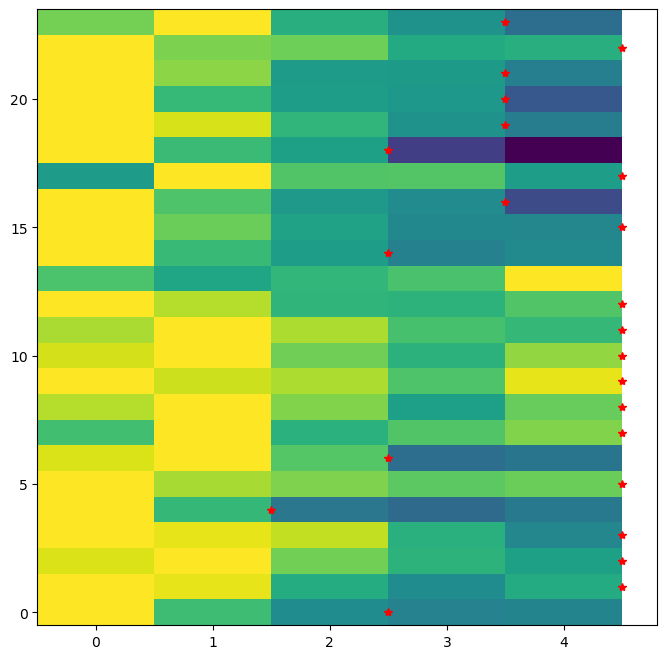

In [48]:
#Figure 4C
fig, ax = plt.subplots(1,1,figsize = (8,8))
ax.imshow(density_all_types_anatomy_mean_T_norm,aspect='auto',origin='lower')
ax.plot(drp_peak_half_idx-0.5,np.array(range(num_type)),'r*')   
plt.xlim([-0.5,4.8]) 
if save_fig:
    plt.savefig(folder_figure+'figure_4C.png',bbox_inches='tight')
plt.show()

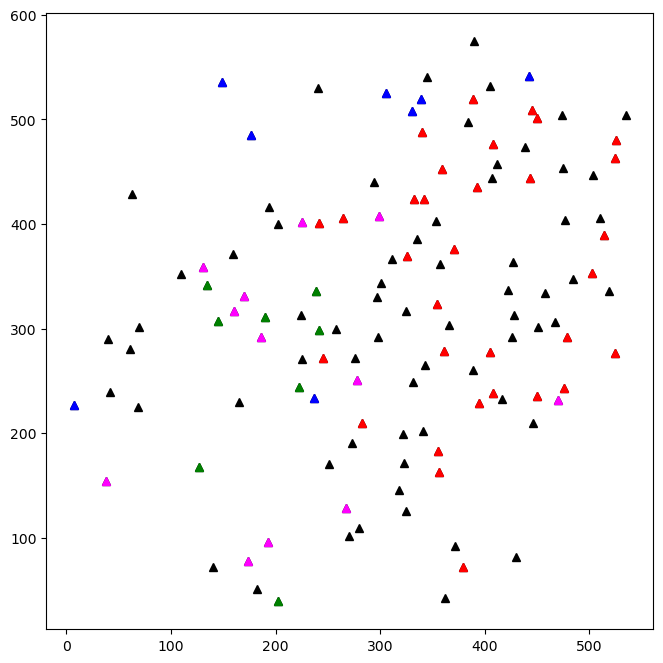

In [49]:
# Figure 4A, Scatter plot for images with types color-coded
color_scatter = ['red','magenta','blue','green']
image_example_density = 18
cluster_label_5_example_density_plot = np.array([7,24,21,14])
soma_position_example_density,soma_position_5_example_density,_= scatter_types(image_example_density,df_results,neuron,cluster_label_5_example_density_plot)
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(soma_position_example_density[:,0],soma_position_example_density[:,1],'^',color='black')
for i in range(len(color_scatter)):
    ax.plot(soma_position_5_example_density[:,i*2],soma_position_5_example_density[:,i*2+1],'^',color=color_scatter[i])
ax.set_aspect('equal') 
if save_fig:
    plt.savefig(folder_figure+'figure_4A.png',bbox_inches='tight')       
plt.show()

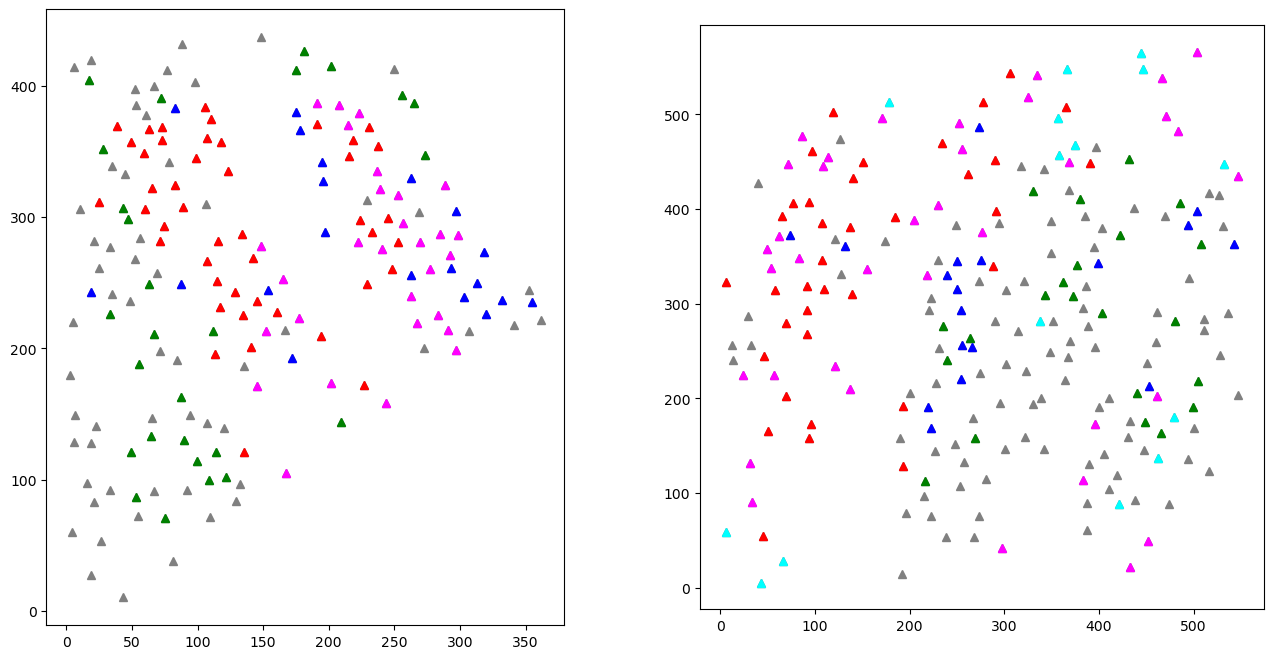

In [50]:
# Figure 11A, related to Figure 4
color_scatter = ['red','magenta','green','blue']
image_example_density = 30
soma_position_example_density,soma_position_5_example_density,cluster_label_5_example_density_plot= scatter_types(image_example_density,df_results,neuron)
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(soma_position_example_density[:,0],soma_position_example_density[:,1],'^',color='grey')
for i in range(len(color_scatter)):
    ax[0].plot(soma_position_5_example_density[:,i*2],soma_position_5_example_density[:,i*2+1],'^',color=color_scatter[i])
ax[0].set_aspect('equal') 

color_scatter = ['red','magenta','green','blue','cyan']
image_example_density = 12
soma_position_example_density,soma_position_5_example_density,cluster_label_5_example_density_plot= scatter_types(image_example_density,df_results,neuron)
ax[1].plot(soma_position_example_density[:,0],soma_position_example_density[:,1],'^',color='grey')
for i in range(len(color_scatter)):
    ax[1].plot(soma_position_5_example_density[:,i*2],soma_position_5_example_density[:,i*2+1],'^',color=color_scatter[i])
ax[1].set_aspect('equal') 
if save_fig:
    plt.savefig(folder_figure+'figure_11A.png',bbox_inches='tight')       
plt.show()

In [51]:
#%% calculate the ratio of density
# 1mm = 76 degs elevation, 100 degs azimuth from Dräger and Hubel, 1975
rf_visual_to_anatomy = 88 #degs per mm
rf_size_median_cluster = np.zeros(num_type)
for i in range(num_type):
    rf_size_median_cluster[i] = np.nanmedian(df_results['rf_size'][df_results['cluster_label_dendro_num']==i])
rf_dia_median_cluster = np.sqrt(rf_size_median_cluster/np.pi)*2
rf_dia_anat_median_cluster = rf_dia_median_cluster/rf_visual_to_anatomy*1e3 #in um

# # plot the relationship bewtween one type and the other types. neurons within 0.5RF / neurons between 0.5 RF and 1RF
rf_radius_anat_arr = np.stack((rf_dia_anat_median_cluster/2, rf_dia_anat_median_cluster/1),axis=1) #0.5RF to 1RF
density_other_types_anatomy_mean,_ = density_dist(rf_radius_anat_arr,df_results,image,n_all_types)

density_all_types_anatomy_mean_0_5_rf = np.zeros(num_type)
density_all_types_anatomy_mean_1_0_rf = np.zeros(num_type)
density_all_types_anatomy_mean_rf_ratio = np.zeros(num_type)

density_other_types_anatomy_mean_0_5_rf = np.zeros(num_type)
density_other_types_anatomy_sd_0_5_rf = np.zeros(num_type)
density_other_types_anatomy_mean_1_0_rf = np.zeros(num_type)
density_other_types_anatomy_sd_1_0_rf = np.zeros(num_type)

density_same_types_anatomy_mean_0_5_rf = np.zeros(num_type)
density_same_types_anatomy_mean_1_0_rf = np.zeros(num_type)
density_same_types_anatomy_mean_rf_ratio = np.zeros(num_type)


for i in range(num_type):

    density_all_types_anatomy_mean_0_5_rf[i] = np.nanmean(density_other_types_anatomy_mean[0,i,:])
    density_all_types_anatomy_mean_1_0_rf[i] = np.nanmean(density_other_types_anatomy_mean[1,i,:])
    
    idx_temp = np.array(range(num_type))!=i
    density_other_types_anatomy_mean_0_5_rf[i] = np.nanmean(density_other_types_anatomy_mean[0,i,idx_temp])
    density_other_types_anatomy_sd_0_5_rf[i] = np.nanstd(density_other_types_anatomy_mean[0,i,idx_temp])
    
    density_other_types_anatomy_mean_1_0_rf[i] = np.nanmean(density_other_types_anatomy_mean[1,i,idx_temp])
    density_other_types_anatomy_sd_1_0_rf[i] = np.nanstd(density_other_types_anatomy_mean[1,i,idx_temp])
    
    density_same_types_anatomy_mean_0_5_rf[i] = density_other_types_anatomy_mean[0,i,i]
    density_same_types_anatomy_mean_1_0_rf[i] = density_other_types_anatomy_mean[1,i,i]
    
density_all_types_anatomy_mean_rf_ratio = density_all_types_anatomy_mean_0_5_rf/density_all_types_anatomy_mean_1_0_rf    
density_other_types_anatomy_mean_rf_ratio = density_other_types_anatomy_mean_0_5_rf/density_other_types_anatomy_mean_1_0_rf
density_same_types_anatomy_mean_rf_ratio = density_same_types_anatomy_mean_0_5_rf/density_same_types_anatomy_mean_1_0_rf


density_other_types_anatomy_mean_rf_ratio_reverse = density_other_types_anatomy_mean_rf_ratio[::-1]/density_all_types_anatomy_mean_rf_ratio[::-1]
density_same_types_anatomy_mean_rf_ratio_reverse = density_same_types_anatomy_mean_rf_ratio[::-1]/density_all_types_anatomy_mean_rf_ratio[::-1]

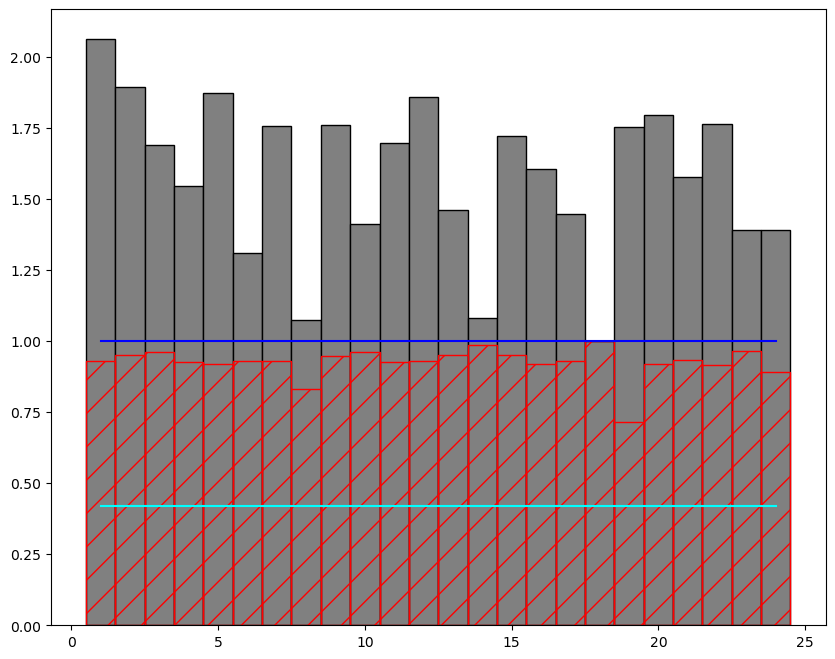

In [52]:
#Figure 4D
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.bar(np.array(range(num_type))+1,density_same_types_anatomy_mean_rf_ratio_reverse,color='grey',edgecolor='black',width=1)
ax.bar(np.array(range(num_type))+1,density_other_types_anatomy_mean_rf_ratio_reverse,color='red',edgecolor='red',width=1,fill=False,hatch='/')
ax.plot(np.array(range(num_type))+1,np.ones(num_type),'blue')
ax.plot(np.array(range(num_type))+1,np.ones(num_type)*0.42,'cyan')
if save_fig:
    plt.savefig(folder_figure+'figure_4D.png',bbox_inches='tight')     
plt.show()

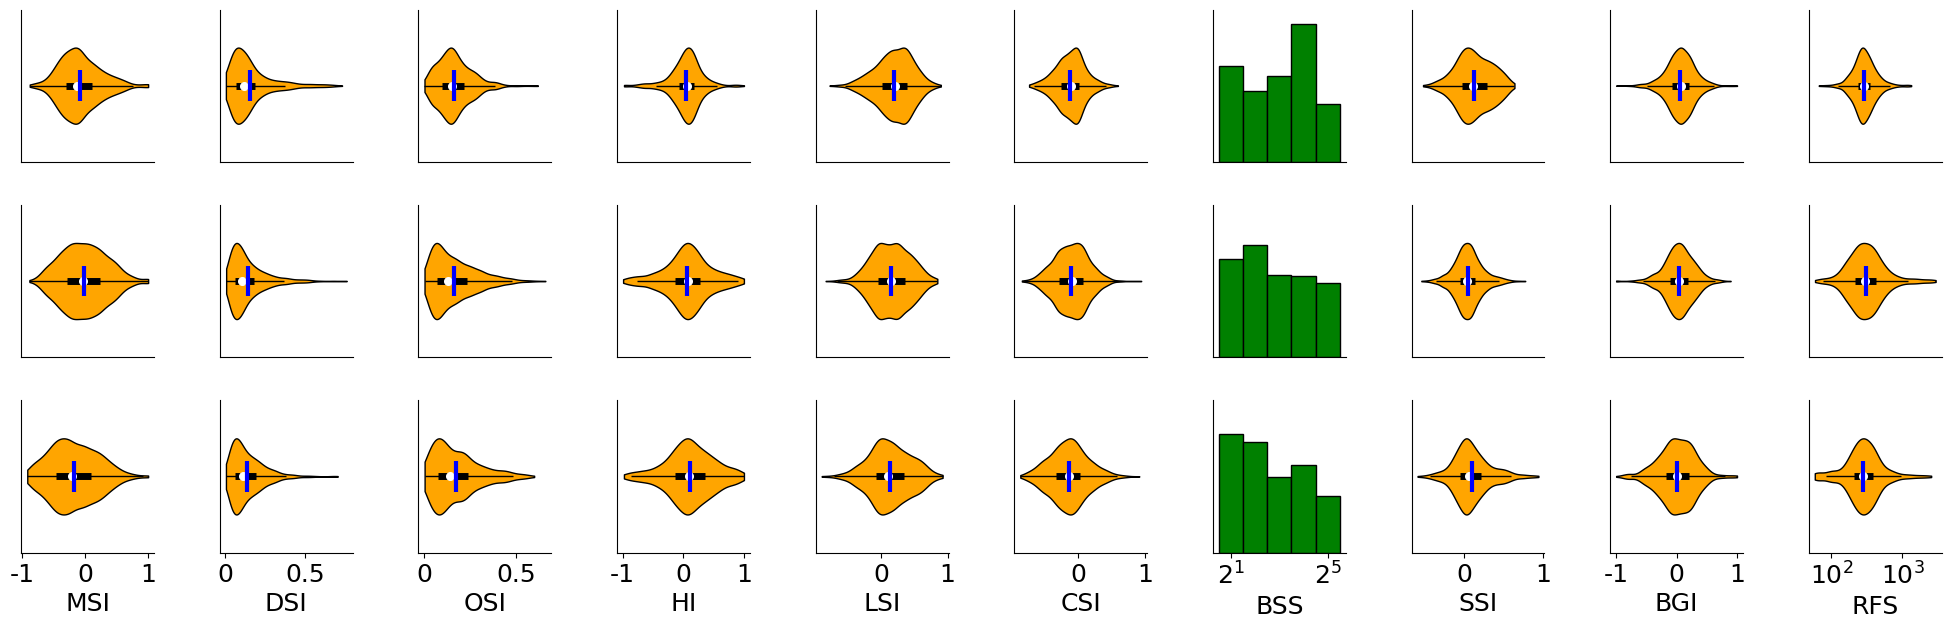

In [53]:
#%% analyze how the cell types depend on the depth, one example and the summary
# divide neurons into three groups according to thier depths: [0,100], [100,200], [200,]
soma_depth_groups = np.zeros_like(neuron['soma_depth'])
soma_depth_groups[np.logical_and(neuron['soma_depth']>0.1,neuron['soma_depth']<=0.2)] = 1
soma_depth_groups[neuron['soma_depth']>0.2] = 2
df_results['depth_label_num'] = soma_depth_groups

X_temporal_cluster_depth,X_temporal_cluster_depth_error,_,_ = plot_cluster(X_temporal,df_results['depth_label_num'],[])
X_cluster_depth,_,_,_ = plot_cluster(X,df_results['depth_label_num'],[])
temporal_list_depth = temporal_list_generate(X_temporal_cluster_depth, X_temporal_cluster_depth_error, temporal_len_list)


#%% violin plot across the depth
file_save_violin_box_depth = folder_figure + 'figure_4G'
depth_name = ['D1', 'D2', 'D3']
soma_depth_label = []
for i in range(num_neuron):
    soma_depth_label.append(depth_name[int(soma_depth_groups[i])])
df_results['depth_label'] = soma_depth_label
[freq_fac_all_depth,freq_fac_clusters_depth,_] = figure_violin_genetic(df_results, depth_name, 'depth_label', columns_label, 
                                                              columns_name.copy(), bins_list, [], 
                                                              fac=False, figsize=(20,6), pad=1.0,box_flag=box_flag)
plt.close()

#Figure 4G
file_save_violin_box_depth = folder_figure + 'figure_4G'
_,_,data_box_depth = figure_violin_genetic(df_results, depth_name, 'depth_label', columns_label, 
                                                              columns_name.copy(), bins_list, file_save_violin_box_depth, 
                                                              fac=True, figsize=(20,6), pad=1.0,box_flag=box_flag)

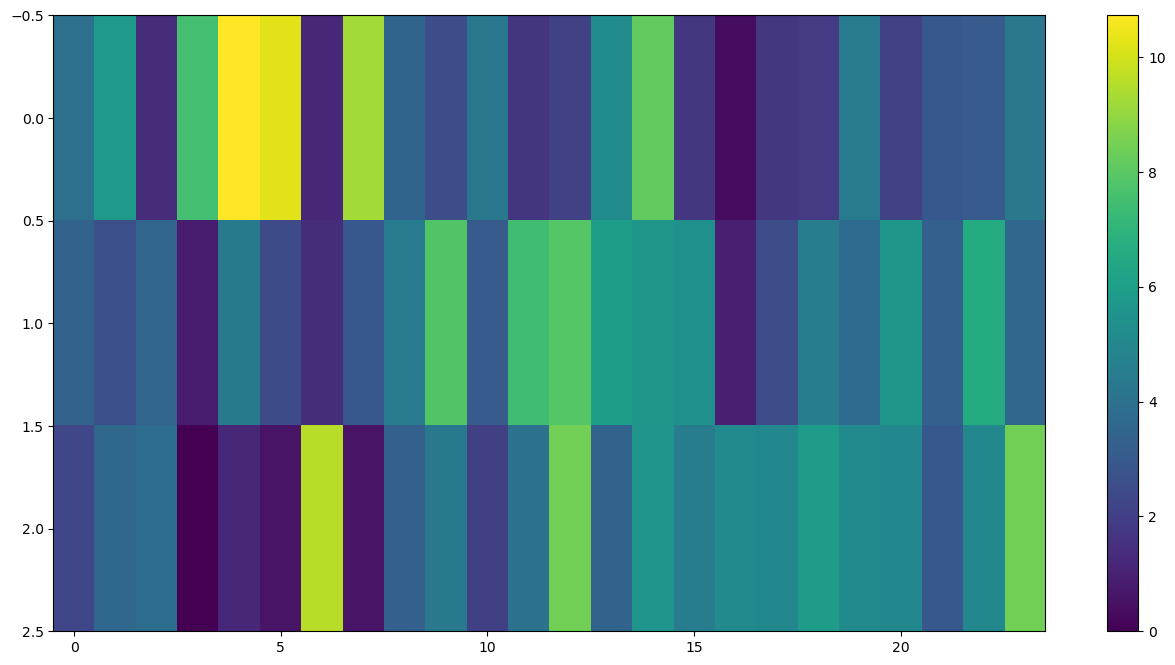

In [54]:
#Figure 4H
fig,ax = plt.subplots(1,1,figsize=(16,8))
im = ax.imshow(freq_fac_clusters_depth, cmap='viridis',aspect='auto')
fig.colorbar(im,ax=ax)
if save_fig:
    plt.savefig(folder_figure+'figure_4H.png',bbox_inches='tight')   
plt.show()
    

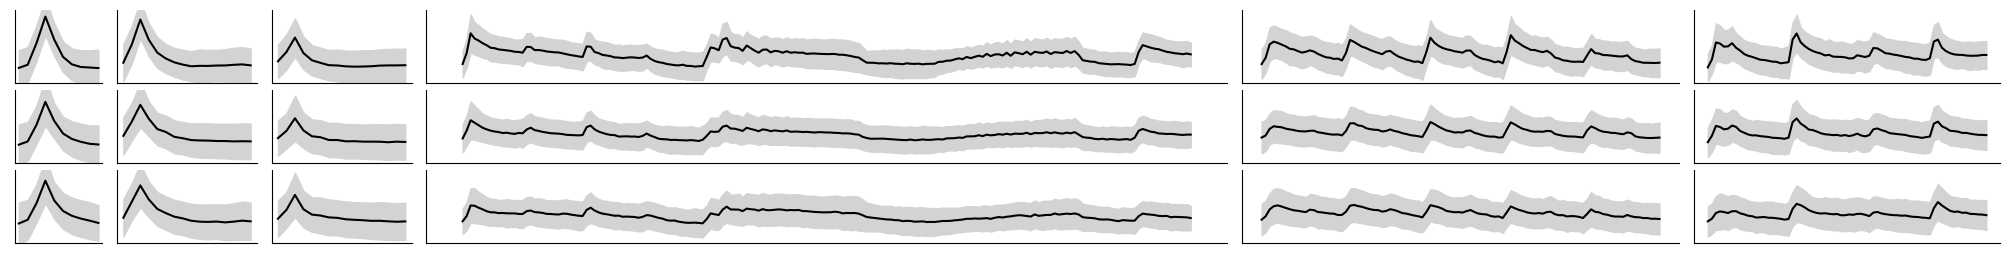

In [55]:
# %% Figure 11C, related to Figure 4: temporal across the depth
file_save_temporal_depth = folder_figure + 'figure_11C'
figure_cluster_genetic_temporal_box(df_results, 'depth_label',  X_cluster_depth,
                                 temporal_list_depth, [], temporal_zooms,
                                 columns_name_dendro.copy(), bins_list,
                                 file_save_temporal_depth, fig_params, fac=True, sampling_rate=5)

#%%
depth_label_image = []    
depth_image = []  
for i in range(num_image):
    depth_label_image.append(np.unique(df_results['depth_label'][neuron['image_id']==i])[0])
    depth_image.append(np.unique(df_results['depth'][neuron['image_id']==i])[0])
depth_num = np.unique(df_results['depth_label']).size    
n_norm_depth_mean = np.zeros((num_type,depth_num))        
n_norm_depth_sem = np.zeros((num_type,depth_num))
for i in range(depth_num):
    n_depth_temp = n_all_types_reverse[np.asarray(depth_label_image)==depth_name[i],:]
    n_depth_temp_1 = n_depth_temp[np.sum(n_depth_temp,axis=1)>=50,:]
    n_norm_depth_mean[:,i] = np.mean(n_depth_temp_1,axis=0)
    n_norm_depth_sem[:,i] = scipy.stats.sem(n_depth_temp_1,axis=0)
n_norm_depth_mean_sem = np.zeros((num_type,depth_num*2))
n_norm_depth_mean_sem[:,::2] = n_norm_depth_mean
n_norm_depth_mean_sem[:,1::2] = n_norm_depth_sem
    

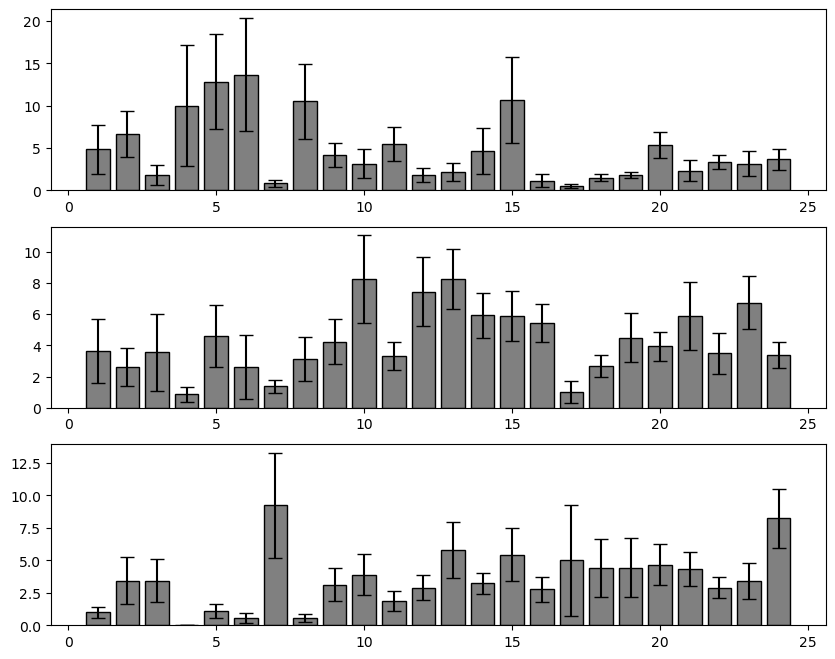

In [56]:
#Figure 11D, related to Figure 4
fig,ax = plt.subplots(3,1,figsize=(10,8))
for i in range(3):
    ax[i].bar(np.asarray(range(num_type))+1,n_norm_depth_mean_sem[:,i*2],yerr=n_norm_depth_mean_sem[:,i*2+1],color='grey',edgecolor='black',capsize=5)   
if save_fig:
    plt.savefig(folder_figure+'figure_11D.png',bbox_inches='tight')   
plt.show()

<Figure size 2000x1236 with 0 Axes>

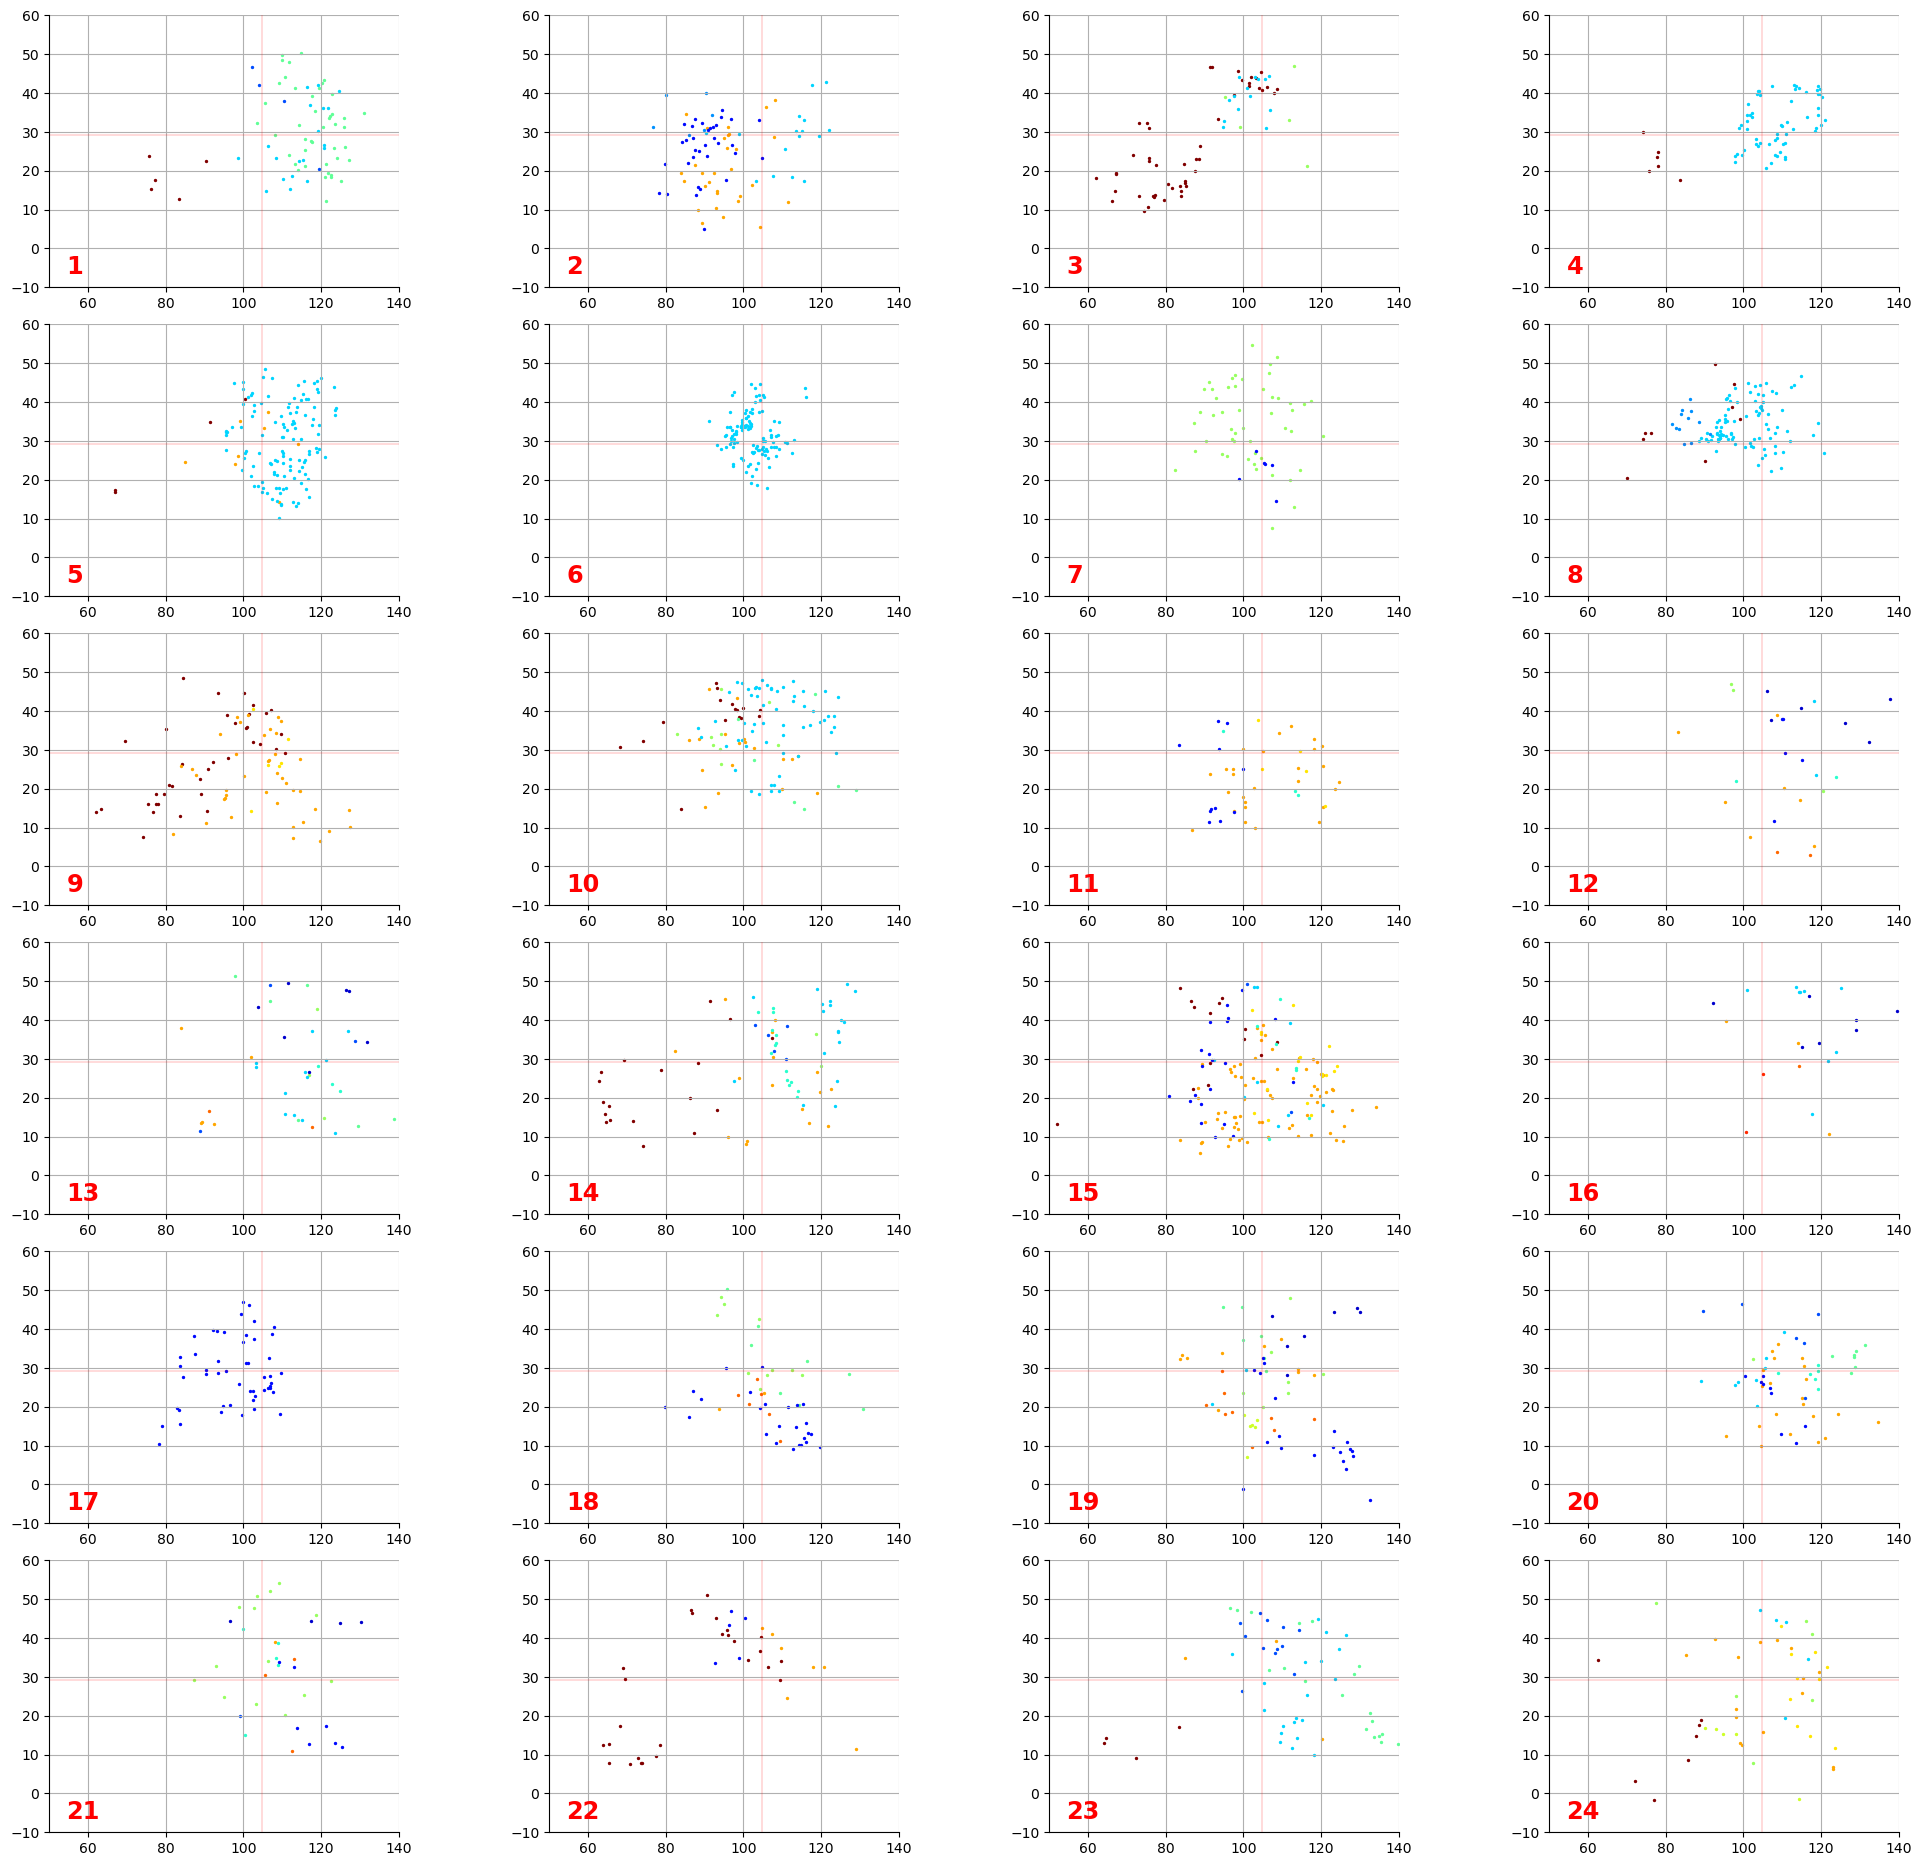

In [57]:
#%% Figure 12, related to Figure 4: scatter plot to show rf position for different functional types
fig_zoom = 2.5
hwr = 0.618 #height to width ratio
plt.figure(figsize=(fig_width*fig_zoom,fig_width*fig_zoom*hwr))
fig_params_rf_scatter = dict.copy(fig_params)
fig_params_rf_scatter['space'] = 0.02
fig_params_rf_scatter['zoom'] = 2.5
fig_params_rf_scatter['margin'] = 0
fig_params_rf_scatter['hwr'] = 0.618
fig_params_rf_scatter['fig_col'] = 4
file_save_scatter_rf_pos_cluster = folder_figure + 'figure_12'
figure_scatter_rf_pos_cluster(df_results, 'cluster_label_dendro_num',fig_params_rf_scatter, file_save_scatter_rf_pos_cluster,color_id='mouse_id')

#%% compare with retinal functional cell types in Baden et al., 2016
file_rgc_h5 = 'rgc_data.mat'
rgc_dict = hdf5storage.loadmat(folder_data + file_rgc_h5)
chirp_color_sc,chirp_color_rgc,dsi_osi_dict = rgc_sc_compare(rgc_dict,df_results,chirp['chirp_temporal_norm'],color['color_temporal_norm'])
num_type_rgc = chirp_color_rgc.shape[1]

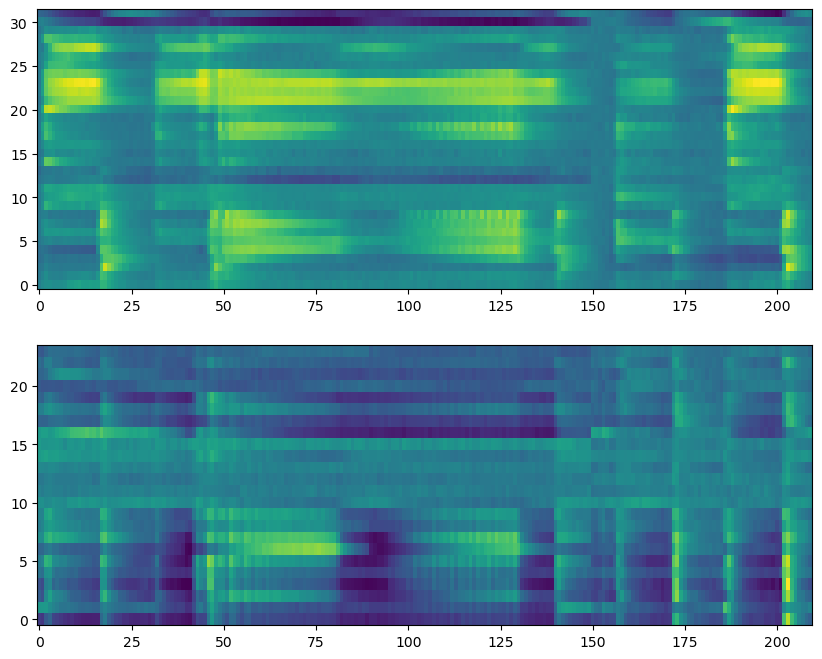

In [58]:
#Figure 13A, related to Figure 6
fig,ax = plt.subplots(2,1,figsize=(10,8))
ax[0].imshow(chirp_color_rgc.T,origin='lower',aspect='auto')
ax[1].imshow(chirp_color_sc.T,origin='lower',aspect='auto')
if save_fig:
    plt.savefig(folder_figure+'figure_13A.png',bbox_inches='tight')   
plt.show()
        

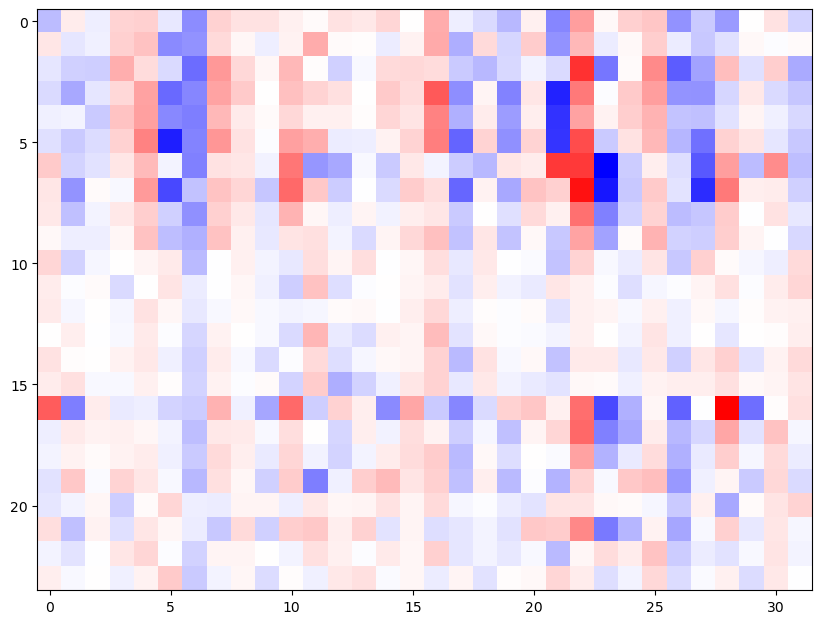

In [59]:
#Figure 6A
rgc_sc = np.linalg.pinv(chirp_color_rgc)@chirp_color_sc
fig,ax = plt.subplots(1,1,figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0)
ax.imshow(rgc_sc.T,aspect='equal',cmap='bwr',norm=norm)
if save_fig:
    plt.savefig(folder_figure+'figure_6A.png',bbox_inches='tight')    
plt.show()
   

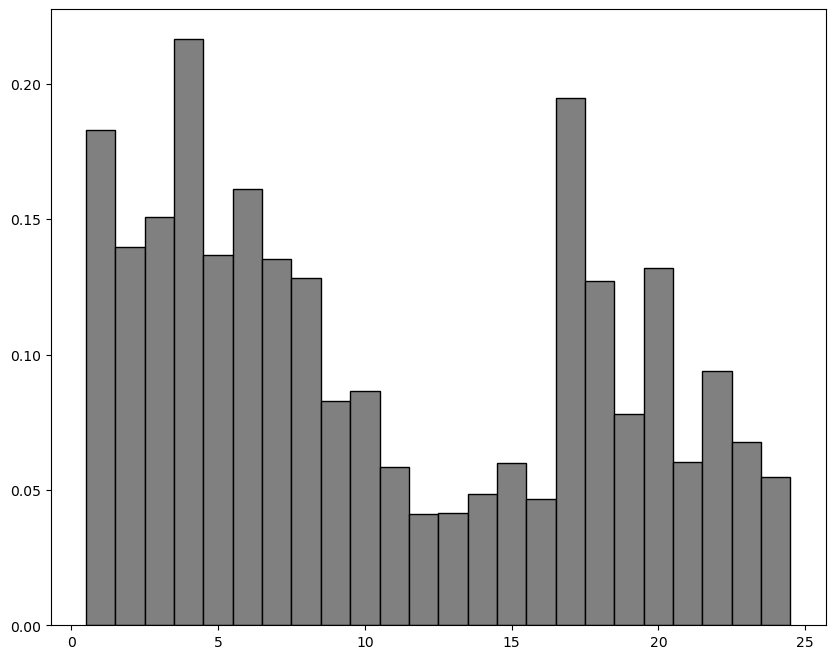

In [60]:
#Figure 13B, related to Figure 6    
rgc_sc_1 = chirp_color_sc.T@np.linalg.pinv(chirp_color_rgc.T)# this is the same as rgc_sc_T
chirp_color_sc_predict = (rgc_sc_1@chirp_color_rgc.T).T
chirp_color_sc_error = np.linalg.norm(chirp_color_sc - chirp_color_sc_predict,axis=0)/np.linalg.norm(chirp_color_sc_predict,axis=0) 
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.bar(np.array(range(num_type))+1,chirp_color_sc_error,width=1,color='grey',edgecolor='black')
if save_fig:
    plt.savefig(folder_figure+'figure_13B.png',bbox_inches='tight')   
plt.show()
    

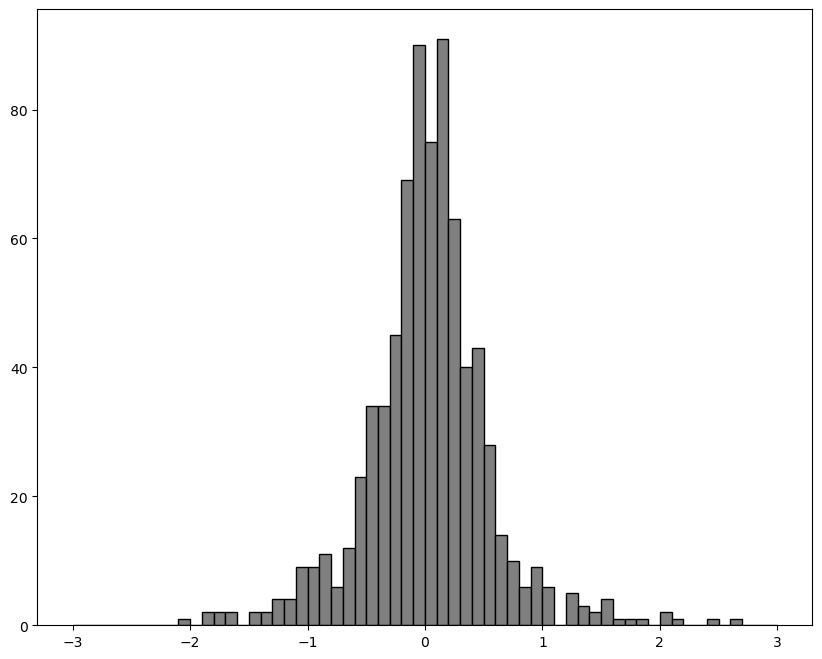

In [61]:
#Figure 13C, related to Figure 6   
rgc_sc_weight = rgc_sc.flatten()
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(rgc_sc_weight,bins=np.linspace(-3,3,61),color='grey',edgecolor='black')
if save_fig:
    plt.savefig(folder_figure+'figure_13C.png',bbox_inches='tight')       
plt.show()

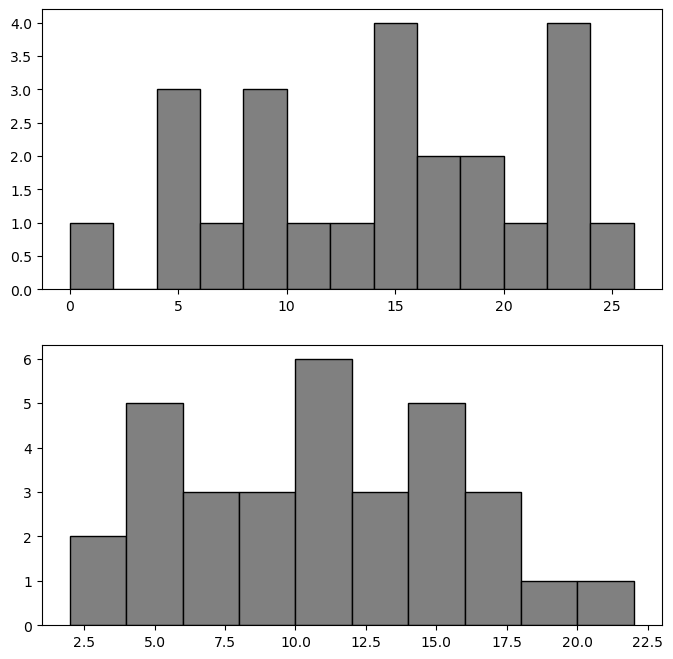

In [62]:
#Figure 13D, related to Figure 6
rgc_sc_count_sc = np.sum(np.abs(rgc_sc)>0.3,axis=0)
rgc_sc_count_rgc = np.sum(np.abs(rgc_sc)>0.3,axis=1)
fig,ax = plt.subplots(2,1,figsize=(8,8))
ax[0].hist(rgc_sc_count_sc,bins=np.linspace(0,26,14),color='grey',edgecolor='black')
ax[1].hist(rgc_sc_count_rgc,bins=np.linspace(2,22,11),color='grey',edgecolor='black')
if save_fig:
    plt.savefig(folder_figure+'figure_13D.png',bbox_inches='tight')    
plt.show()
    

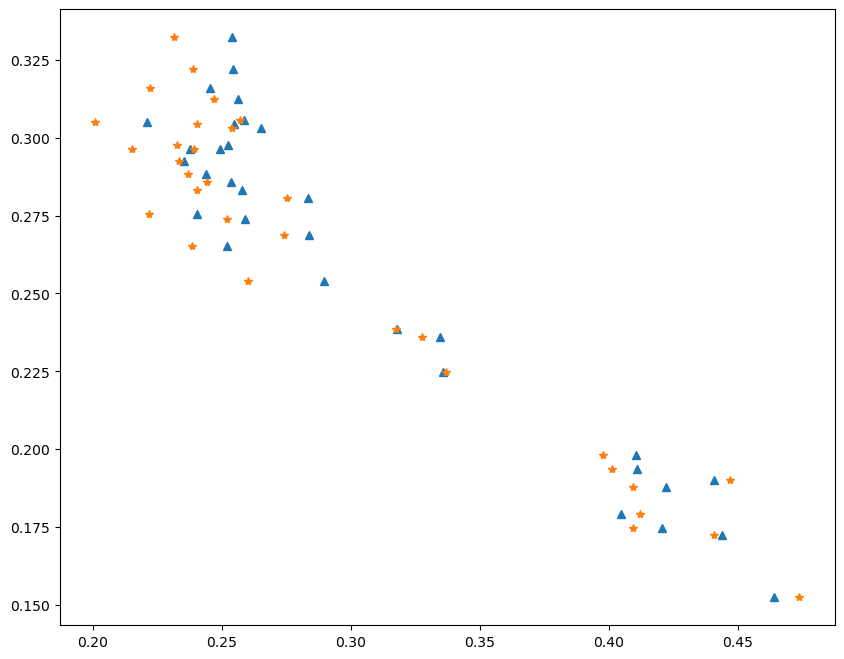

In [63]:
#Figure 6B
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(dsi_osi_dict['dsi_rgc_mean'],dsi_osi_dict['osi_rgc_mean'],'^')
ax.plot(dsi_osi_dict['dsi_rgc_median'],dsi_osi_dict['osi_rgc_median'],'*')
if save_fig:
    plt.savefig(folder_figure+'figure_6B.png',bbox_inches='tight')   
plt.show()
    

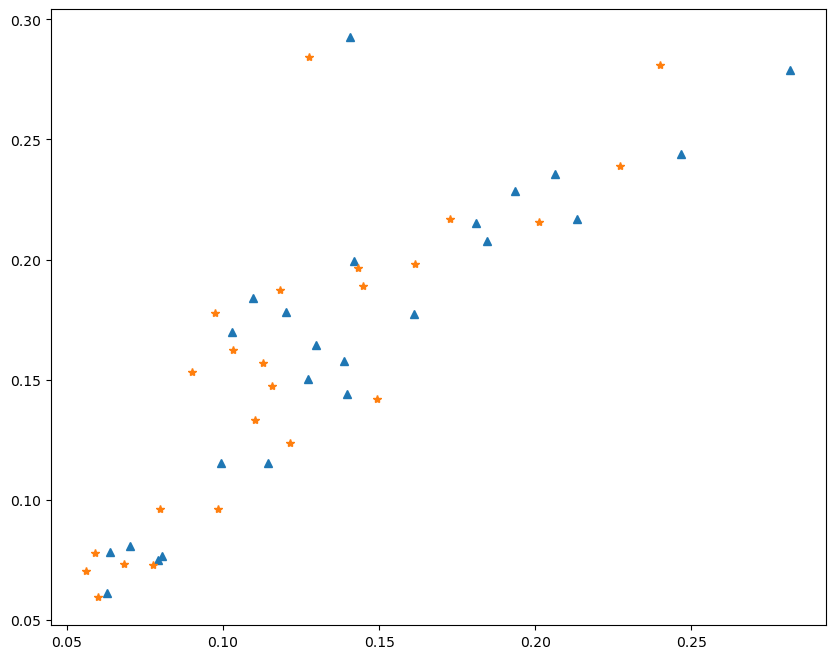

In [64]:
#Figure 6C
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(dsi_osi_dict['dsi_sc_mean'],dsi_osi_dict['osi_sc_mean'],'^')
ax.plot(dsi_osi_dict['dsi_sc_median'],dsi_osi_dict['osi_sc_median'],'*')
if save_fig:
    plt.savefig(folder_figure+'figure_6C.png',bbox_inches='tight')      
plt.show()

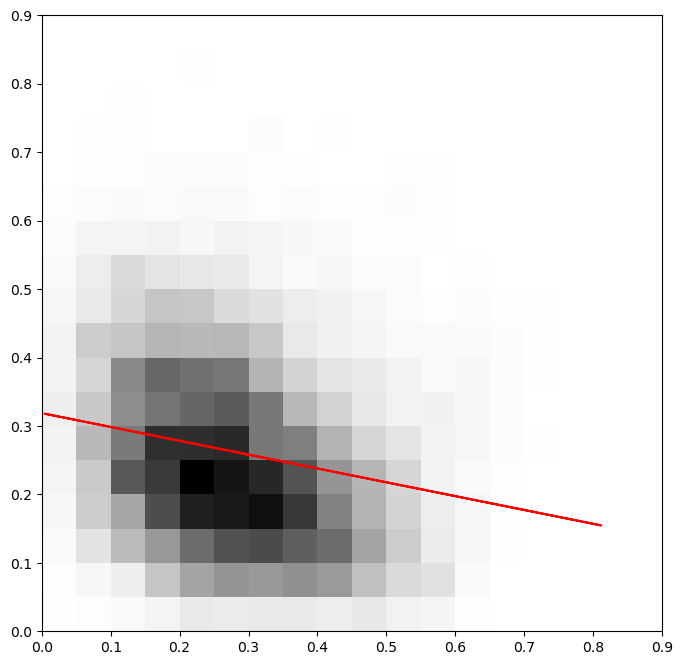

In [65]:
#Figure 13E, related to Figure 6
bins=np.linspace(0,0.9,19)
hist_2d_linear_regress(rgc_dict['dsi'].ravel(),rgc_dict['osi'].ravel(),bins=bins)
if save_fig:
    plt.savefig(folder_figure+'figure_13E.png',bbox_inches='tight')   
plt.show()

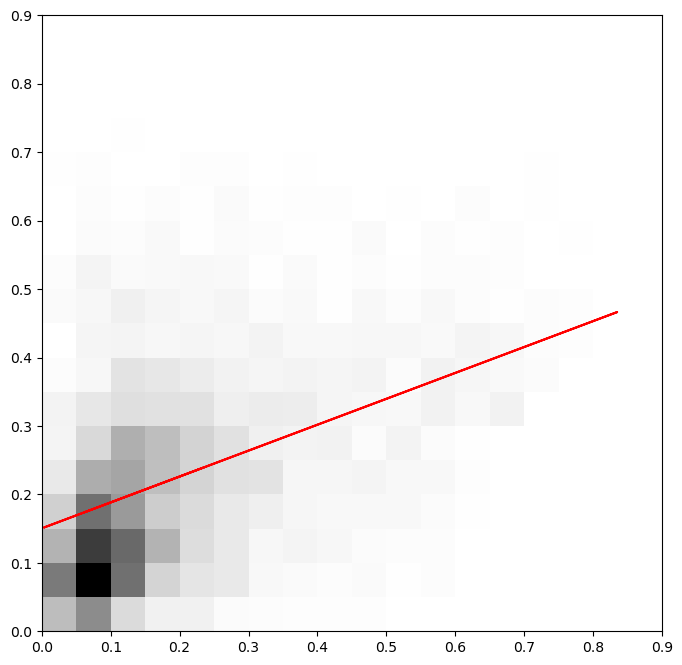

In [66]:
#Figure 13F, related to Figure 6
hist_2d_linear_regress(df_results['gdsi_svd'].ravel(),df_results['gosi_svd'].ravel(),bins=bins)
if save_fig:
    plt.savefig(folder_figure+'figure_13F.png',bbox_inches='tight')    
plt.show()

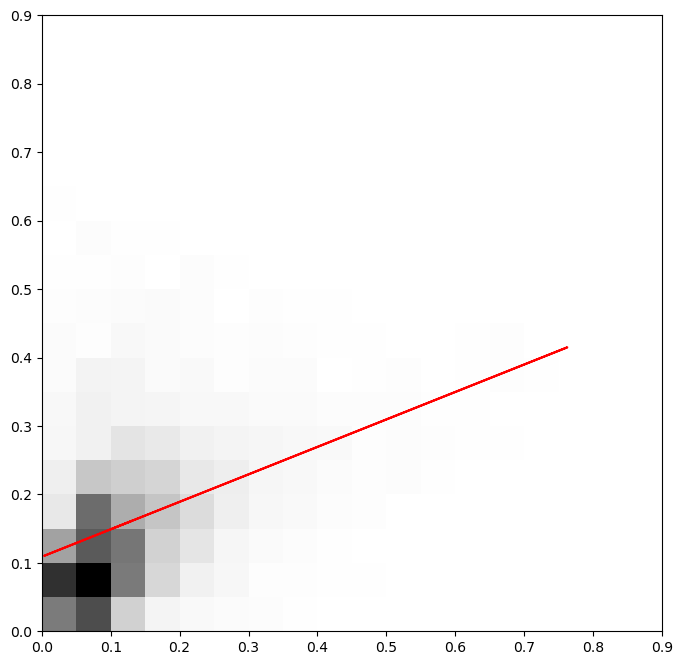

In [67]:
#Figure 13G, related to Figure 6
hist_2d_linear_regress(df_results['gdsi'].ravel(),df_results['gosi'].ravel(),bins=bins)
if save_fig:
    plt.savefig(folder_figure+'figure_13G.png',bbox_inches='tight')  
plt.show()

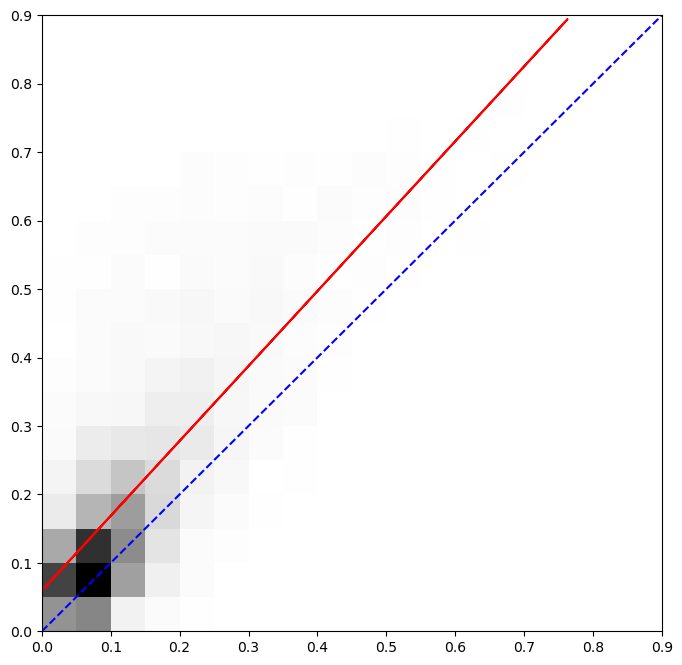

In [68]:
#Figure 13H, related to Figure 6    
hist_2d_linear_regress(df_results['gdsi'].ravel(),df_results['gdsi_svd'].ravel(),bins=bins,identity_line=True)
if save_fig:
    plt.savefig(folder_figure+'figure_13H.png',bbox_inches='tight')  
plt.show()

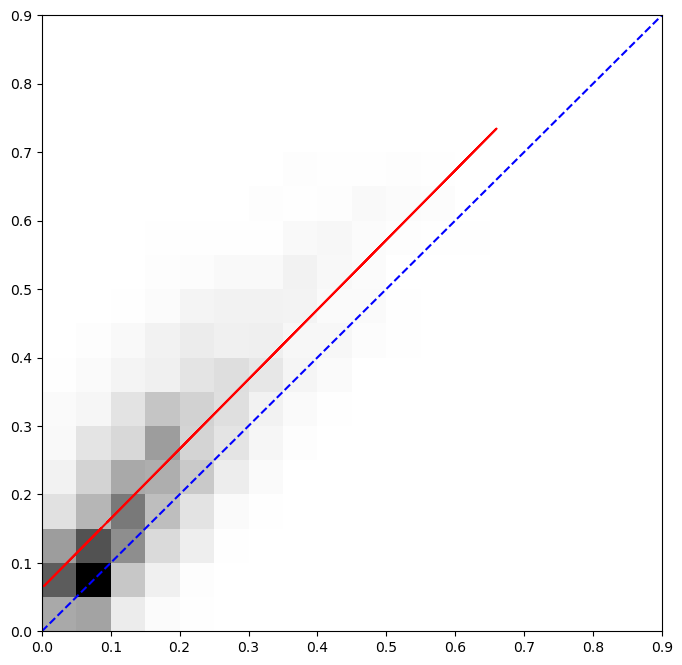

In [69]:
#Figure 13I, related to Figure 6    
hist_2d_linear_regress(df_results['gosi'].ravel(),df_results['gosi_svd'].ravel(),bins=bins,identity_line=True)
if save_fig:
    plt.savefig(folder_figure+'figure_13I.png',bbox_inches='tight')  
plt.show()
    

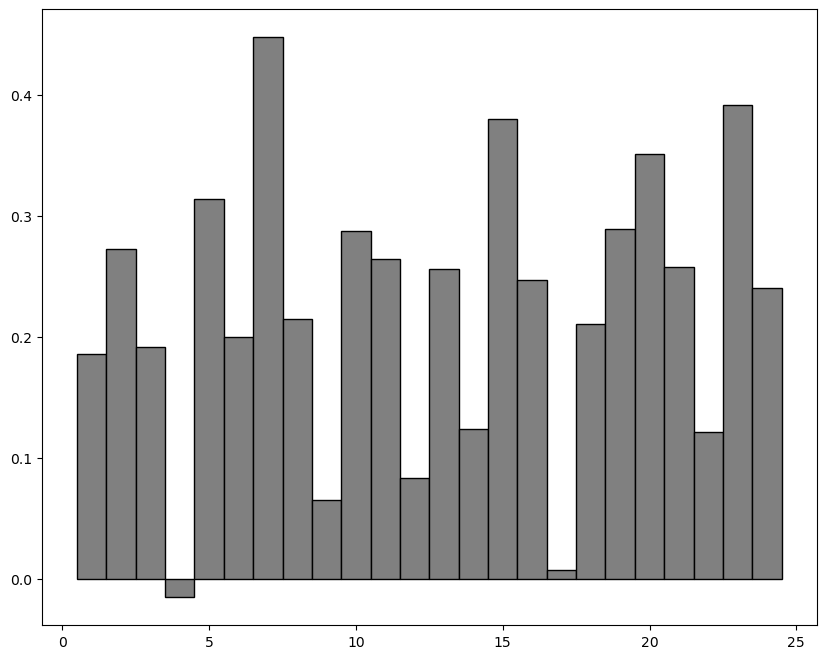

In [70]:
#Figure 13J, related to Figure 6
dsi_osi_r = np.zeros(num_type)
for i in range(num_type):
    _idx = df_results['cluster_label_dendro_num']==num_type-i-1
    dsi_osi_r[i],_ = scipy.stats.pearsonr(df_results['gdsi'][_idx],df_results['gosi'][_idx])
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.bar(np.array(range(num_type))+1,dsi_osi_r,width=1,color='grey',edgecolor='black')
if save_fig:
    plt.savefig(folder_figure+'figure_13J.png',bbox_inches='tight')  
plt.show()

In [71]:
#%% find the pc that explains chirp_rgc_match and chirp_
_,_,_,_,lmd_chirp_color_rgc = pca_analysis(chirp_color_rgc,0.9,plot_flag=False)
load_lmd_sc_sub = True
# use subsampling to add error bar to lmd
if load_lmd_sc_sub:
    lmd_chirp_color_sc_sub_mean_sd = np.loadtxt(folder_data + 'lmd_chirp_color_sc_sub_mean_sd.csv',delimiter=',')
    lmd_chirp_color_sc_sub_mean = lmd_chirp_color_sc_sub_mean_sd[:,0]
    lmd_chirp_color_sc_sub_sd = lmd_chirp_color_sc_sub_mean_sd[:,1]
else: 
    n_sub_sample = 1000
    lmd_chirp_color_sc_sub = np.zeros((n_sub_sample,num_type))
    for i in range(n_sub_sample):
        print(i)
        _chirp_color_sc,_,_ = rgc_sc_compare(rgc_dict,df_results,chirp['chirp_temporal_norm'],color['color_temporal_norm'],rnd_seed=i,sub_perc=1,bootstrap=True)
        _,_,_,_,lmd_chirp_color_sc_sub[i,:] = pca_analysis(_chirp_color_sc,0.9,plot_flag=False)
        
    lmd_chirp_color_sc_sub_mean = np.mean(lmd_chirp_color_sc_sub,axis=0)
    lmd_chirp_color_sc_sub_sd = np.std(lmd_chirp_color_sc_sub,axis=0)
    lmd_chirp_color_sc_sub_mean_sd = np.stack((lmd_chirp_color_sc_sub_mean,lmd_chirp_color_sc_sub_sd),axis=1)
    np.savetxt(folder_data + 'lmd_chirp_color_sc_sub_mean_sd.csv', lmd_chirp_color_sc_sub_mean_sd,delimiter=',')

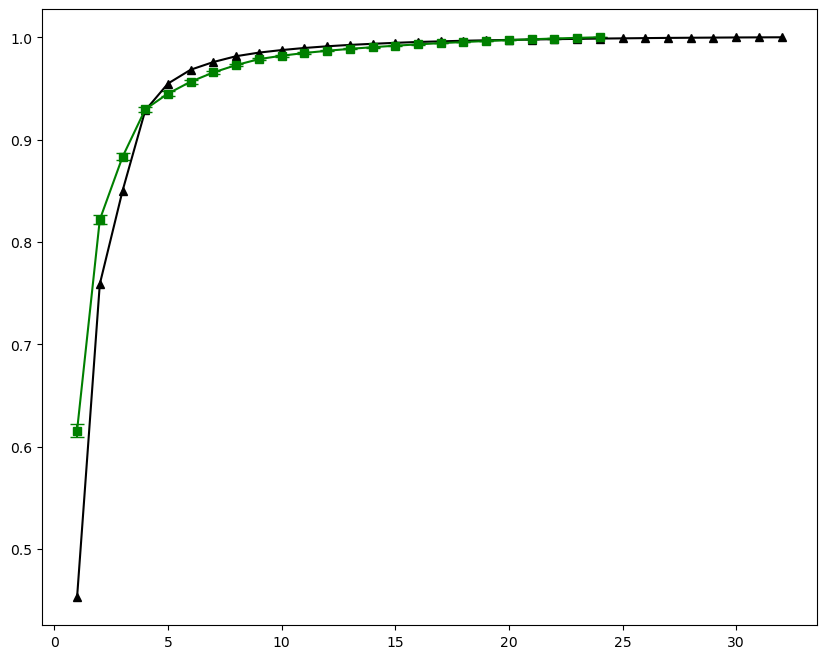

In [72]:
#Figure 6D
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.errorbar(np.array(range(1,num_type+1)),lmd_chirp_color_sc_sub_mean,yerr=lmd_chirp_color_sc_sub_sd,
             color='green',marker='s',capsize=5,ls='-')
ax.plot(np.array(range(1,num_type_rgc+1)),lmd_chirp_color_rgc,
             color='black',marker='^',ls='-')
if save_fig:
    plt.savefig(folder_figure+'figure_6D.png',bbox_inches='tight')      
plt.show()